In [291]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import re
import json
import ast
from matplotlib.ticker import FuncFormatter
import glob
from matplotlib import animation
from scipy.spatial.distance import pdist, squareform
from itertools import combinations
import scipy
from scipy.stats import entropy
from sklearn import manifold
from adjustText import adjust_text
from mpl_toolkits import mplot3d
import networkx as nx

In [2]:
#plt.style.use('seaborn-white')
plt.style.use('seaborn')
# for matplotlib xkcd I need to install new font without root, like this: 
#https://community.linuxmint.com/tutorial/view/29
# and then ivalidate cache like this: 
#https://stackoverflow.com/questions/19663986/getting-xkcd-plots-using-matplotlib/22812176#22812176
# or by deleting by: rm ~/.cache/matplotlib -r
# the font ttf file must be in ~/.fonts/fonts/truetype/humor-sans directory

# to recover from xkcd
#mpl.rcParams.update(saved_state)

# to save state and go to xkcd
#saved_state = mpl.rcParams.copy()
#plt.xkcd()


In [3]:
animes = pd.read_csv('anime_cleaned.csv')
users = pd.read_csv('users_cleaned.csv')
animelists = pd.read_csv('animelists_cleaned.csv')

In [4]:
users['birth_date'] = pd.to_datetime(users['birth_date'])
users['last_online'] = pd.to_datetime(users['last_online'])
users['join_date'] = pd.to_datetime(users['join_date'])
# renaming possibly array-like columns to end with -s
animes = animes.rename(columns={'genre': 'genres', 'studio': 'studios'})

In [5]:
# setting index for primary identifiers
animes = animes.set_index('anime_id')
users = users.set_index('username')


In [6]:
animes.head()

title              title_english title_japanese  \
anime_id                                                                  
11013           Inu x Boku SS  Inu X Boku Secret Service         妖狐×僕SS   
2104         Seto no Hanayome      My Bride is a Mermaid          瀬戸の花嫁   
5262       Shugo Chara!! Doki         Shugo Chara!! Doki    しゅごキャラ！！どきっ   
721             Princess Tutu              Princess Tutu      プリンセスチュチュ   
12365     Bakuman. 3rd Season                   Bakuman.          バクマン。   

                                         title_synonyms  \
anime_id                                                  
11013                                   Youko x Boku SS   
2104                               The Inland Sea Bride   
5262      Shugo Chara Ninenme, Shugo Chara! Second Year   
721                                                 NaN   
12365                                  Bakuman Season 3   

                                                  image_url type    source  \
anime_id                                                                     
11013     https://myanimelist.cdn-dena.com/images/anime/...   TV     Manga   
2104      https://myanimelist.cdn-dena.com/images/anime/...   TV     Manga   
5262      https://myanimelist.cdn-dena.com/images/anime/...   TV     Manga   
721       https://myanimelist.cdn-dena.com/images/anime/...   TV  Original   
12365     https://myanimelist.cdn-dena.com/images/anime/...   TV     Manga   

          episodes           status  airing      ...         premiered  \
anime_id                                         ...                     
11013           12  Finished Airing   False      ...       Winter 2012   
2104            26  Finished Airing   False      ...       Spring 2007   
5262            51  Finished Airing   False      ...         Fall 2008   
721             38  Finished Airing   False      ...       Summer 2002   
12365           25  Finished Airing   False      ...         Fall 2012   

                   broadcast  \
anime_id                       
11013     Fridays at Unknown   
2104                 Unknown   
5262                 Unknown   
721       Fridays at Unknown   
12365                Unknown   

                                                    related  \
anime_id                                                      
11013     {'Adaptation': [{'mal_id': 17207, 'type': 'man...   
2104      {'Adaptation': [{'mal_id': 759, 'type': 'manga...   
5262      {'Adaptation': [{'mal_id': 101, 'type': 'manga...   
721       {'Adaptation': [{'mal_id': 1581, 'type': 'mang...   
12365     {'Adaptation': [{'mal_id': 9711, 'type': 'mang...   

                                                   producer          licensor  \
anime_id                                                                        
11013     Aniplex, Square Enix, Mainichi Broadcasting Sy...  Sentai Filmworks   
2104                      TV Tokyo, AIC, Square Enix, Sotsu        Funimation   
5262                                        TV Tokyo, Sotsu               NaN   
721                      Memory-Tech, GANSIS, Marvelous AQL         ADV Films   
12365                                         NHK, Shueisha               NaN   

                   studios                                    genres  \
anime_id                                                               
11013     David Production    Comedy, Supernatural, Romance, Shounen   
2104                 Gonzo  Comedy, Parody, Romance, School, Shounen   
5262             Satelight             Comedy, Magic, School, Shoujo   
721         Hal Film Maker    Comedy, Drama, Magic, Romance, Fantasy   
12365            J.C.Staff           Comedy, Drama, Romance, Shounen   

                                              opening_theme  \
anime_id                                                      
11013                                 ['"Nirvana" by MUCC']   
2104                     ['"Romantic summer" by SUN&LUNAR']   
5262      ['#1: "Minna no 

In [7]:
animes.columns

Index(['title', 'title_english', 'title_japanese', 'title_synonyms',
       'image_url', 'type', 'source', 'episodes', 'status', 'airing',
       'aired_string', 'aired', 'duration', 'rating', 'score', 'scored_by',
       'rank', 'popularity', 'members', 'favorites', 'background', 'premiered',
       'broadcast', 'related', 'producer', 'licensor', 'studios', 'genres',
       'opening_theme', 'ending_theme', 'duration_min'],
      dtype='object')

In [8]:
animes[['title', 'type', 'source', 'episodes', 'status',
       'airing', 'aired_string', 'aired', 'duration', 'background',
       'premiered', 'broadcast', 'related', 'producer', 'licensor', 'studios',
       'genres', 'opening_theme', 'ending_theme', 'duration_min']].head()

title type    source  episodes           status  \
anime_id                                                                  
11013           Inu x Boku SS   TV     Manga        12  Finished Airing   
2104         Seto no Hanayome   TV     Manga        26  Finished Airing   
5262       Shugo Chara!! Doki   TV     Manga        51  Finished Airing   
721             Princess Tutu   TV  Original        38  Finished Airing   
12365     Bakuman. 3rd Season   TV     Manga        25  Finished Airing   

          airing                  aired_string  \
anime_id                                         
11013      False  Jan 13, 2012 to Mar 30, 2012   
2104       False    Apr 2, 2007 to Oct 1, 2007   
5262       False   Oct 4, 2008 to Sep 25, 2009   
721        False  Aug 16, 2002 to May 23, 2003   
12365      False   Oct 6, 2012 to Mar 30, 2013   

                                               aired         duration  \
anime_id                                                                
11013     {'from': '2012-01-13', 'to': '2012-03-30'}  24 min. per ep.   
2104      {'from': '2007-04-02', 'to': '2007-10-01'}  24 min. per ep.   
5262      {'from': '2008-10-04', 'to': '2009-09-25'}  24 min. per ep.   
721       {'from': '2002-08-16', 'to': '2003-05-23'}  16 min. per ep.   
12365     {'from': '2012-10-06', 'to': '2013-03-30'}  24 min. per ep.   

                                                 background    premiered  \
anime_id                                                                   
11013     Inu x Boku SS was licensed by Sentai Filmworks...  Winter 2012   
2104                                                    NaN  Spring 2007   
5262                                                    NaN    Fall 2008   
721       Princess Tutu aired in two parts. The first pa...  Summer 2002   
12365                                                   NaN    Fall 2012   

                   broadcast  \
anime_id                       
11013     Fridays at Unknown   
2104                 Unknown   
5262                 Unknown   
721       Fridays at Unknown   
12365                Unknown   

                                                    related  \
anime_id                                                      
11013     {'Adaptation': [{'mal_id': 17207, 'type': 'man...   
2104      {'Adaptation': [{'mal_id': 759, 'type': 'manga...   
5262      {'Adaptation': [{'mal_id': 101, 'type': 'manga...   
721       {'Adaptation': [{'mal_id': 1581, 'type': 'mang...   
12365     {'Adaptation': [{'mal_id': 9711, 'type': 'mang...   

                                                   producer          licensor  \
anime_id                                                                        
11013     Aniplex, Square Enix, Mainichi Broadcasting Sy...  Sentai Filmworks   
2104                      TV Tokyo, AIC, Square Enix, Sotsu        Funimation   
5262                                        TV Tokyo, Sotsu               NaN   
721                      Memory-Tech, GANSIS, Marvelous AQL         ADV Films   
12365                                         NHK, Shueisha               NaN   

                   studios                                    genres  \
anime_id                                                               
11013     David Production    Comedy, Supernatural, Romance, Shounen   
2104                 Gonzo  Comedy, Parody, Romance, School, Shounen   
5262             Satelight             Comedy, Magic, School, Shoujo   
721         Hal Film Maker    Comedy, Drama, Magic, Romance, Fantasy   
12365            J.C.Staff           Comedy, Drama, Romance, Shounen   

                                              opening_theme  \
anime_id                                                      
11013                                 ['"Nirvana" by MUCC']   
2104                     ['"Romantic summer" by SUN&LUNAR']   
5262      ['#1: "Minna no Tamago (みんなのたまご)" by Shugo Cha...   
721                  ['"Morning Grace" by Ritsu

In [9]:
animes['aired_from'] = pd.to_datetime(animes['aired'].apply(lambda x: ast.literal_eval(x.replace('\'', '"'))['from']), errors='coerce')

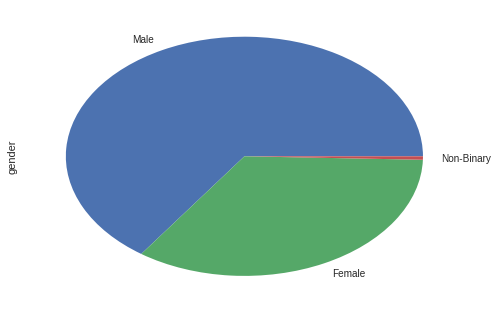

In [10]:
users['gender'].value_counts().plot.pie()

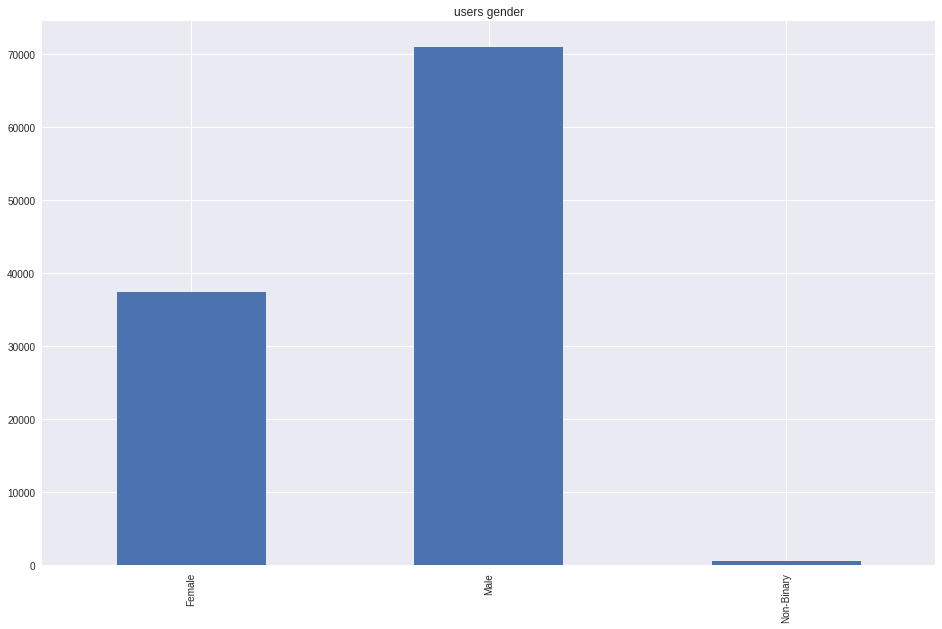

In [11]:
users['gender'].value_counts().sort_index().plot.bar(figsize=(16, 10), title='users gender')

In [12]:
users['age'] = 2018 - users['birth_date'].dt.year

In [13]:
print(users['age'].min())
print(users['age'].max())


10
49


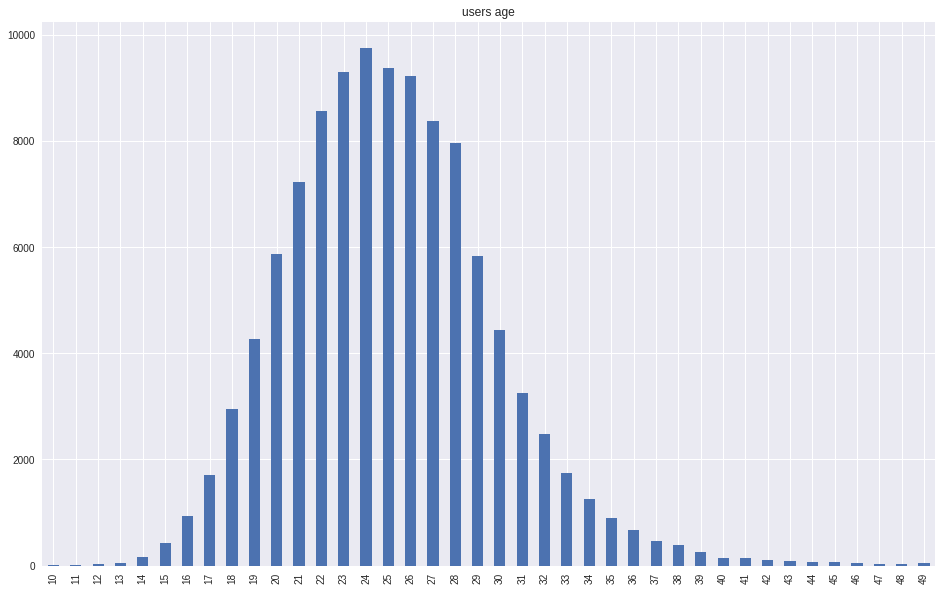

In [14]:
users['age'].value_counts().sort_index().plot.bar(figsize=(16, 10), title='users age')

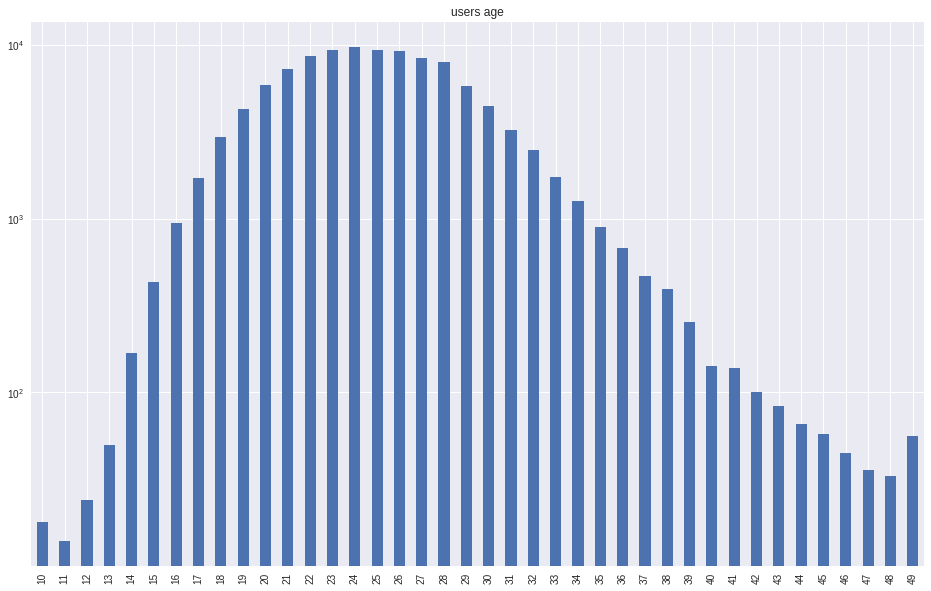

In [15]:
users['age'].value_counts().sort_index().plot.bar(figsize=(16, 10), title='users age', logy=True)

In [16]:
users['age'].describe()

count    108711.000000
mean         25.125820
std           4.632399
min          10.000000
25%          22.000000
50%          25.000000
75%          28.000000
max          49.000000
Name: age, dtype: float64

In [17]:
((users['age'] > 45) | (users['age'] < 10)).sum() / users['age'].count()

0.0015637791943777539

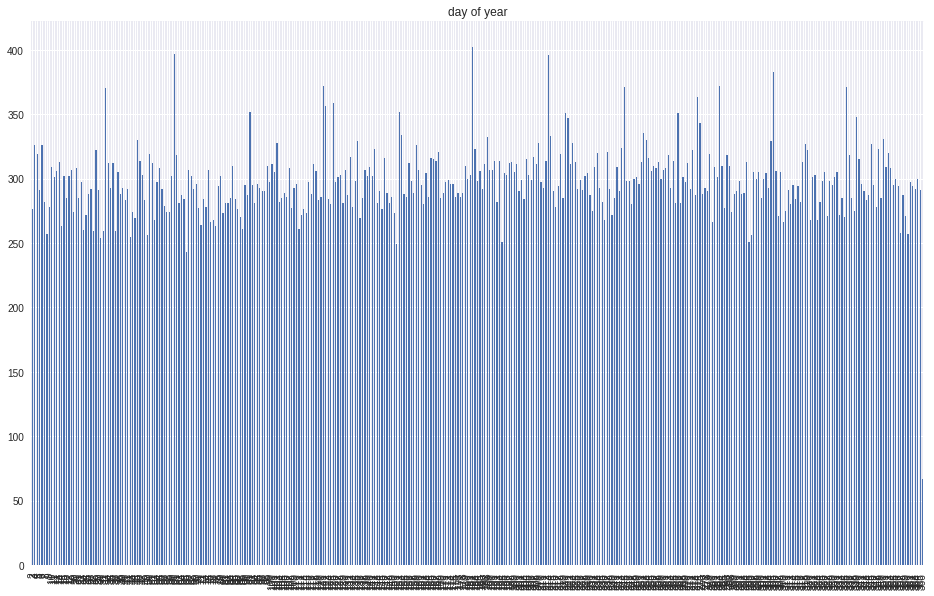

In [18]:
users['birth_date'].dt.dayofyear.value_counts().sort_index().plot.bar(figsize=(16, 10), title='day of year')

In [19]:
display(users[users['birth_date'].dt.dayofyear == 1]['age'].describe())
display(users['age'].describe())


count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: age, dtype: float64

count    108711.000000
mean         25.125820
std           4.632399
min          10.000000
25%          22.000000
50%          25.000000
75%          28.000000
max          49.000000
Name: age, dtype: float64

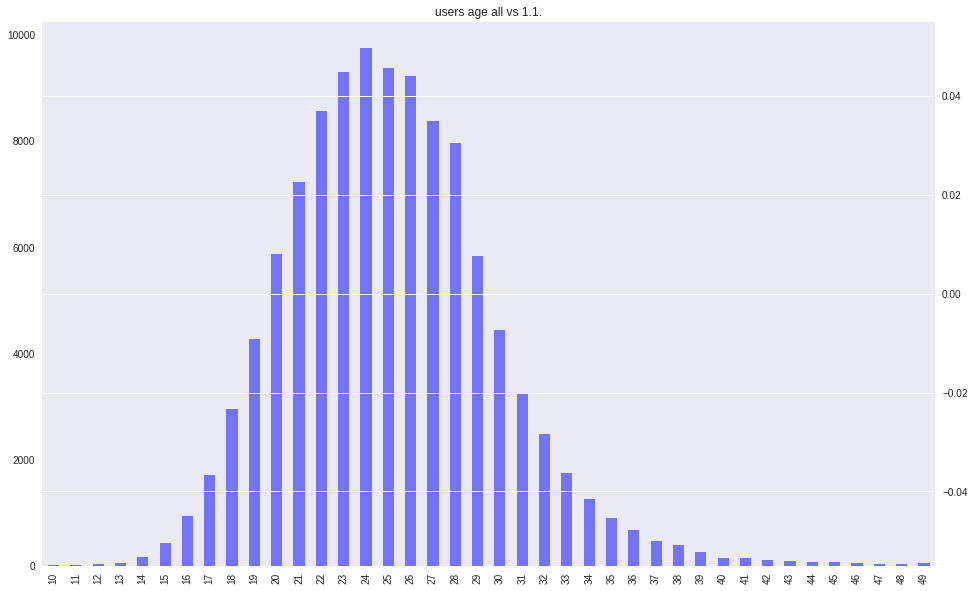

In [20]:
total_count = users['age'].count()
first_jan_count = users[users['birth_date'].dt.dayofyear == 1]['age'].count()
plt.figure(figsize=(16, 10))
ax = plt.gca()

users_in_first_jan = users[users['birth_date'].dt.dayofyear == 1]['age'].value_counts()
users_in_first_jan = users_in_first_jan.reindex(users['age'].value_counts().index)
users['age'].value_counts().sort_index().plot.bar(ax=ax, title='users age all vs 1.1.', color='blue', alpha=0.5)
users_in_first_jan.sort_index().plot.bar(ax=ax, color='red', alpha=0.5, secondary_y=True)
#ax.set_xlim(users['age'].min(), users['age'].max())
#plt.xticks(users['age'].value_counts().index)
plt.show()

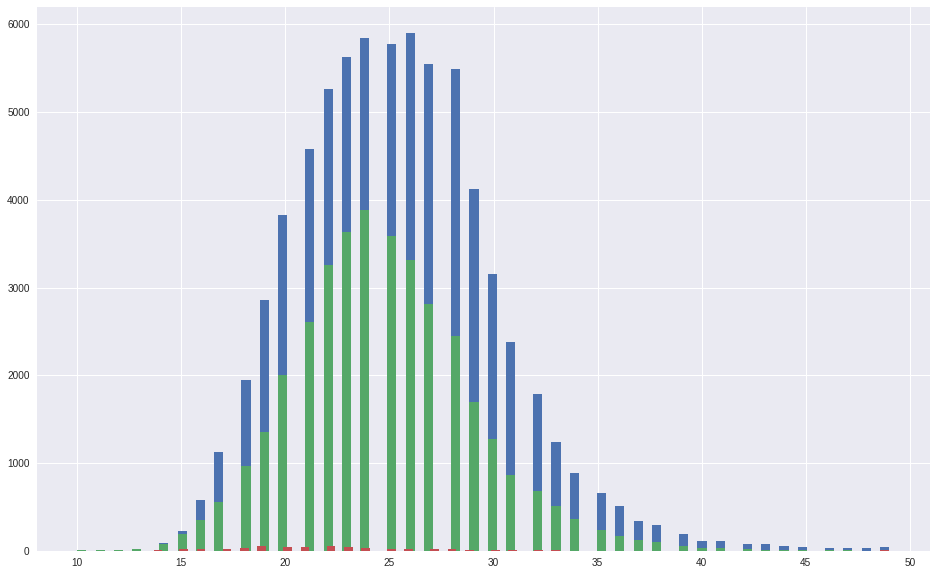

In [21]:
users[users['gender'] == 'Male']['age'].hist(bins=89, figsize=(16,10))
users[users['gender'] == 'Female']['age'].hist(bins=89, figsize=(16,10))
users[users['gender'] == 'Non-Binary']['age'].hist(bins=89, figsize=(16,10))


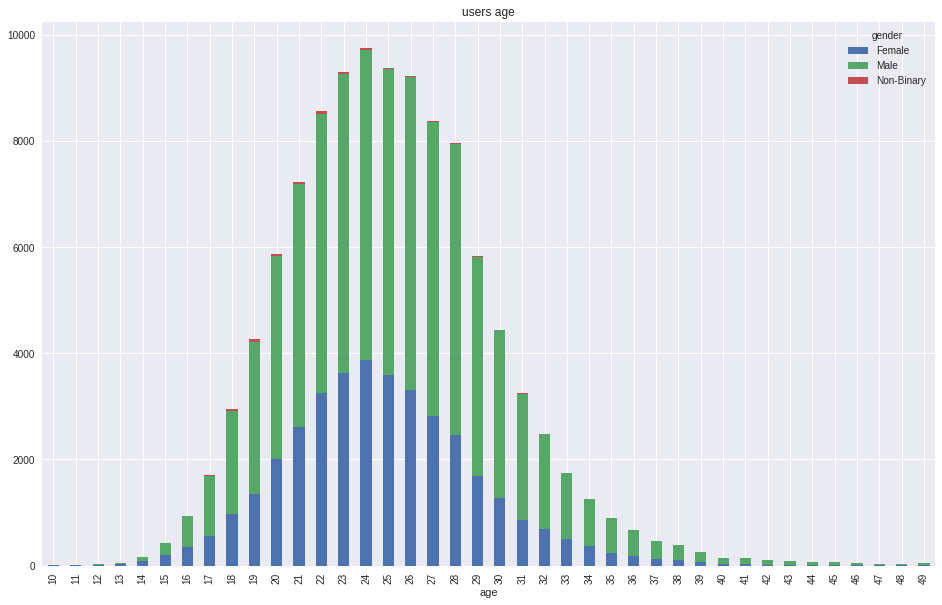

In [22]:
user_gender_age = pd.crosstab(users['age'], users['gender'])
user_gender_age.plot.bar(stacked=True, figsize=(16, 10), title='users age')


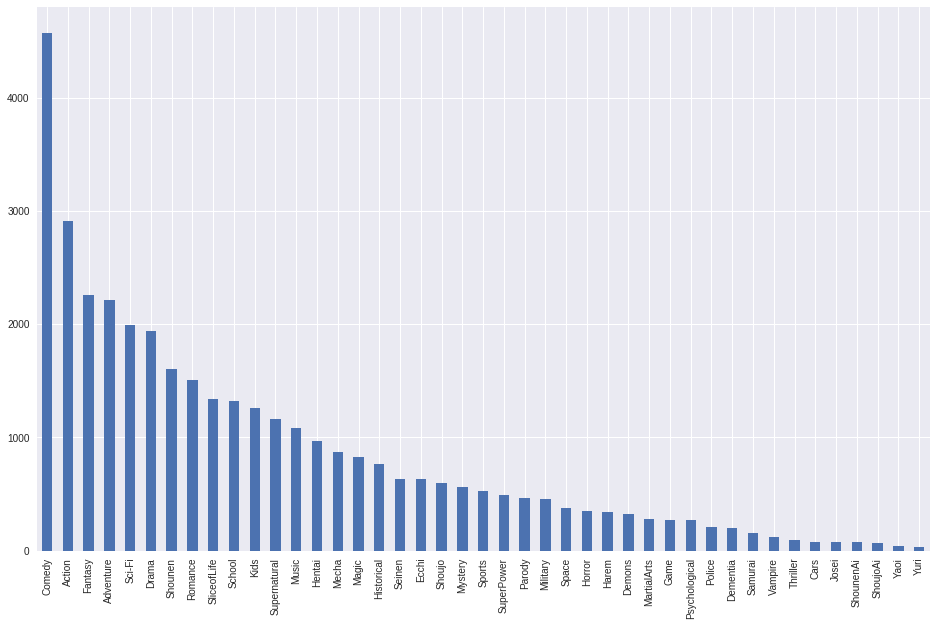

In [23]:
animes['genres'].fillna('', inplace=True)
genres = animes['genres'].apply(lambda x: x.replace(' ', '').split(','))
genres = pd.Series([y for x in genres for y in x if y != '']).value_counts()
genres.plot(kind='bar', figsize=(16, 10))

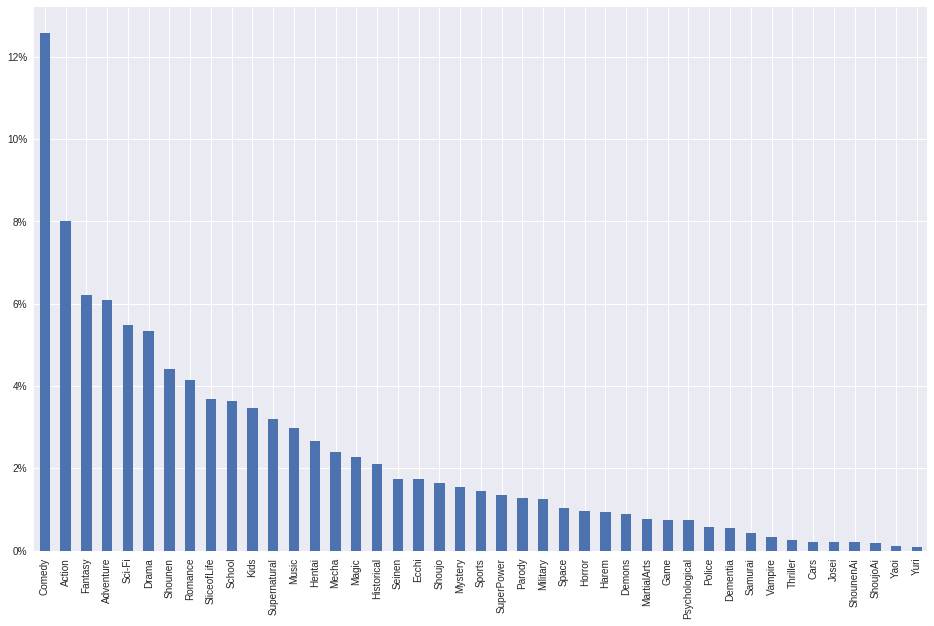

In [24]:
(genres / genres.sum()).plot(kind='bar', figsize=(16, 10))
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 

In [25]:
genres / genres.sum()

Comedy           0.125808
Action           0.080085
Fantasy          0.062092
Adventure        0.060965
Sci-Fi           0.054830
Drama            0.053454
Shounen          0.044265
Romance          0.041514
SliceofLife      0.036755
School           0.036287
Kids             0.034554
Supernatural     0.031940
Music            0.029905
Hentai           0.026548
Mecha            0.024017
Magic            0.022834
Historical       0.021073
Seinen           0.017525
Ecchi            0.017497
Shoujo           0.016479
Mystery          0.015516
Sports           0.014443
SuperPower       0.013645
Parody           0.012820
Military         0.012518
Space            0.010482
Horror           0.009656
Harem            0.009299
Demons           0.008969
MartialArts      0.007676
Game             0.007428
Psychological    0.007345
Police           0.005695
Dementia         0.005585
Samurai          0.004292
Vampire          0.003356
Thriller         0.002614
Cars             0.002228
Josei       

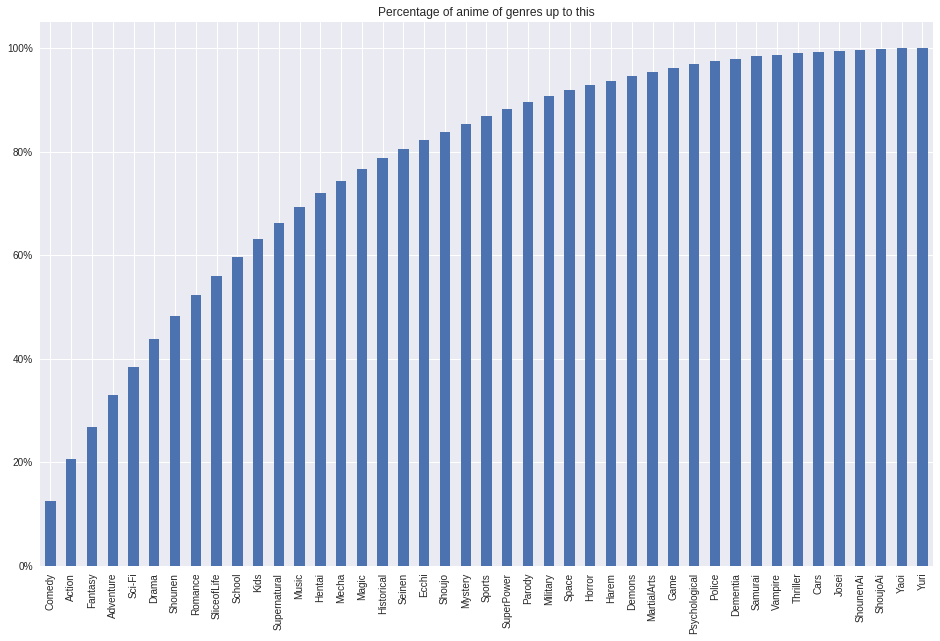

In [26]:
(genres / genres.sum()).cumsum().plot(kind='bar', figsize=(16, 10), title='Percentage of anime of genres up to this')
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 

In [27]:
(genres / genres.sum()).cumsum()

Comedy           0.125808
Action           0.205893
Fantasy          0.267985
Adventure        0.328950
Sci-Fi           0.383779
Drama            0.437233
Shounen          0.481499
Romance          0.523013
SliceofLife      0.559768
School           0.596055
Kids             0.630609
Supernatural     0.662549
Music            0.692454
Hentai           0.719002
Mecha            0.743019
Magic            0.765853
Historical       0.786927
Seinen           0.804451
Ecchi            0.821948
Shoujo           0.838427
Mystery          0.853944
Sports           0.868387
SuperPower       0.882033
Parody           0.894853
Military         0.907370
Space            0.917852
Horror           0.927508
Harem            0.936807
Demons           0.945776
MartialArts      0.953451
Game             0.960879
Psychological    0.968225
Police           0.973920
Dementia         0.979504
Samurai          0.983796
Vampire          0.987152
Thriller         0.989766
Cars             0.991994
Josei       

In [28]:
print('total percentage of some genres: ', (genres[['Yuri', 'Yaoi', 'ShounenAi', 'ShoujoAi']] / genres.sum()).sum())

total percentage of some genres:  0.005859858593083717


In [29]:
# now calculating for anime if they contain genre, so numbers will be higher and they won't sum to 1
animes_genres = animes['genres'].apply(lambda x: x.replace(' ', ''))
# can not use reverse isin, must use str.contains
genres_occurence = pd.Series({genre: (animes_genres.str.contains(genre)).sum() for genre in genres.index})
#animes_genres.str.contains('Yuri')

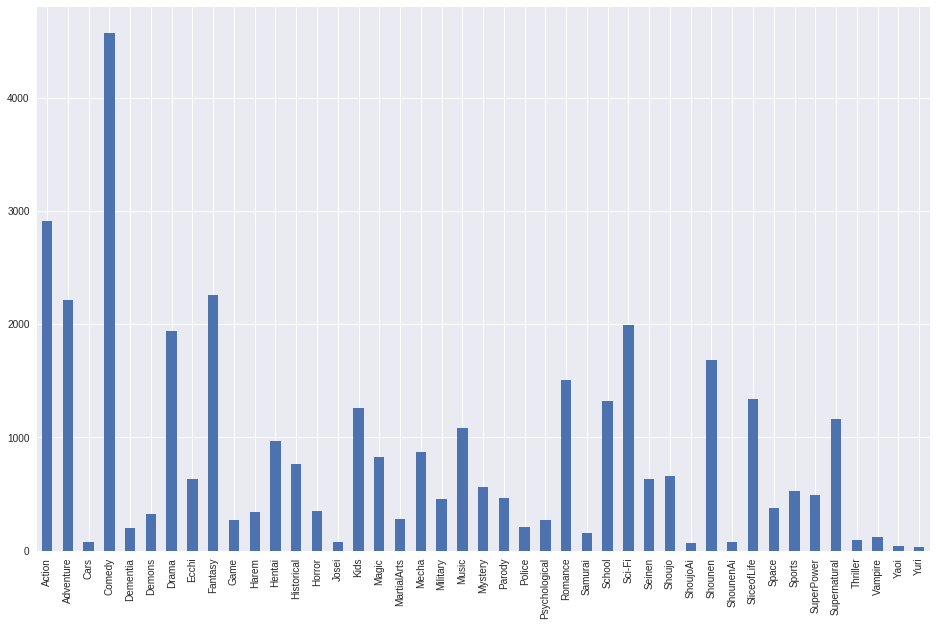

In [30]:
genres_occurence.plot(kind='bar', figsize=(16, 10))

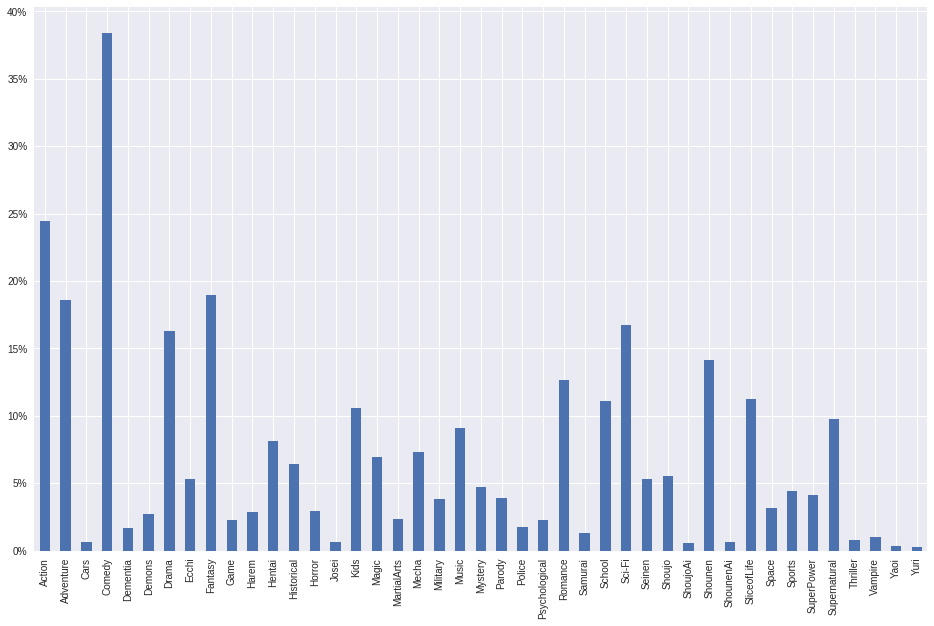

In [31]:
(genres_occurence / animes.shape[0]).plot(kind='bar', figsize=(16, 10))
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 

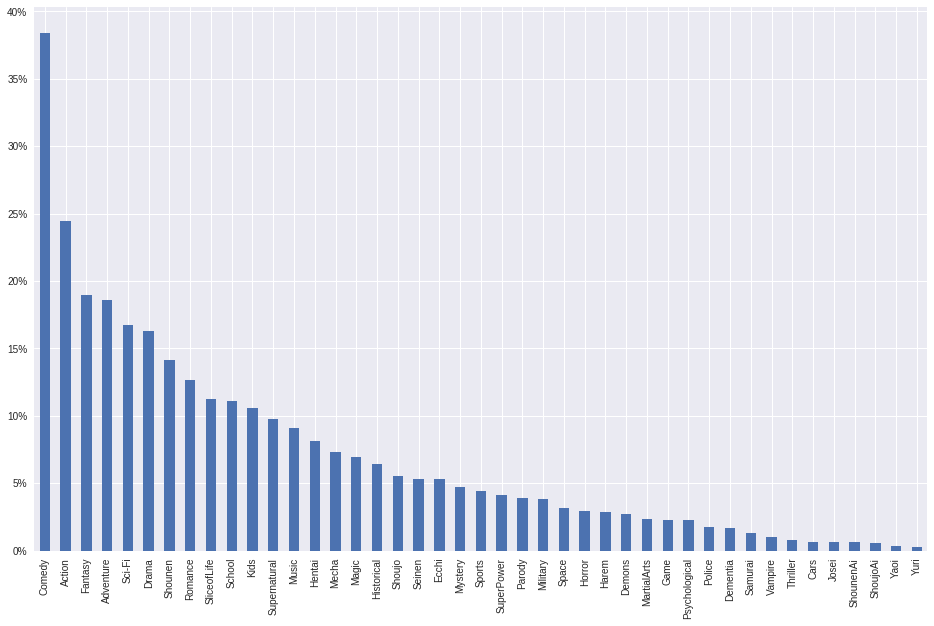

In [32]:
(genres_occurence / animes.shape[0]).sort_values(ascending=False).plot(kind='bar', figsize=(16, 10))
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 

In [33]:
print('total percentage of some genres: ', (genres_occurence[['Yuri', 'Yaoi', 'ShounenAi', 'ShoujoAi']] / animes.shape[0]).sum())
print('total percentage of some genres: ', (genres_occurence[['Yuri', 'Yaoi']] / animes.shape[0]).sum())

total percentage of some genres:  0.017887134699361772
total percentage of some genres:  0.005878401074907625


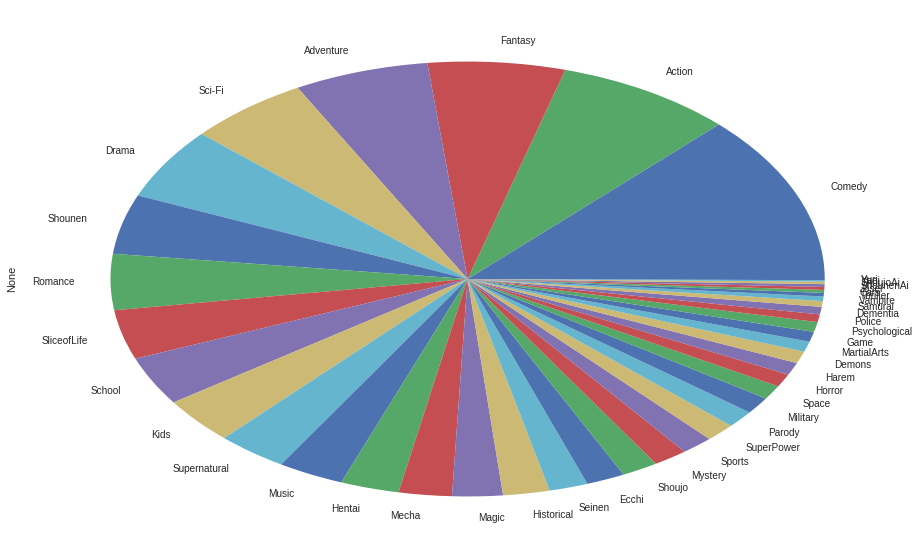

In [34]:
genres.plot.pie(figsize=(16, 10))

In [35]:
genres_years = pd.crosstab(animes['aired_from'].dt.year, animes['genres'])

In [36]:
display(animes['aired_from'].dt.year.describe())
years_diff = int(animes['aired_from'].dt.year.max() - animes['aired_from'].dt.year.min()) + 1
display(years_diff)
anime_aired_year = animes['aired_from'].dt.year.dropna().astype(np.int)

count    10859.000000
mean      2005.583571
std         12.875457
min       1917.000000
25%       2001.000000
50%       2010.000000
75%       2015.000000
max       2018.000000
Name: aired_from, dtype: float64

102

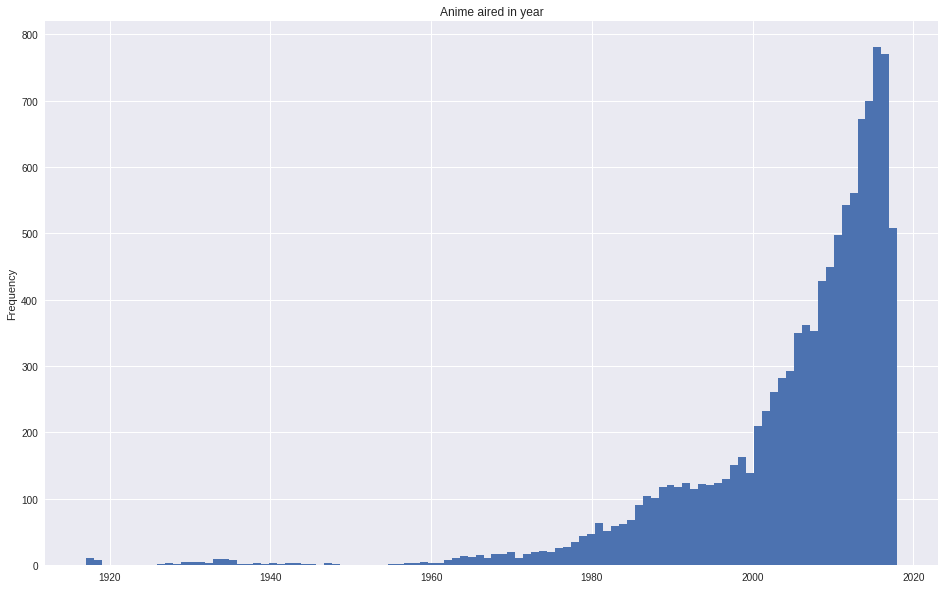

In [37]:
anime_aired_year.plot(kind='hist', bins=years_diff, figsize=(16, 10), title='Anime aired in year')

(2000, 2018)

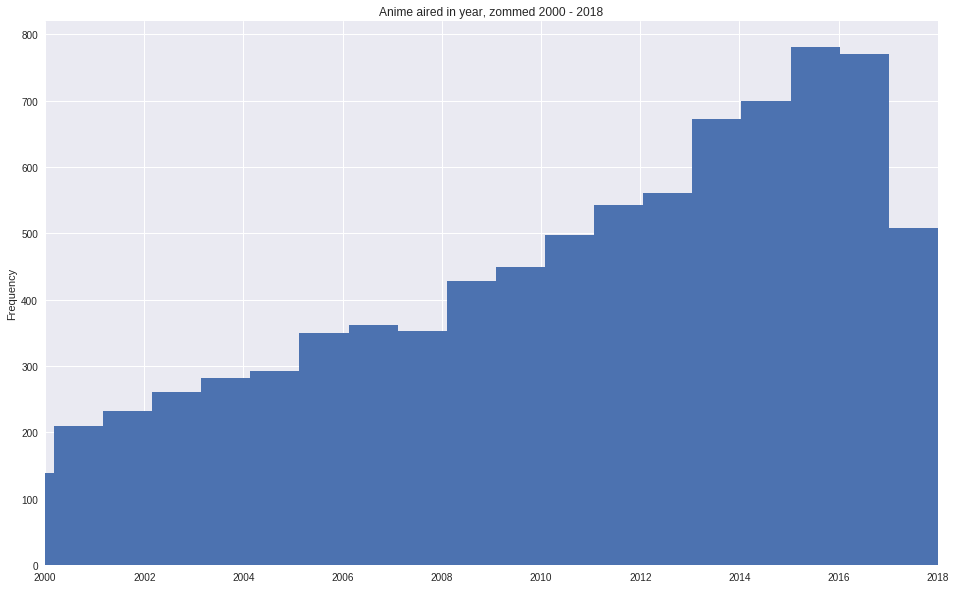

In [38]:
anime_aired_year.plot(kind='hist', bins=years_diff, figsize=(16, 10), title='Anime aired in year, zommed 2000 - 2018')
plt.gca().set_xlim([2000, 2018])

In [39]:
animes[animes['title'] == 'Usavich']['aired']

anime_id
3737    {'from': '2018-05-12', 'to': '2018-05-12'}
Name: aired, dtype: object

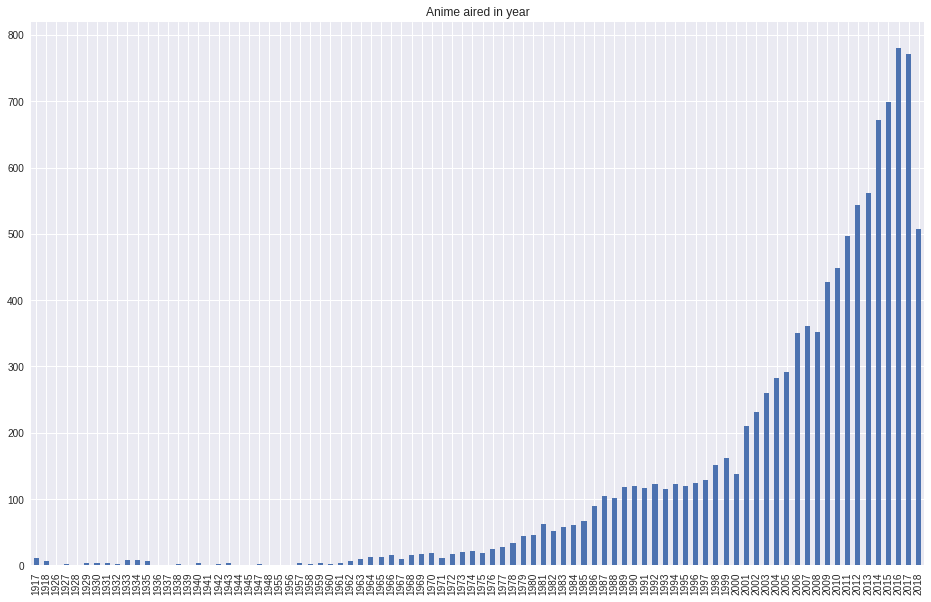

In [40]:
anime_aired_year.value_counts().sort_index().plot.bar(figsize=(16, 10), title='Anime aired in year')

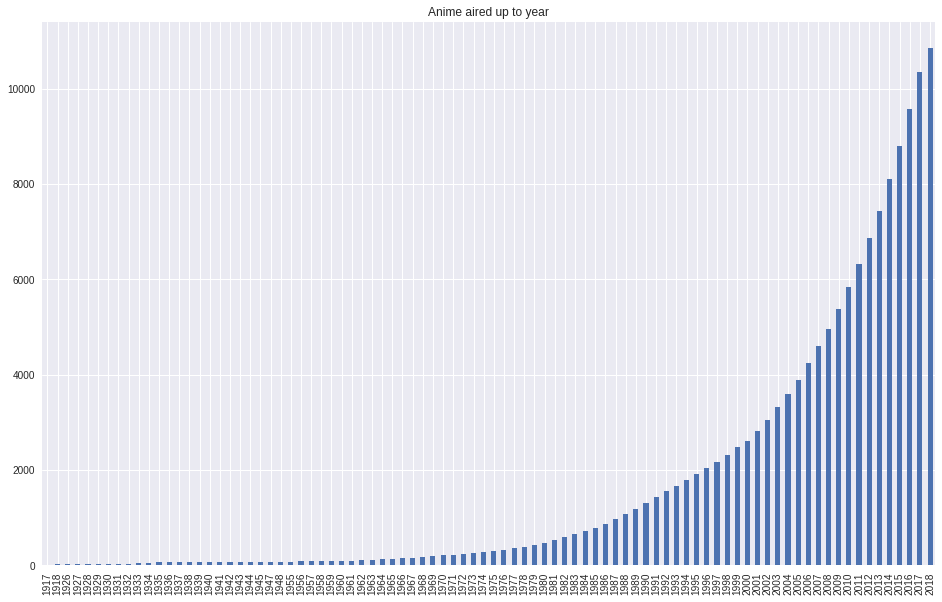

In [41]:
anime_aired_year.value_counts().sort_index().cumsum().plot.bar(figsize=(16, 10), title='Anime aired up to year')

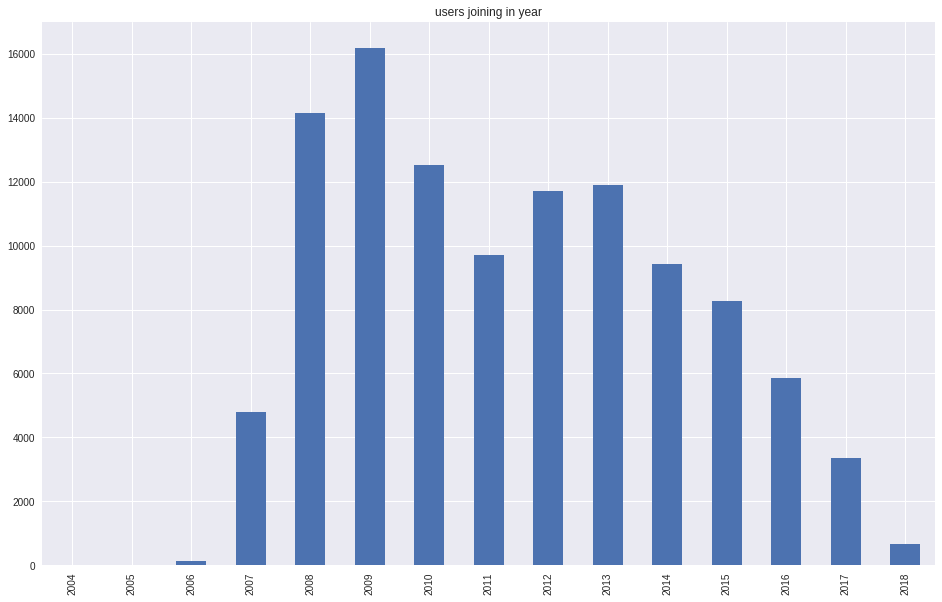

In [42]:
users['join_date'].dt.year.value_counts().sort_index().plot.bar(figsize=(16, 10), title='users joining in year')

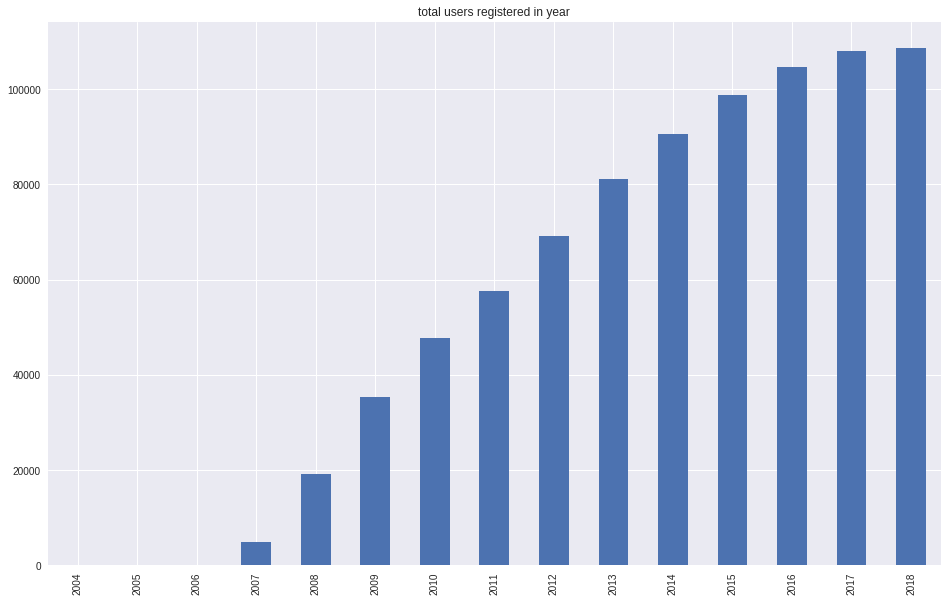

In [43]:
users['join_date'].dt.year.value_counts().sort_index().cumsum().plot.bar(figsize=(16, 10), title='total users registered in year')

In [44]:
# counting 0 score, which is not rated, drastically moves both mean and variance
users['rating_mean'] = animelists[animelists['my_score'] != 0].groupby('username')['my_score'].mean()
users['rating_var'] = animelists[animelists['my_score'] != 0].groupby('username')['my_score'].var()

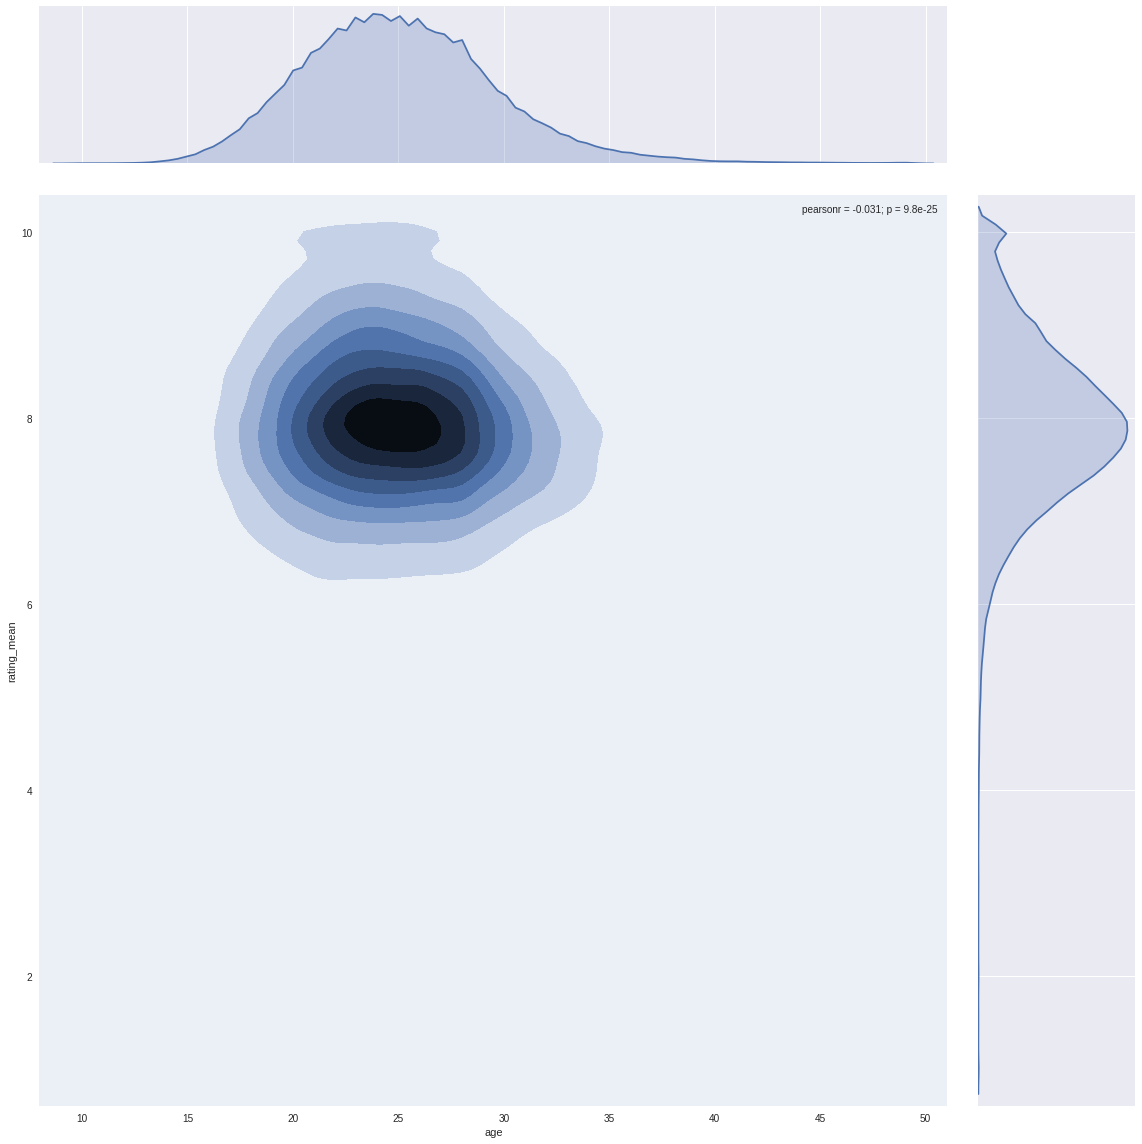

In [45]:
sns.jointplot(x='age', y='rating_mean', data=users, size=16, kind='kde')

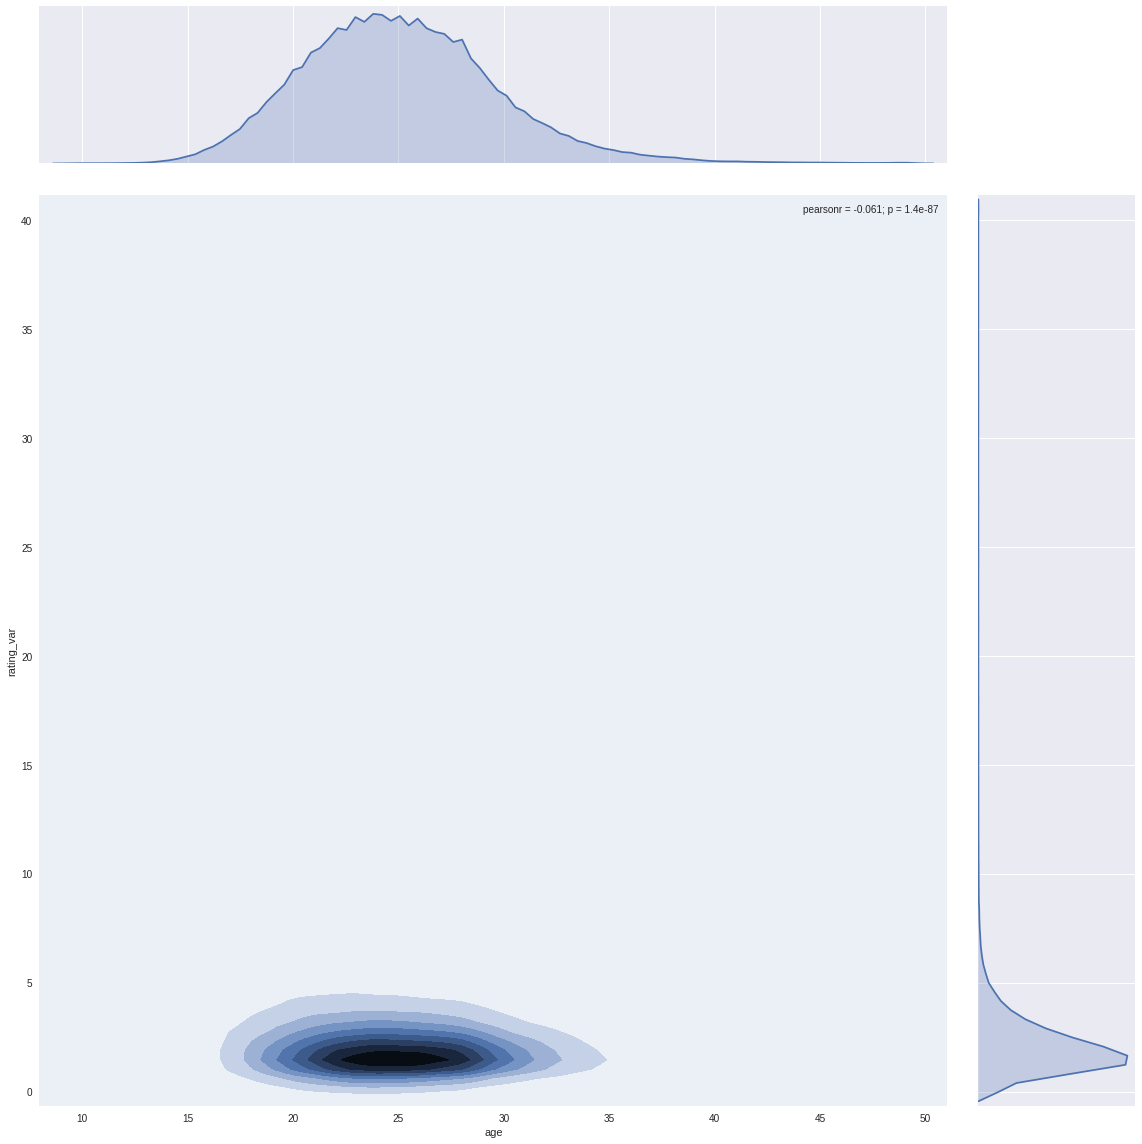

In [46]:
sns.jointplot(x='age', y='rating_var', data=users, size=16, kind='kde')

In [47]:
users['seen_anime'] = animelists.groupby('username')['anime_id'].count()

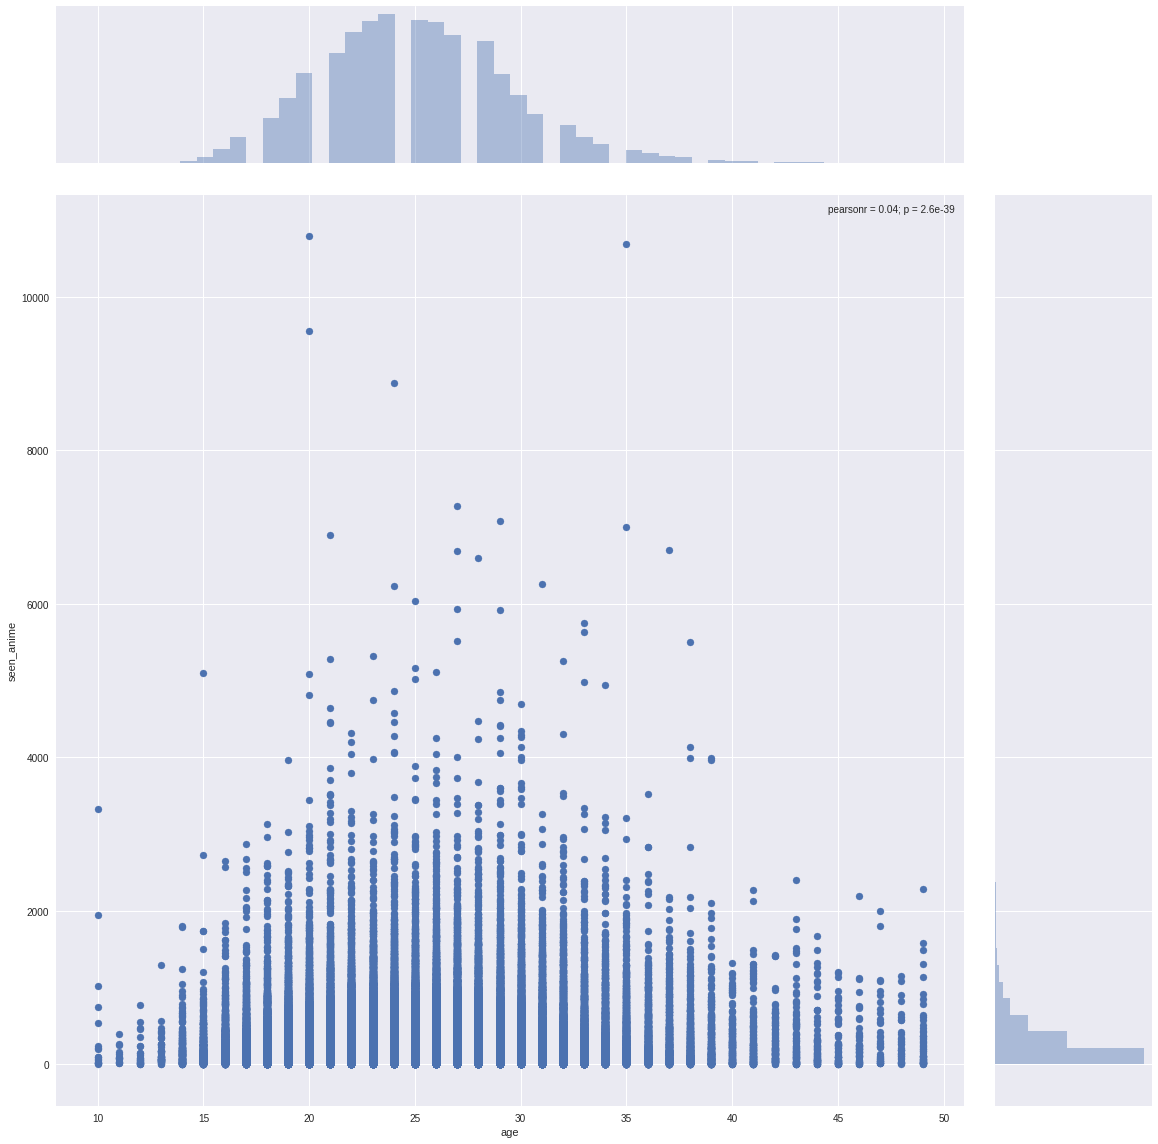

In [48]:
sns.jointplot(x='age', y='seen_anime', data=users, size=16)

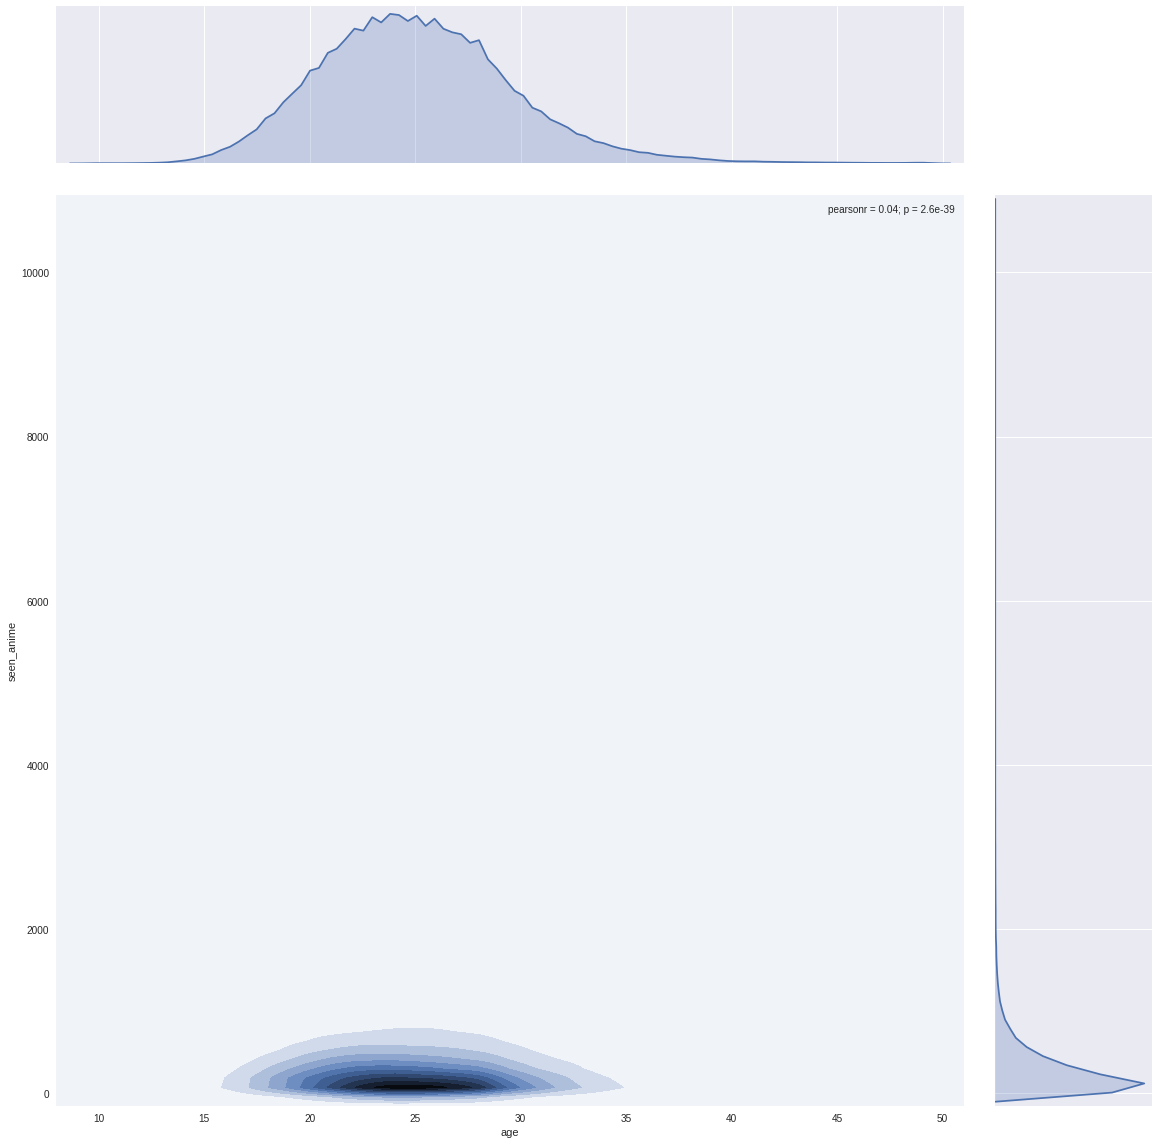

In [49]:
sns.jointplot(x='age', y='seen_anime', data=users, size=16, kind='kde')

In [50]:
users['days_on_mal'] = (users['last_online'] - users['join_date']) / np.timedelta64(1, 'D')

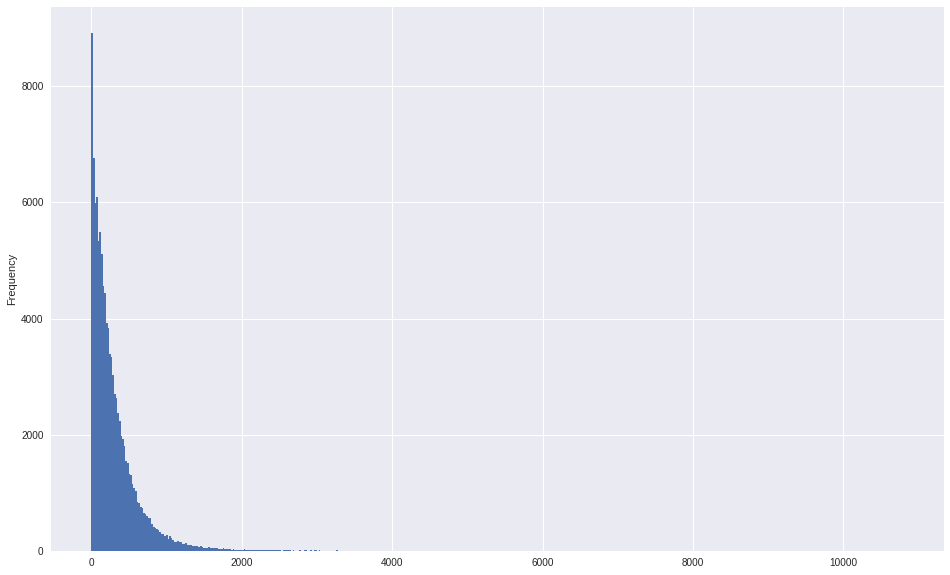

In [51]:
users['seen_anime'].plot(kind='hist', bins=500, figsize=(16, 10))

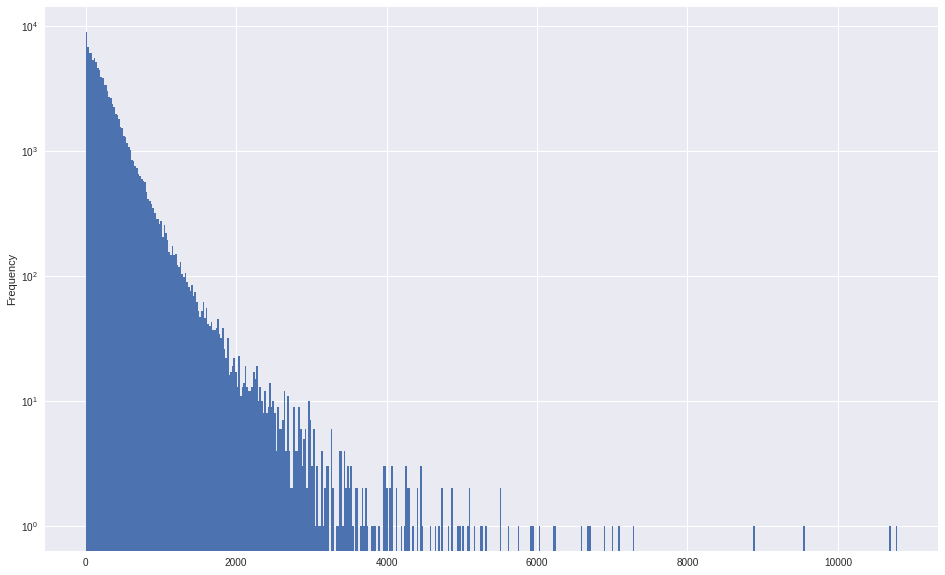

In [52]:
users['seen_anime'].plot(kind='hist', bins=500, figsize=(16, 10), logy=True)

In [53]:
users[users['days_on_mal'] > 4500][['user_id', 'join_date', 'last_online', 'days_on_mal']]

user_id  join_date         last_online  days_on_mal
username                                                        
Xinil              1 2004-11-05 2018-05-14 18:02:55  4938.752025
Achtor            82 2005-04-29 2018-05-13 11:11:00  4762.465972
vondur            20 2005-01-05 2018-02-28 17:27:29  4802.727419
Crystal            4 2004-11-13 2018-05-14 13:04:48  4930.545000
Baman             36 2005-02-05 2018-05-20 04:57:26  4852.206551
Arinohyoshi      208 2005-01-30 2017-10-09 18:32:43  4635.772720

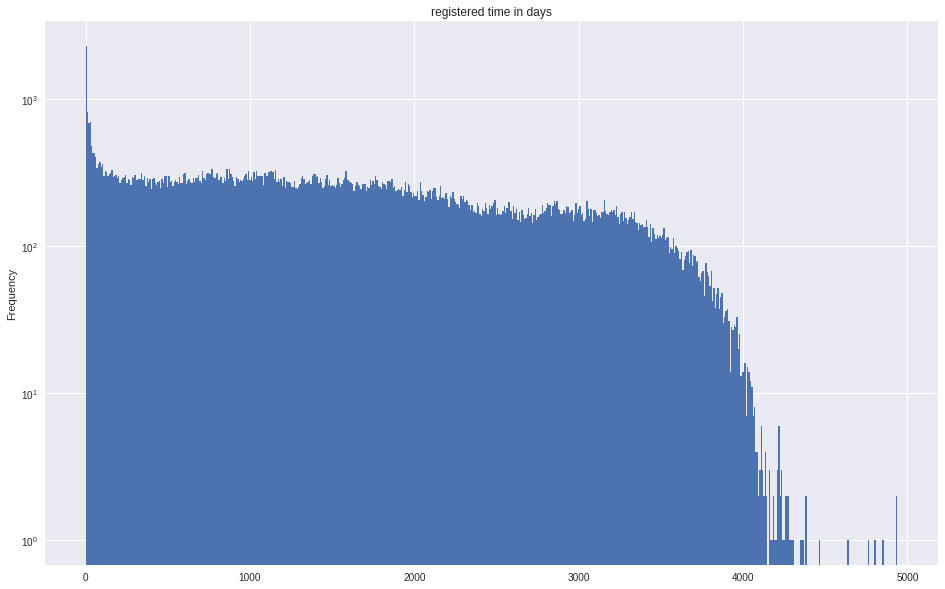

In [54]:
users['days_on_mal'].plot(kind='hist', logy=True, bins=600, figsize=(16, 10), title='registered time in days')

In [55]:
users[users['seen_anime'] > 5000]['seen_anime'].value_counts()

6698     1
5936     1
7079     1
10694    1
5255     1
6685     1
5514     1
6603     1
5324     1
5921     1
6996     1
6231     1
6042     1
6256     1
5089     1
10790    1
5287     1
9559     1
5099     1
7280     1
5168     1
6897     1
8884     1
5749     1
5114     1
5628     1
5018     1
5504     1
Name: seen_anime, dtype: int64

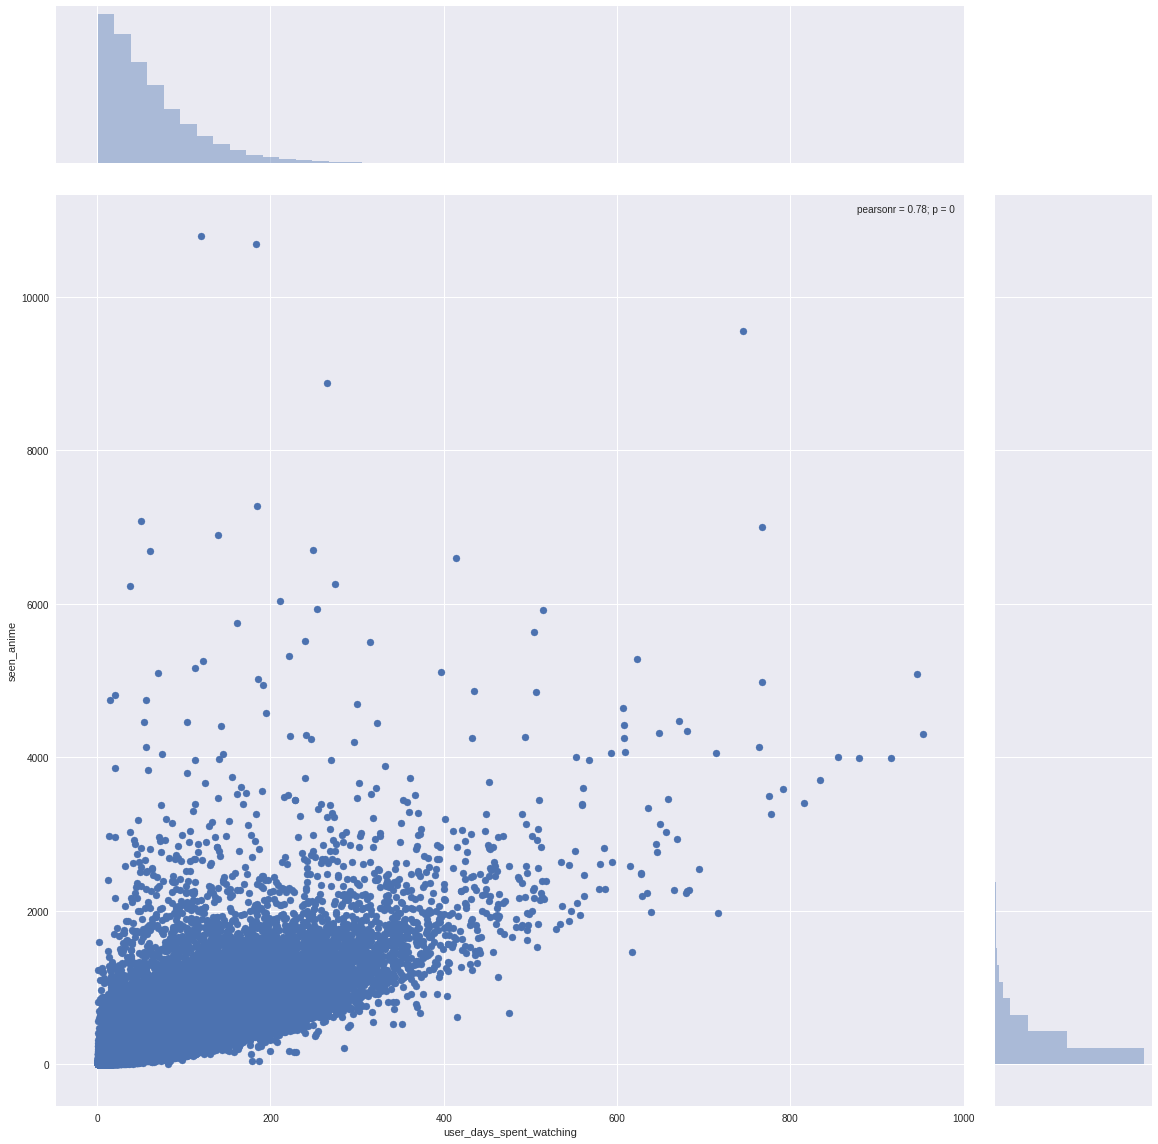

In [56]:
sns.jointplot(x='user_days_spent_watching', y='seen_anime', data=users, size=16)

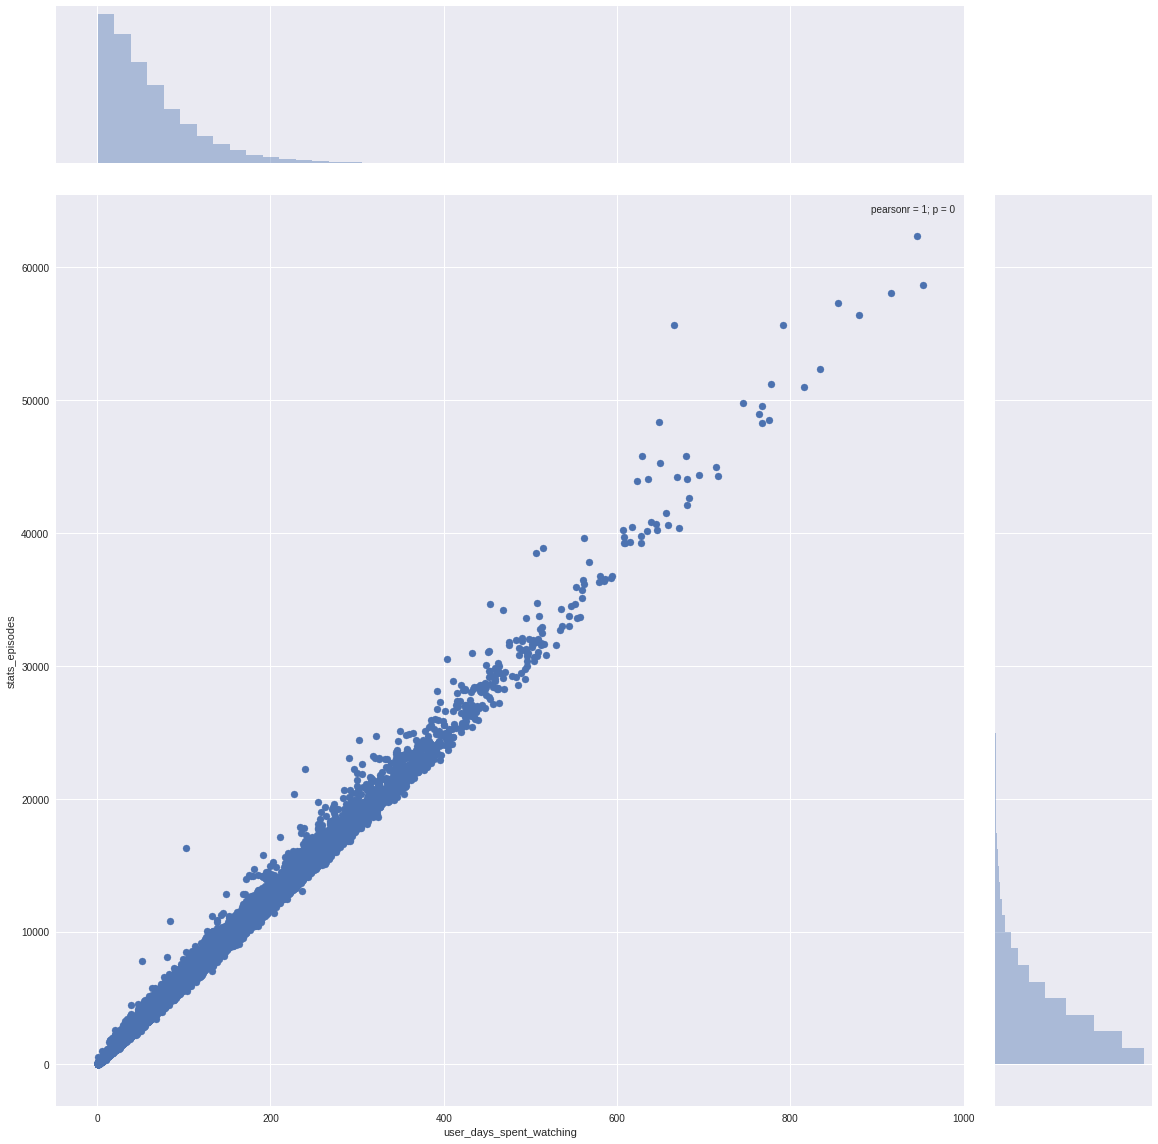

In [57]:
sns.jointplot(x='user_days_spent_watching', y='stats_episodes', data=users, size=16)

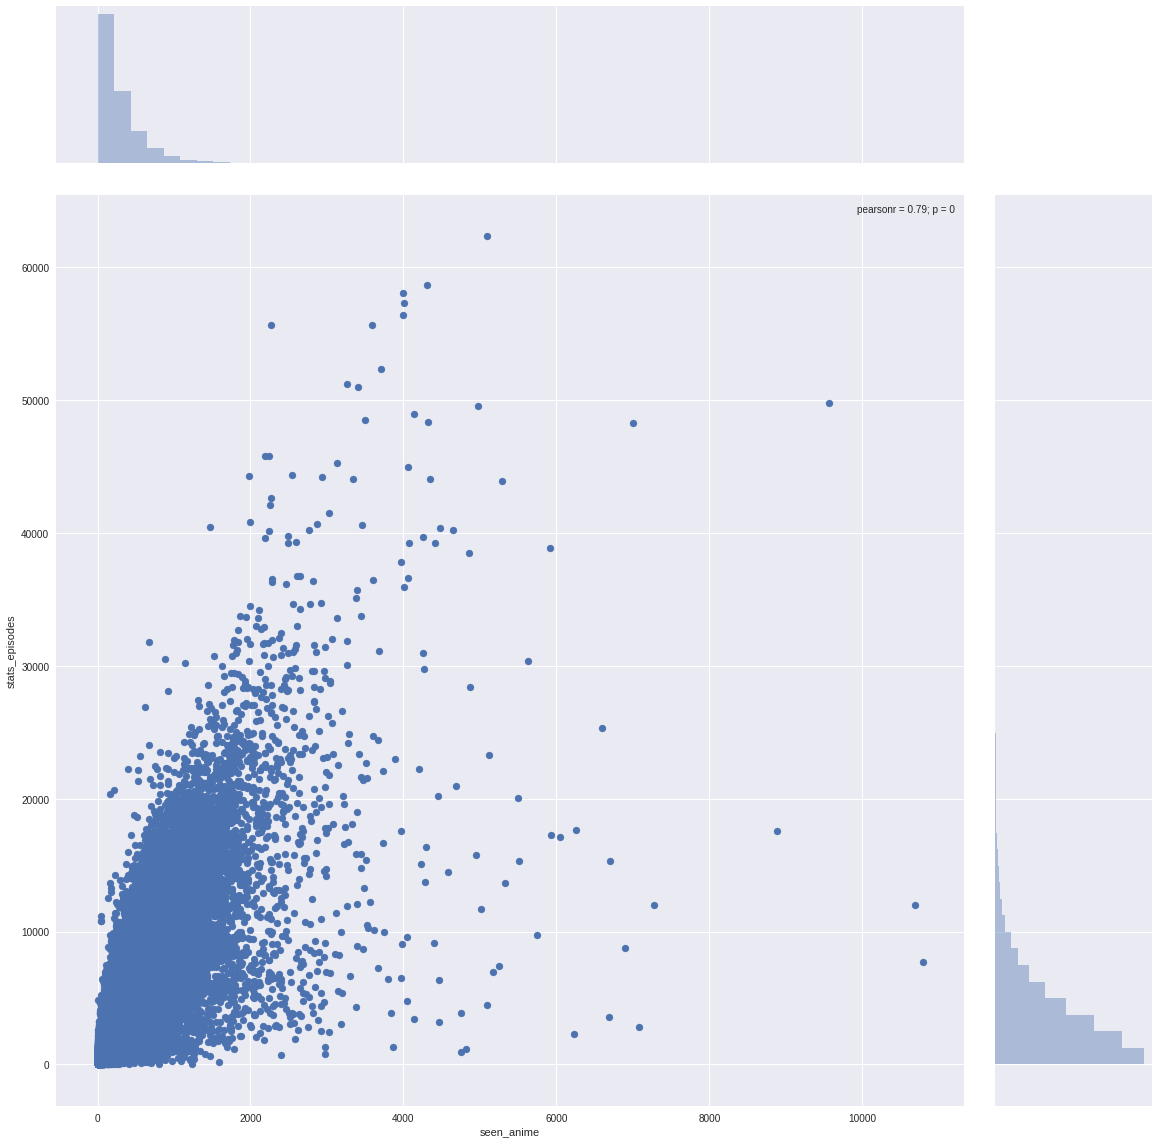

In [58]:
sns.jointplot(x='seen_anime', y='stats_episodes', data=users, size=16)

In [59]:
users.columns

Index(['user_id', 'user_watching', 'user_completed', 'user_onhold',
       'user_dropped', 'user_plantowatch', 'user_days_spent_watching',
       'gender', 'location', 'birth_date', 'access_rank', 'join_date',
       'last_online', 'stats_mean_score', 'stats_rewatched', 'stats_episodes',
       'age', 'rating_mean', 'rating_var', 'seen_anime', 'days_on_mal'],
      dtype='object')

In [60]:
users['rating_mean'].isnull().sum()

2298

In [61]:
users['rating_mean'].fillna(0, inplace=True)
users['rating_var'].fillna(0, inplace=True)

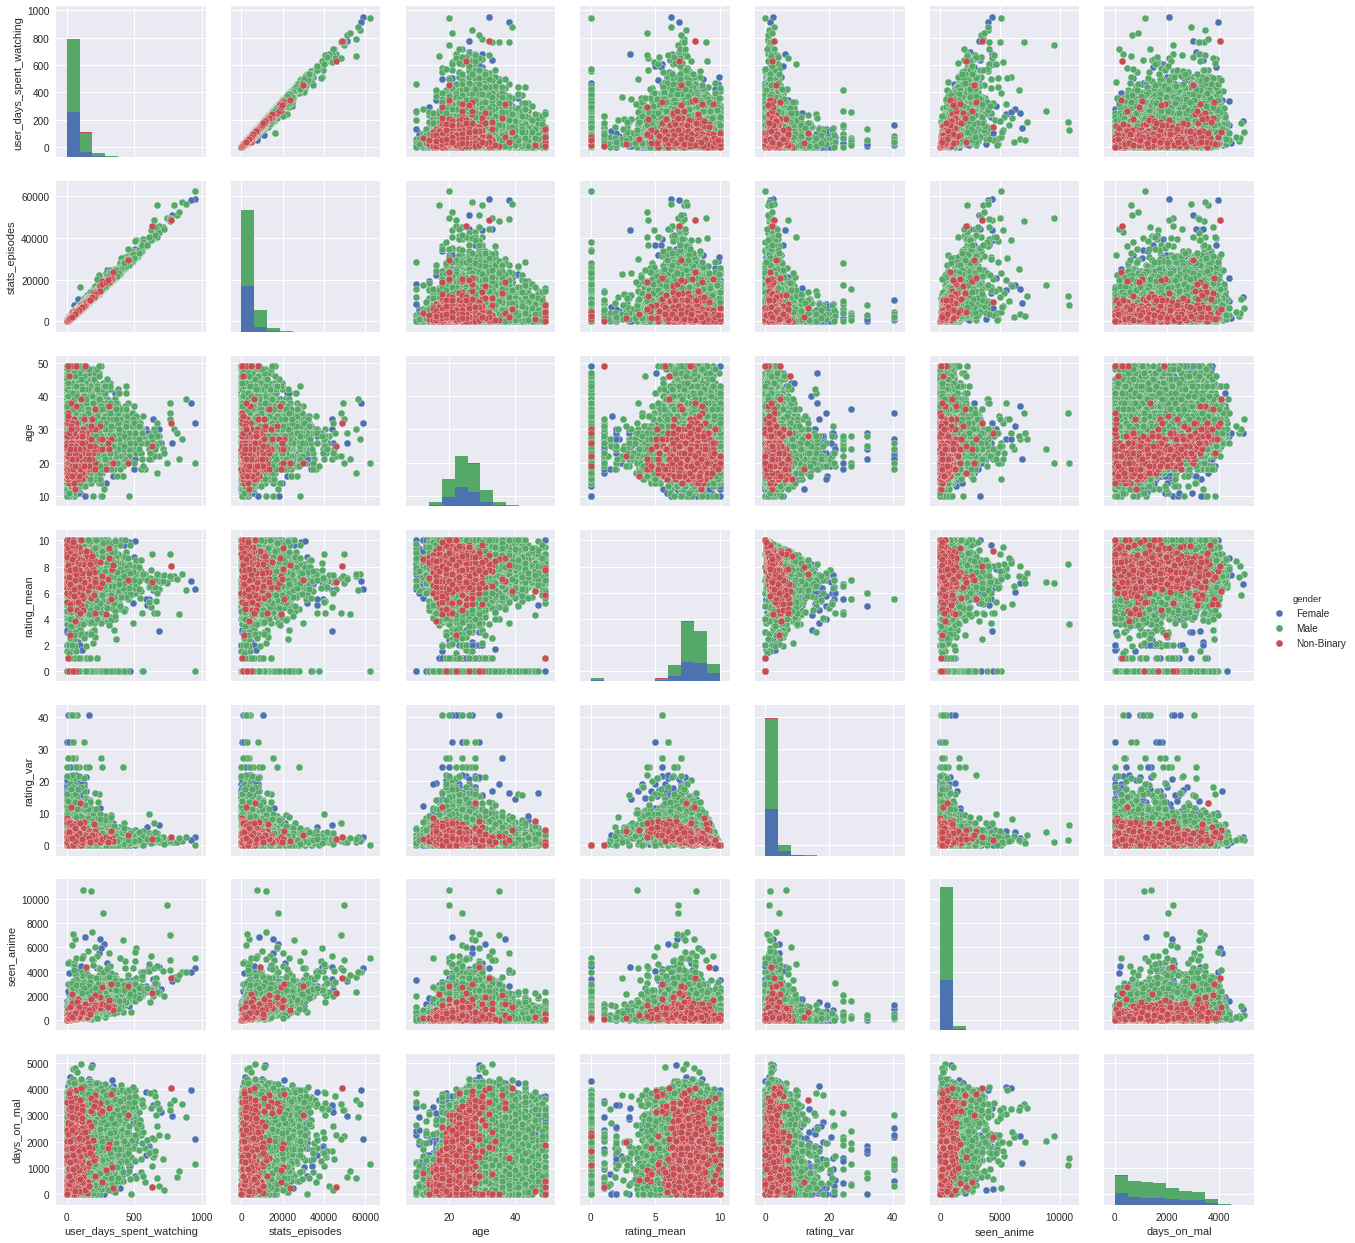

In [62]:
sns.pairplot(users[['user_days_spent_watching',
       'gender', 'birth_date', 'join_date',
       'last_online', 'stats_episodes',
       'age', 'rating_mean', 'rating_var', 'seen_anime',
       'days_on_mal']], hue='gender')

### inspecting anime age ratings

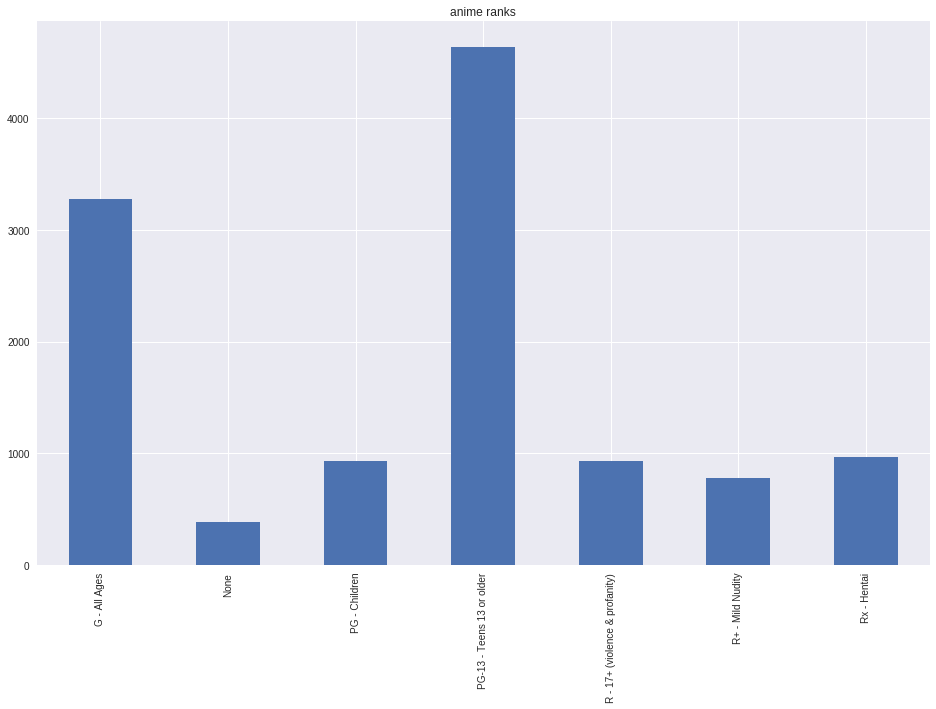

In [63]:
animes['rating'].value_counts().sort_index().plot.bar(figsize=(16, 10), title='anime ranks')

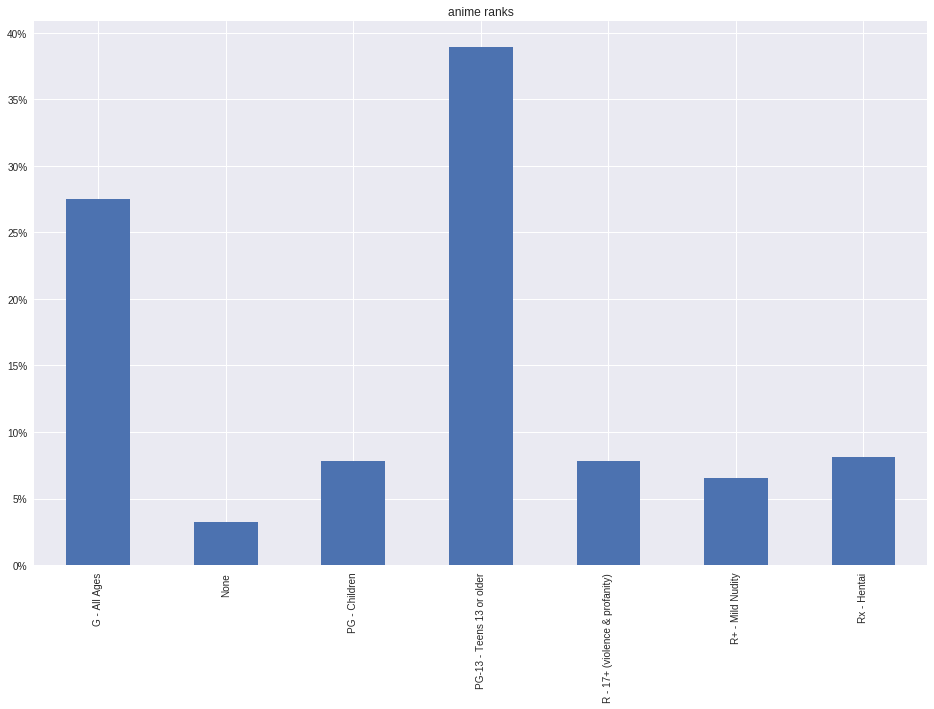

In [64]:
(animes['rating'].value_counts() / animes.shape[0]).sort_index().plot.bar(figsize=(16, 10), title='anime ranks')
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 

### inspecting anime sources

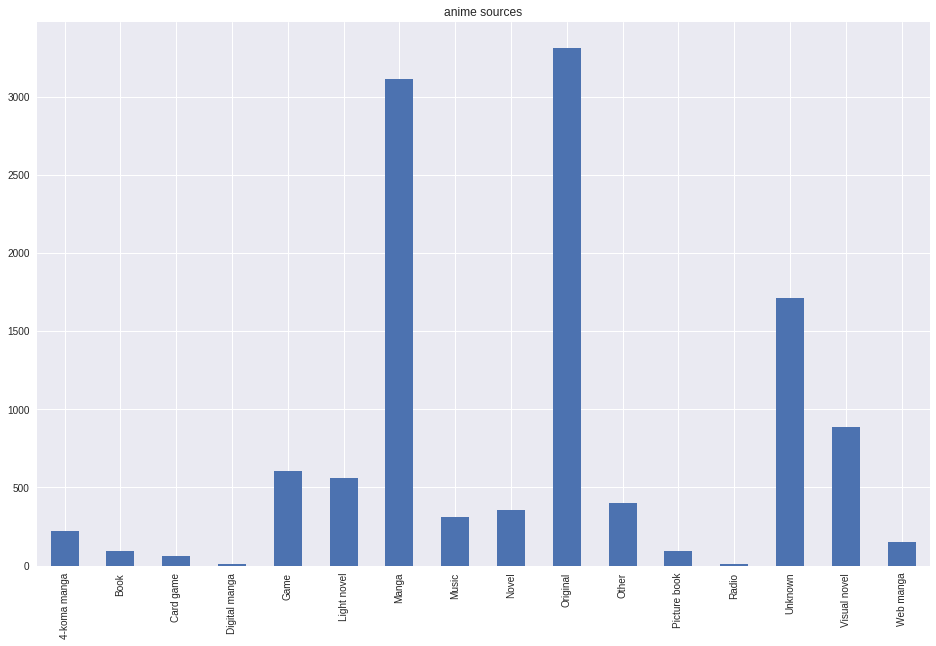

In [65]:
animes['source'].value_counts().sort_index().plot.bar(figsize=(16, 10), title='anime sources')

In [66]:
year_source = pd.crosstab(animes['aired_from'].dt.year, animes['source'])
year_source.index = year_source.index.astype(np.int)
# keeping only interesting sources
interesting_sources = ['Game', 'Light novel', 'Manga', 'Original', 'Visual novel']
other_sources = list(set(year_source.columns) - set(interesting_sources))
year_source['other'] = year_source[other_sources].sum(axis=1)
year_source = year_source.drop(other_sources, axis=1)
colors = plt.cm.Set1(np.linspace(0, 1, year_source.shape[1]))

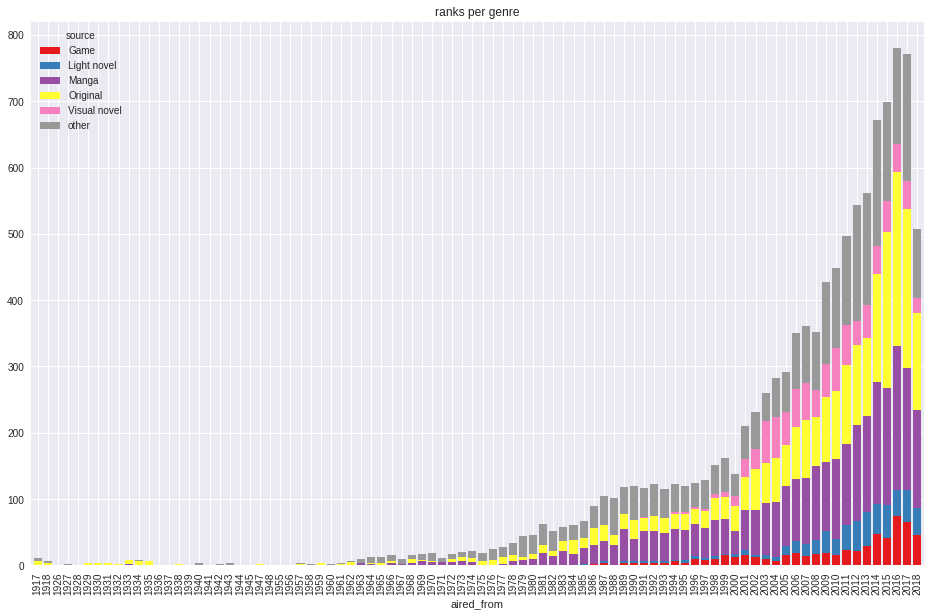

In [67]:
year_source.plot(kind='bar', stacked=True, figsize=(16, 10), title='ranks per genre', color=colors, width=0.8)

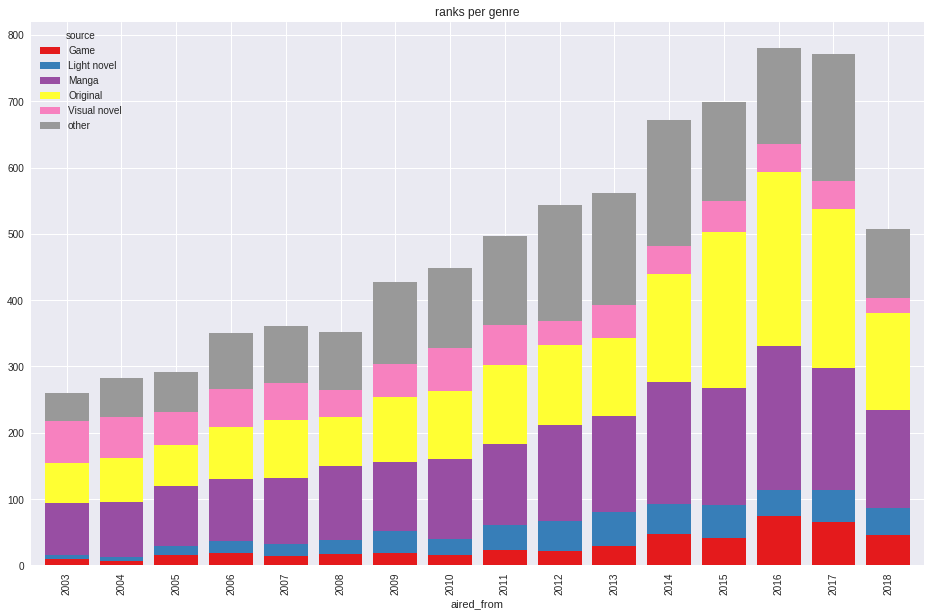

In [68]:
year_source[year_source.index >= 2003].plot(kind='bar', stacked=True, figsize=(16, 10), title='ranks per genre', color=colors, width=0.8)

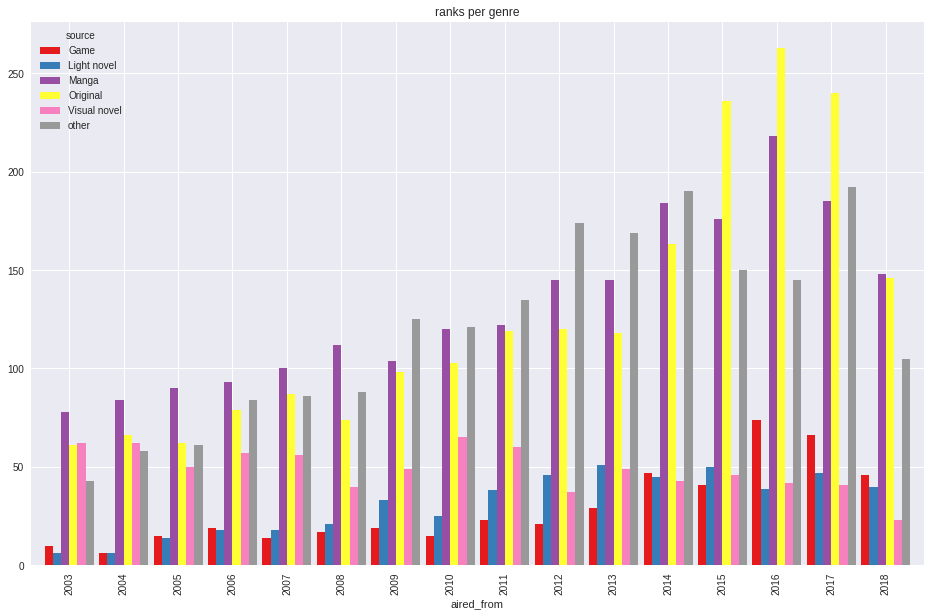

In [69]:
year_source[year_source.index >= 2003].plot(kind='bar', stacked=False, figsize=(16, 10), title='ranks per genre', color=colors, width=0.9)

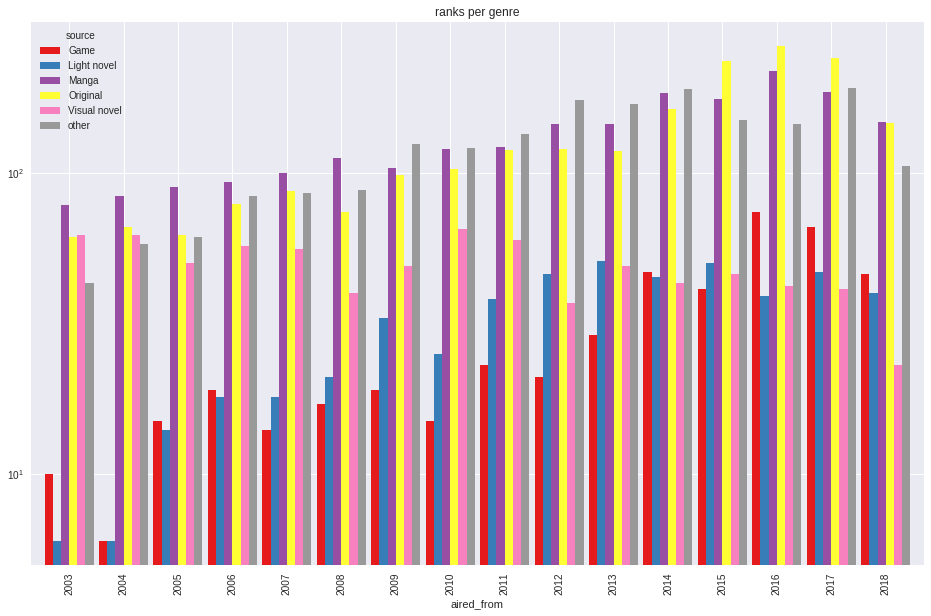

In [70]:
year_source[year_source.index >= 2003].plot(kind='bar', stacked=False, figsize=(16, 10), title='ranks per genre', color=colors, width=0.9, logy=True)

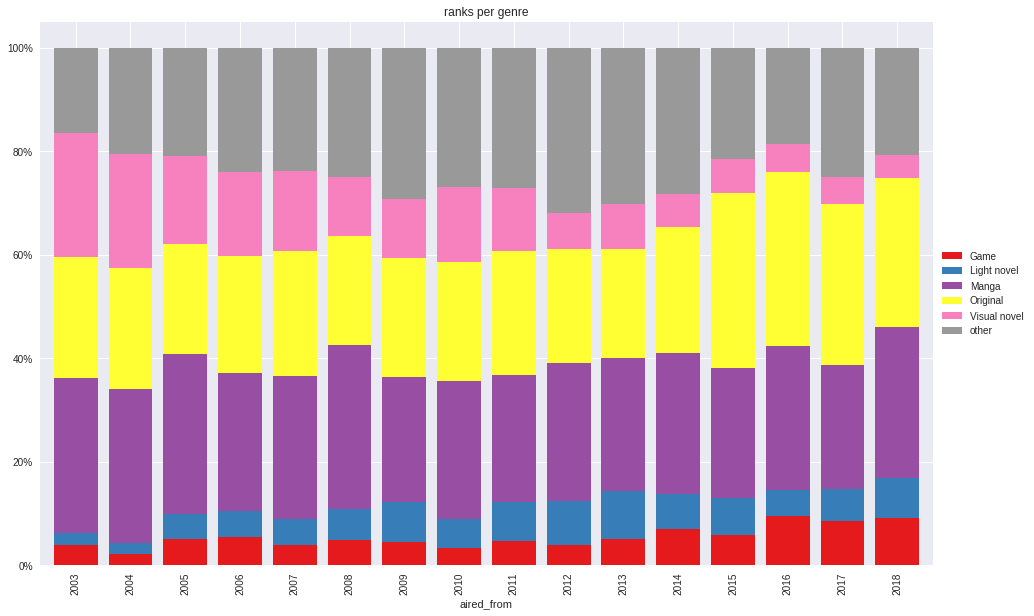

In [71]:
year_source.div(year_source.sum(axis=1), axis=0)[year_source.index >= 2003].plot(kind='bar', stacked=True, figsize=(16, 10), title='ranks per genre', color=colors, width=0.8)
plt.gca().legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 

In [72]:
animes[animes['source'] == 'Unknown'].sort_values(by='popularity')[['title', 'source', 'studios', 'genres', 'popularity']]

title   source  \
anime_id                                                               
10805               Kami nomi zo Shiru Sekai: 4-nin to Idol  Unknown   
6127                                        Toradora!: SOS!  Unknown   
5764      Zero no Tsukaima: Princesses no Rondo - Yuuwak...  Unknown   
10647                                Ao no Exorcist: Ura Ex  Unknown   
20939     Ore no Nounai Sentakushi ga, Gakuen Love Comed...  Unknown   
4938                                     Tsubasa: Shunraiki  Unknown   
6864                                           xxxHOLiC Rou  Unknown   
192       Love Hina Haru Special: Kimi Sakura Chiru Naka...  Unknown   
9675                       Kami nomi zo Shiru Sekai: Flag 0  Unknown   
10152                   Kimi ni Todoke 2nd Season: Kataomoi  Unknown   
4134        Naruto Shippuuden: Shippuu! "Konoha Gakuen" Den  Unknown   
15487                              Kuroko no Basket NG-shuu  Unknown   
23701                                       Toradora! Recap  Unknown   
3791                                       Air Gear Special  Unknown   
21879     Sword Art Online: Sword Art Offline - Extra Ed...  Unknown   
3759                            School Days: Valentine Days  Unknown   
5955                             Toaru Majutsu no Index-tan  Unknown   
9117                                         Amagami SS OVA  Unknown   
20903                                              Harmonie  Unknown   
807        Tsubasa Chronicle: Tori Kago no Kuni no Himegimi  Unknown   
9925                Amagami SS: Tachibana Miya-hen - Imouto  Unknown   
3956                 Shakugan no Shana II (Second) Specials  Unknown   
7870                    Baka to Test to Shoukanjuu Specials  Unknown   
19669              Kuroko no Basket: Baka ja Katenai no yo!  Unknown   
35946       Nanatsu no Taizai Movie: Tenkuu no Torawarebito  Unknown   
763                                                   Zoids  Unknown   
10172                                     Freezing Specials  Unknown   
3328                 School Days: Magical Heart Kokoro-chan  Unknown   
7805      Baka to Test to Shoukanjuu: Mondai - Christmas...  Unknown   
8465                     Ichiban Ushiro no Daimaou Specials  Unknown   
...                                                     ...      ...   
27841                    Karasu no Panya-san/Dorobou Gakkou  Unknown   
30929             Aladdin to Mahou no Lamp no Koutsuu Anzen  Unknown   
26093                                Tanbai Haru, Tookaraji  Unknown   
27921                          Genkichi Jiisan to Kogitsune  Unknown   
26109                                 Kokoro no Koukyougaku  Unknown   
28113                                        Ooi! Adacchii!  Unknown   
26095                                 Kono Sora no Shita de  Unknown   
27849                                  Nezumi-kun no Chokki  Unknown   
35513                                 MAFF x Chobitto Zukan  Unknown   
26105                                    Gomen ne, Mii-chan  Unknown   
24803                                      Tobidasu Ehon 3D  Unknown   
26107                                           Miitsuketa!  Unknown   
26103                         Namae... Sore wa Moeru Inochi  Unknown   
27845                                      Juupiki no Kaeru  Unknown   
26113                                              Yooidon!  Unknown   
30530                       Fuusen Shoujo Temple-chan Movie  Unknown   
26139                   Kie Saranu Kizuato: Hi no Umi Osaka  Unknown   
27847     Kyoushitsu wa Obake ga Ippai/Boku wa Yuusha da zo  Unknown   
30409                                           Nepos Napos  Unknown   
31465                              Pichiko Dakyuubu USA-hen  Unknown   
31464                                      Pichiko Dakyuubu  Unknown   
30933                Son Gokuu no Koutsuu Rule Shugyou Chuu  Unknown   
27853                                        Ichinen Ikkumi  Unknown   
30932            Oz no

In [73]:
animes[(animes['source'] == 'Unknown') & (animes['studios'].isnull())].shape

(0, 32)

In [74]:
# here, in animes_genres, is every anime duplicated, once per each genre it contains
genres_arr = animes['genres'].apply(lambda x: x.replace(' ', '').split(',')).apply(pd.Series).stack().to_frame(name='genre')
genres_arr.index.levels[0].name = 'anime_id'
animes_genres = pd.merge(animes, genres_arr, how='left', left_index=True, right_index=True)

In [75]:
genres_arr

genre
anime_id                
11013    0        Comedy
         1  Supernatural
         2       Romance
         3       Shounen
2104     0        Comedy
         1        Parody
         2       Romance
         3        School
         4       Shounen
5262     0        Comedy
         1         Magic
         2        School
         3        Shoujo
721      0        Comedy
         1         Drama
         2         Magic
         3       Romance
         4       Fantasy
12365    0        Comedy
         1         Drama
         2       Romance
         3       Shounen
6586     0          Kids
         1        School
         2        Shoujo
178      0         Magic
         1        Comedy
         2       Romance
         3        School
         4        Shoujo
...                  ...
30931    2          Kids
35130    0          Kids
         1         Drama
33823    0         Drama
         1    Historical
37535    0   SliceofLife
34237    0        Sci-Fi
30928    0         Drama
         1          Kids
37463    0          Kids
         1         Music
37787    0     Adventure
         1         Space
35229    0          Kids
36640    0          Game
         1         Magic
35085    0         Drama
         1          Kids
35152    0          Kids
27853    0          Kids
         1        School
36315    0          Kids
35040    0          Kids
37897    0        Action
         1        Sci-Fi
         2     Adventure
         3       Fantasy
34193    0       Fantasy
         1          Kids
37908    0        Comedy

[36383 rows x 1 columns]

In [76]:
animes.head()

title              title_english title_japanese  \
anime_id                                                                  
11013           Inu x Boku SS  Inu X Boku Secret Service         妖狐×僕SS   
2104         Seto no Hanayome      My Bride is a Mermaid          瀬戸の花嫁   
5262       Shugo Chara!! Doki         Shugo Chara!! Doki    しゅごキャラ！！どきっ   
721             Princess Tutu              Princess Tutu      プリンセスチュチュ   
12365     Bakuman. 3rd Season                   Bakuman.          バクマン。   

                                         title_synonyms  \
anime_id                                                  
11013                                   Youko x Boku SS   
2104                               The Inland Sea Bride   
5262      Shugo Chara Ninenme, Shugo Chara! Second Year   
721                                                 NaN   
12365                                  Bakuman Season 3   

                                                  image_url type    source  \
anime_id                                                                     
11013     https://myanimelist.cdn-dena.com/images/anime/...   TV     Manga   
2104      https://myanimelist.cdn-dena.com/images/anime/...   TV     Manga   
5262      https://myanimelist.cdn-dena.com/images/anime/...   TV     Manga   
721       https://myanimelist.cdn-dena.com/images/anime/...   TV  Original   
12365     https://myanimelist.cdn-dena.com/images/anime/...   TV     Manga   

          episodes           status  airing     ...               broadcast  \
anime_id                                        ...                           
11013           12  Finished Airing   False     ...      Fridays at Unknown   
2104            26  Finished Airing   False     ...                 Unknown   
5262            51  Finished Airing   False     ...                 Unknown   
721             38  Finished Airing   False     ...      Fridays at Unknown   
12365           25  Finished Airing   False     ...                 Unknown   

                                                    related  \
anime_id                                                      
11013     {'Adaptation': [{'mal_id': 17207, 'type': 'man...   
2104      {'Adaptation': [{'mal_id': 759, 'type': 'manga...   
5262      {'Adaptation': [{'mal_id': 101, 'type': 'manga...   
721       {'Adaptation': [{'mal_id': 1581, 'type': 'mang...   
12365     {'Adaptation': [{'mal_id': 9711, 'type': 'mang...   

                                                   producer          licensor  \
anime_id                                                                        
11013     Aniplex, Square Enix, Mainichi Broadcasting Sy...  Sentai Filmworks   
2104                      TV Tokyo, AIC, Square Enix, Sotsu        Funimation   
5262                                        TV Tokyo, Sotsu               NaN   
721                      Memory-Tech, GANSIS, Marvelous AQL         ADV Films   
12365                                         NHK, Shueisha               NaN   

                   studios                                    genres  \
anime_id                                                               
11013     David Production    Comedy, Supernatural, Romance, Shounen   
2104                 Gonzo  Comedy, Parody, Romance, School, Shounen   
5262             Satelight             Comedy, Magic, School, Shoujo   
721         Hal Film Maker    Comedy, Drama, Magic, Romance, Fantasy   
12365            J.C.Staff           Comedy, Drama, Romance, Shounen   

                                              opening_theme  \
anime_id                                                      
11013                                 ['"Nirvana" by MUCC']   
2104                     ['"Romantic summer" by SUN&LUNAR']   
5262      ['#1: "Minna no Tamago (みんなのたまご)" by Shugo Cha...   
721                  ['"Morning Grace" by Ritsuko Okazaki']   
12365     ['#1: "Moshimo no Hanashi (もしもの話)" by nano.RIP...   

                          

In [77]:
animes_genres.head()

title              title_english title_japanese  \
anime_id                                                                 
11013    0     Inu x Boku SS  Inu X Boku Secret Service         妖狐×僕SS   
         1     Inu x Boku SS  Inu X Boku Secret Service         妖狐×僕SS   
         2     Inu x Boku SS  Inu X Boku Secret Service         妖狐×僕SS   
         3     Inu x Boku SS  Inu X Boku Secret Service         妖狐×僕SS   
2104     0  Seto no Hanayome      My Bride is a Mermaid          瀬戸の花嫁   

                  title_synonyms  \
anime_id                           
11013    0       Youko x Boku SS   
         1       Youko x Boku SS   
         2       Youko x Boku SS   
         3       Youko x Boku SS   
2104     0  The Inland Sea Bride   

                                                    image_url type source  \
anime_id                                                                    
11013    0  https://myanimelist.cdn-dena.com/images/anime/...   TV  Manga   
         1  https://myanimelist.cdn-dena.com/images/anime/...   TV  Manga   
         2  https://myanimelist.cdn-dena.com/images/anime/...   TV  Manga   
         3  https://myanimelist.cdn-dena.com/images/anime/...   TV  Manga   
2104     0  https://myanimelist.cdn-dena.com/images/anime/...   TV  Manga   

            episodes           status  airing      ...       \
anime_id                                           ...        
11013    0        12  Finished Airing   False      ...        
         1        12  Finished Airing   False      ...        
         2        12  Finished Airing   False      ...        
         3        12  Finished Airing   False      ...        
2104     0        26  Finished Airing   False      ...        

                                                      related  \
anime_id                                                        
11013    0  {'Adaptation': [{'mal_id': 17207, 'type': 'man...   
         1  {'Adaptation': [{'mal_id': 17207, 'type': 'man...   
         2  {'Adaptation': [{'mal_id': 17207, 'type': 'man...   
         3  {'Adaptation': [{'mal_id': 17207, 'type': 'man...   
2104     0  {'Adaptation': [{'mal_id': 759, 'type': 'manga...   

                                                     producer  \
anime_id                                                        
11013    0  Aniplex, Square Enix, Mainichi Broadcasting Sy...   
         1  Aniplex, Square Enix, Mainichi Broadcasting Sy...   
         2  Aniplex, Square Enix, Mainichi Broadcasting Sy...   
         3  Aniplex, Square Enix, Mainichi Broadcasting Sy...   
2104     0                  TV Tokyo, AIC, Square Enix, Sotsu   

                    licensor           studios  \
anime_id                                         
11013    0  Sentai Filmworks  David Production   
         1  Sentai Filmworks  David Production   
         2  Sentai Filmworks  David Production   
         3  Sentai Filmworks  David Production   
2104     0        Funimation             Gonzo   

                                              genres  \
anime_id                                               
11013    0    Comedy, Supernatural, Romance, Shounen   
         1    Comedy, Supernatural, Romance, Shounen   
         2    Comedy, Supernatural, Romance, Shounen   
         3    Comedy, Supernatural, Romance, Shounen   
2104     0  Comedy, Parody, Romance, School, Shounen   

                                 opening_theme  \
anime_id                                         
11013    0               ['"Nirvana" by MUCC']   
         1               ['"Nirvana" by MUCC']   
         2               ['"Nirvana" by MUCC']   
         3               ['"Nirvana" by MUCC']   
2104     0  ['"Romantic summer" by SUN&LUNAR']   

                                                 ending_theme  duration_min  \
anime_id                                                                      
11013    0  ['#1: "Nirvana" by MUCC (eps 1, 11-12)', '#2: ...          24.0   
         1  ['#1: "Nirvan

In [78]:
animes_genres.shape

(36383, 33)

In [79]:
animes_genres = animes_genres[animes_genres['genre'] != '']

In [80]:
rank_count = animes_genres['rating'].unique().size

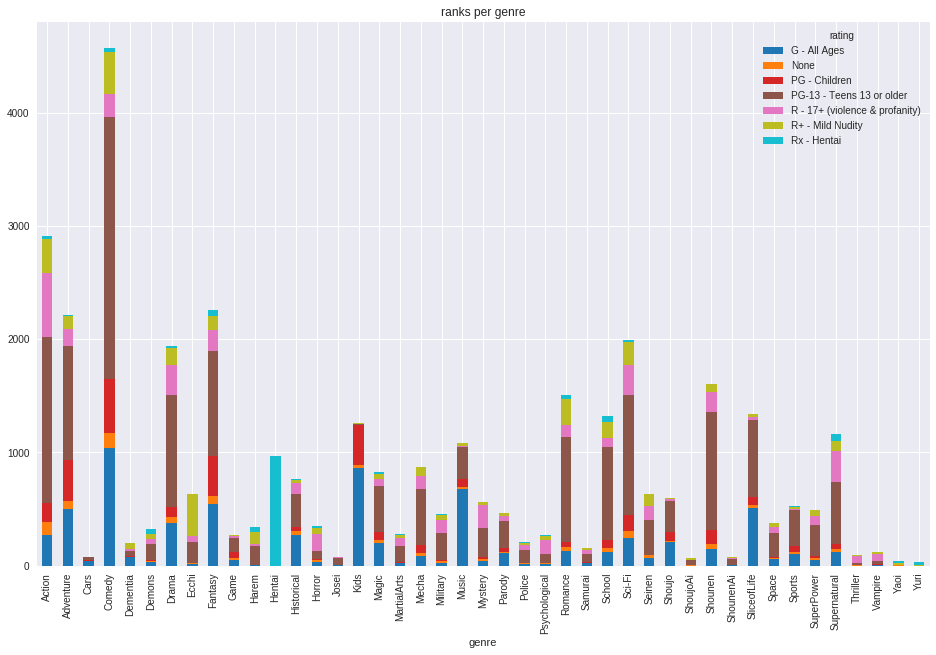

In [81]:
colors = plt.cm.tab10(np.linspace(0, 1, rank_count))
genre_ranks = pd.crosstab(animes_genres['genre'], animes_genres['rating'])
genre_ranks.plot(kind='bar', stacked=True, figsize=(16, 10), title='ranks per genre', color=colors)

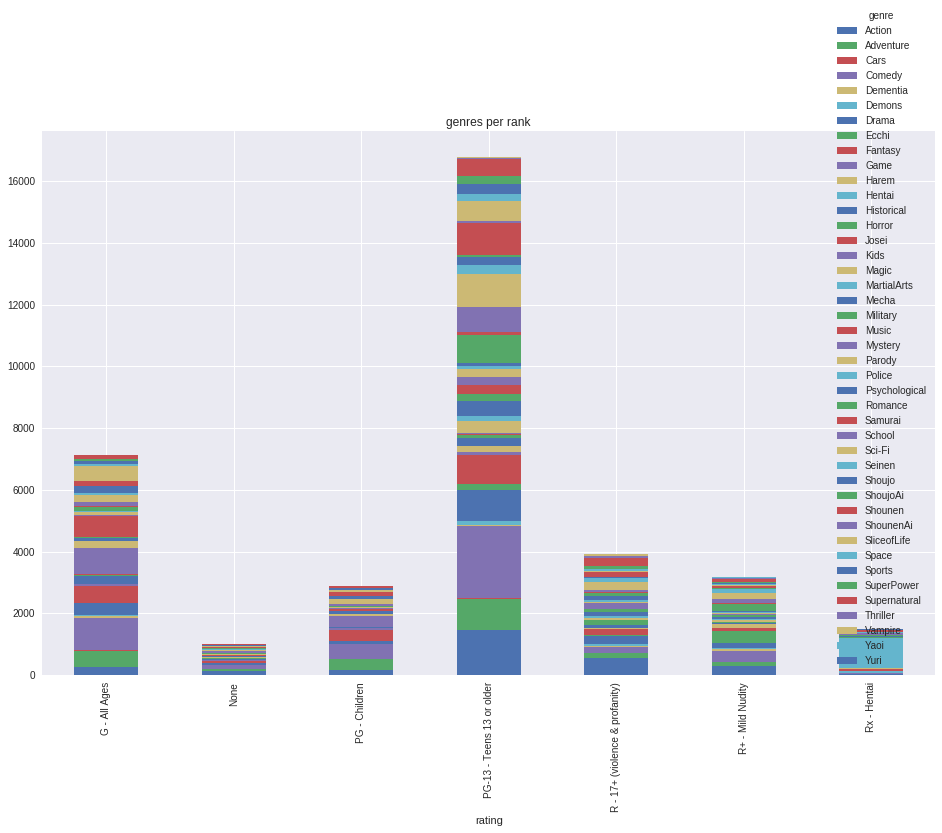

In [82]:
rank_genres = pd.crosstab(animes_genres['rating'], animes_genres['genre'])
rank_genres.plot(kind='bar', stacked=True, figsize=(16, 10), title='genres per rank')

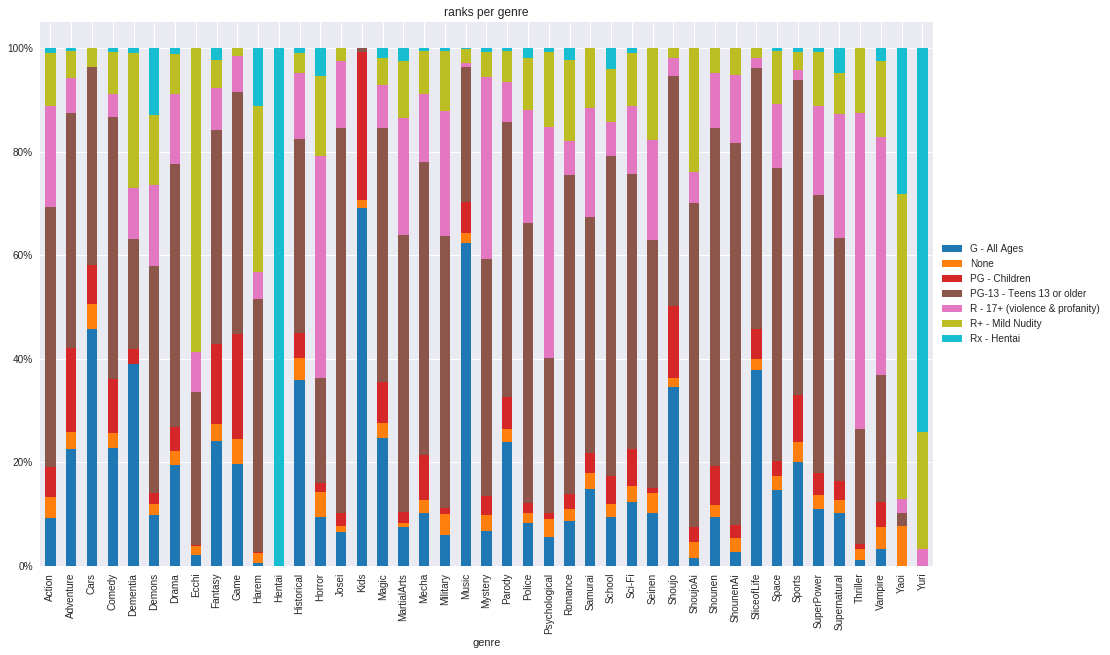

In [83]:
colors = plt.cm.tab10(np.linspace(0, 1, rank_count))
genre_ranks.div(genre_ranks.sum(axis=1), axis=0).plot(kind='bar', stacked=True, figsize=(16, 10), title='ranks per genre', color=colors)
plt.gca().legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 

## inspecting studios and genres

In [84]:
print('unique studios combinations:')
animes['studios'].unique().size

unique studios combinations:


777

In [85]:
# now comes some data cleaning, getting rid of commas in studio names for easier manipulation
animes.loc[animes['studios'] == 'Yamamura Animation, Inc.', 'studios'] = 'Yamamura Animation'
# here, in animes_genres, is every anime duplicated, once per each genre it contains
animes['studios'].fillna('', inplace=True)
studios_arr = animes['studios'].apply(lambda x: x.replace(' ', '').split(',')).apply(pd.Series).stack().to_frame(name='studio')
studios_arr.index.levels[0].name = 'anime_id'
animes_studios = pd.merge(animes, studios_arr, how='inner', left_index=True, right_index=True)
animes_studios = animes_studios[animes_studios['studio'] != '']

In [86]:
print('unique studios:')
animes_studios['studio'].unique().size

unique studios:


507

In [87]:
animes_studios['studio'].value_counts().sort_values(ascending=False)

ToeiAnimation              744
Sunrise                    466
Madhouse                   349
J.C.Staff                  333
ProductionI.G              302
TMSEntertainment           266
StudioDeen                 261
StudioPierrot              253
NipponAnimation            209
OLM                        199
A-1Pictures                189
TatsunokoProduction        157
Shin-EiAnimation           157
Xebec                      145
DLE                        144
Gonzo                      123
Shaft                      120
AIC                        118
Bones                      117
KyotoAnimation             110
Satelight                   88
ProductionReed              87
Brain&#039;sBase            86
SilverLink.                 83
Gainax                      82
Arms                        73
Studio4°C                   68
Zexcs                       67
DogaKobo                    64
feel.                       63
                          ... 
HiroMedia                    1
DigitalN

In [88]:
known_studios = animes_studios['studio'].value_counts().sort_values(ascending=False).index[0:35]
known_studios

Index(['ToeiAnimation', 'Sunrise', 'Madhouse', 'J.C.Staff', 'ProductionI.G',
       'TMSEntertainment', 'StudioDeen', 'StudioPierrot', 'NipponAnimation',
       'OLM', 'A-1Pictures', 'TatsunokoProduction', 'Shin-EiAnimation',
       'Xebec', 'DLE', 'Gonzo', 'Shaft', 'AIC', 'Bones', 'KyotoAnimation',
       'Satelight', 'ProductionReed', 'Brain&#039;sBase', 'SilverLink.',
       'Gainax', 'Arms', 'Studio4°C', 'Zexcs', 'DogaKobo', 'feel.', 'ufotable',
       'StudioGallop', 'Seven', 'StudioHibari', 'StudioGhibli'],
      dtype='object')

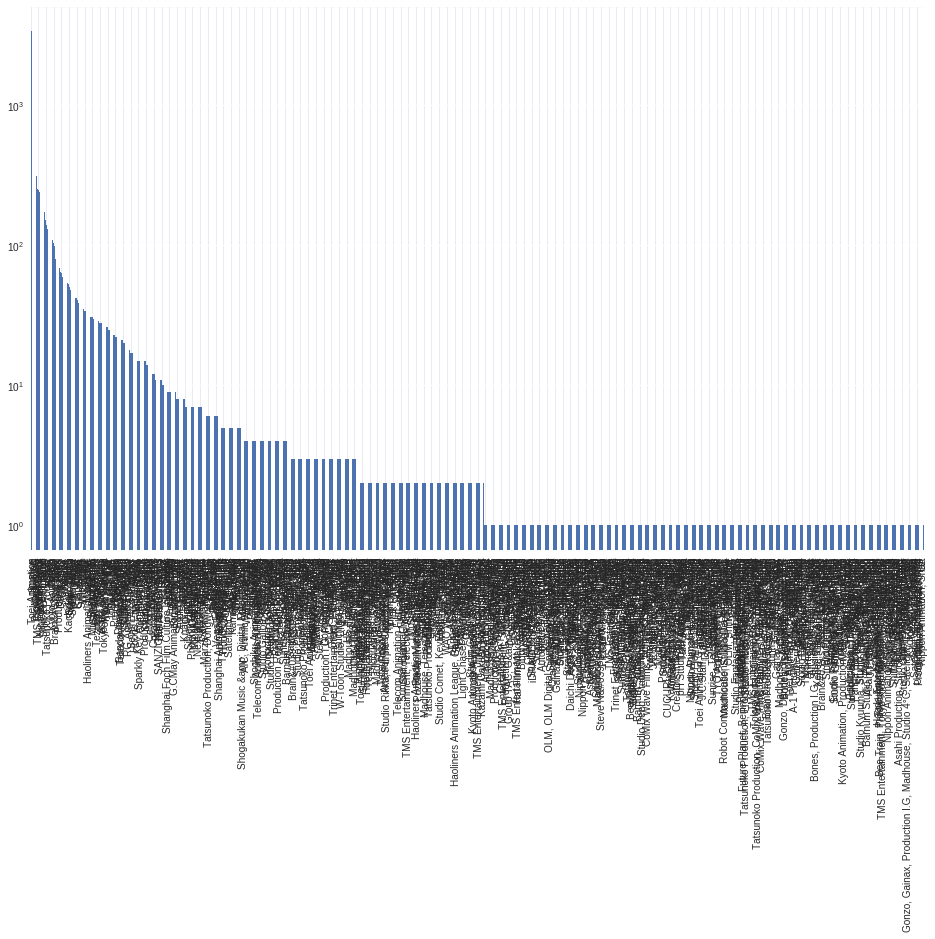

In [89]:
animes['studios'].value_counts().plot(kind='bar', figsize=(16, 10), logy=True)

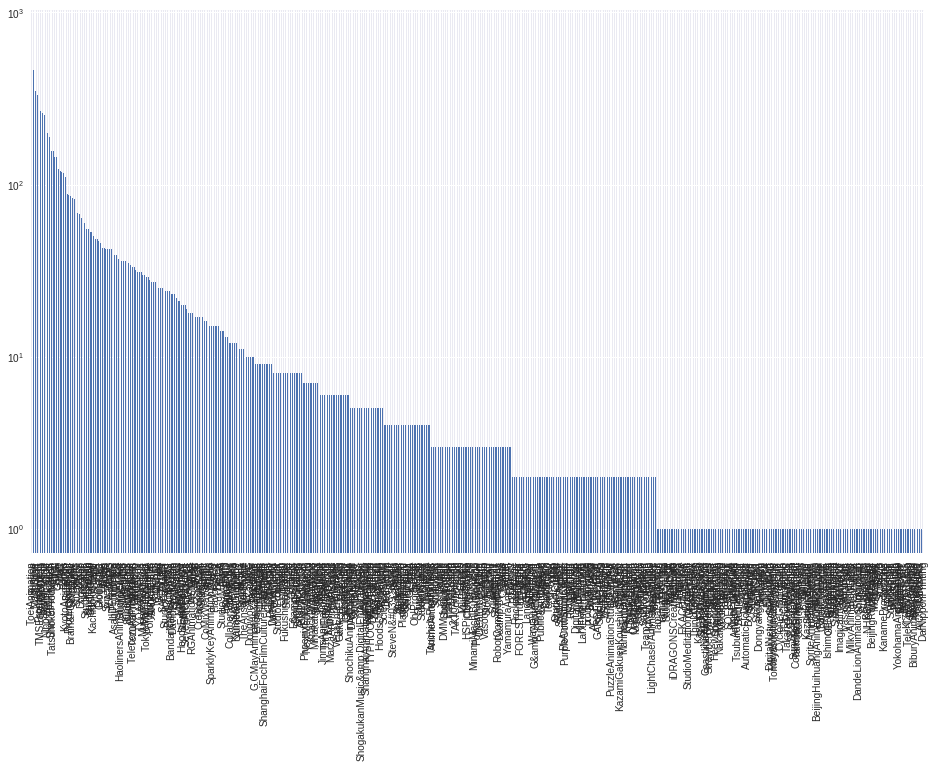

In [90]:
animes_studios['studio'].value_counts().plot(kind='bar', figsize=(16, 10), logy=True)

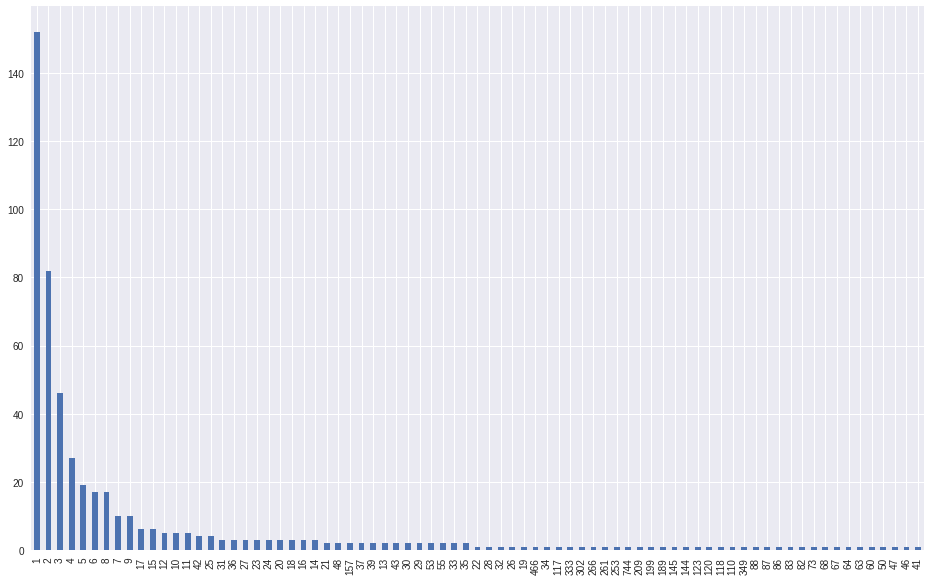

In [91]:
animes_studios['studio'].value_counts().value_counts().plot(kind='bar', figsize=(16, 10))

In [92]:
studio_counts = animes_studios['studio'].value_counts().sort_values(ascending=False)
# bigger studios are with 10 or more anime
bigger_studios = studio_counts[studio_counts >= 10].index
print('# studios with 10 or more anime')
len(bigger_studios)

# studios with 10 or more anime


127

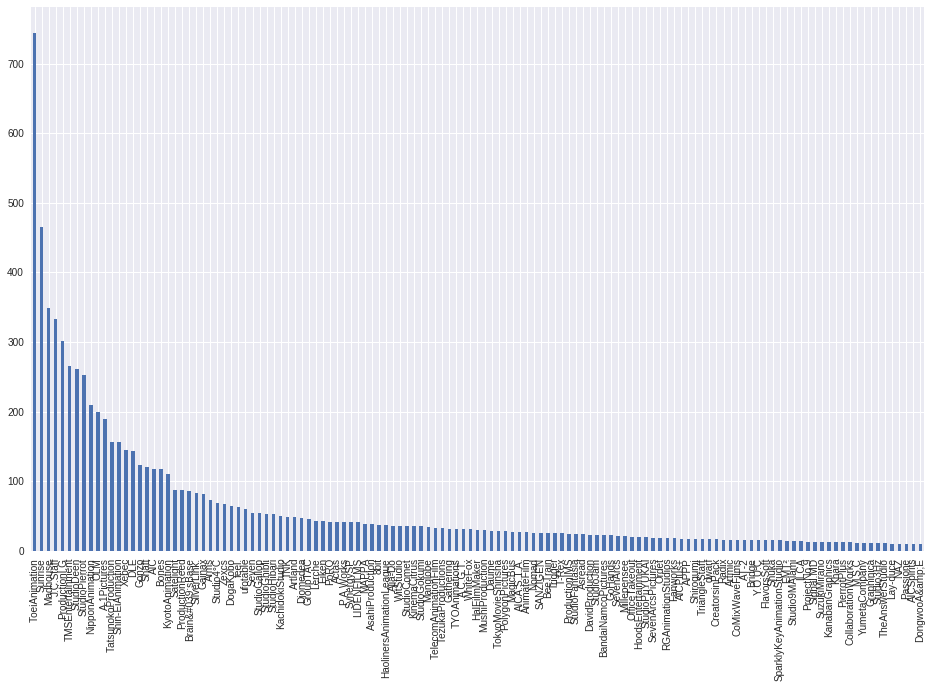

In [93]:
animes_studios[animes_studios['studio'].isin(bigger_studios)]['studio'].value_counts().plot(kind='bar', figsize=(16, 10))

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34]), <a list of 35 Text xticklabel objects>)

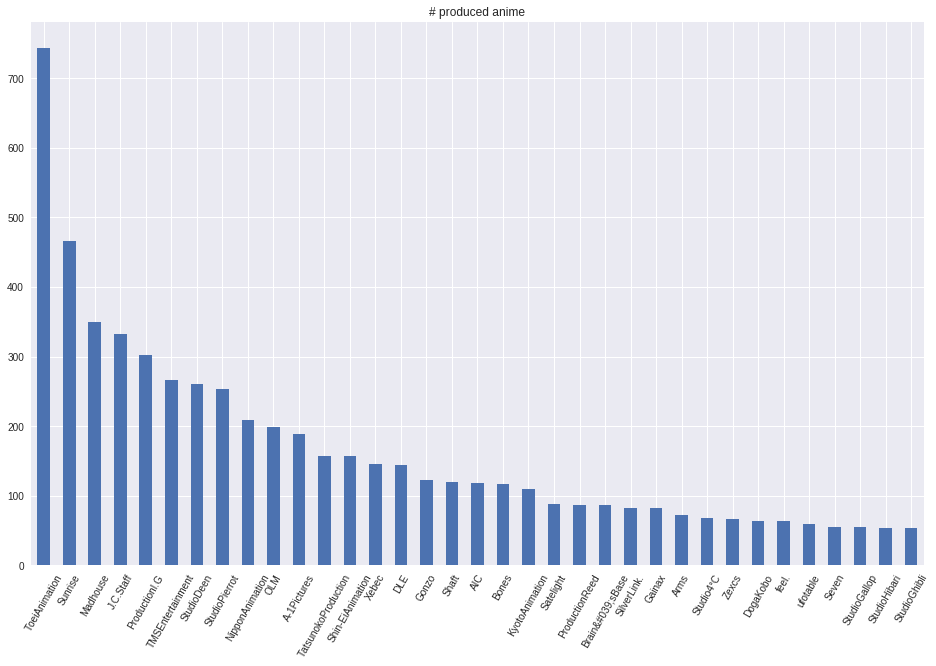

In [94]:
animes_studios[animes_studios['studio'].isin(known_studios)]['studio'].value_counts().plot(kind='bar', figsize=(16, 10), title='# produced anime')
plt.xticks(rotation=60)

In [95]:
animes_studios_genres = pd.merge(animes_studios.reset_index(), genres_arr.reset_index(), how='inner', on='anime_id').drop(['level_1_x', 'level_1_y'], axis=1)
animes_studios_genres = animes_studios_genres[animes_studios_genres['genre'] != '']

In [96]:
studios_genres = pd.crosstab(animes_studios_genres['studio'], animes_studios_genres['genre'])
# only for known studios
studios_genres = studios_genres[studios_genres.index.isin(known_studios)]

In [97]:
studios_genres.columns

Index(['Action', 'Adventure', 'Cars', 'Comedy', 'Dementia', 'Demons', 'Drama',
       'Ecchi', 'Fantasy', 'Game', 'Harem', 'Hentai', 'Historical', 'Horror',
       'Josei', 'Kids', 'Magic', 'MartialArts', 'Mecha', 'Military', 'Music',
       'Mystery', 'Parody', 'Police', 'Psychological', 'Romance', 'Samurai',
       'School', 'Sci-Fi', 'Seinen', 'Shoujo', 'ShoujoAi', 'Shounen',
       'ShounenAi', 'SliceofLife', 'Space', 'Sports', 'SuperPower',
       'Supernatural', 'Thriller', 'Vampire', 'Yaoi', 'Yuri'],
      dtype='object', name='genre')

In [98]:
interesting_genres = ['Action', 'Adventure', 'Comedy', 'Drama',
       'Fantasy', 'Hentai', 
       'Kids', 'Magic', 'Mecha', 'Music',
       'Mystery', 'Romance', 
       'Sci-Fi', 'SliceofLife']

In [99]:
# group rest of genres to "other" value
other_genres = list(set(studios_genres.columns) - set(interesting_genres))
studios_genres['other'] = studios_genres[other_genres].sum(axis=1)
studios_genres.drop(other_genres, inplace=True, axis=1)
studios_genres

genre                Action  Adventure  Comedy  Drama  Fantasy  Hentai  Kids  \
studio                                                                         
A-1Pictures              71         30      90     25       63       0     2   
AIC                      51         32      58     16       20       3     0   
Arms                     31         15      19     10       18      20     1   
Bones                    69         32      50     41       29       0     2   
Brain&#039;sBase         20         10      46     18       18       0     0   
DLE                       7          1     118      1        6       0     8   
DogaKobo                 11          2      46      8       12       0     0   
Gainax                   30         12      43     15        5       0     2   
Gonzo                    63         34      48     28       22       0     1   
J.C.Staff                87         50     189     74       69       8     4   
KyotoAnimation           10          2      63     29       24       0     0   
Madhouse                109         95     137    123       75       0    20   
NipponAnimation          23        102      51     83       31       0    43   
OLM                      68         93     103     36      105       0   115   
ProductionI.G           104         45     125     69       54       0     8   
ProductionReed           38         29      39     17       14       0     1   
Satelight                38         18      27     18       19       0     0   
Seven                     0          1      30      2        2      20     0   
Shaft                    14          8      80     22       12       0     1   
Shin-EiAnimation          9         52     121     11       34       0    62   
SilverLink.              20          2      57      4       19       0     0   
Studio4°C                24         19      15      9       18       0     1   
StudioDeen               73         40     146     68       54       1     9   
StudioGallop             21         24      32      9       19       0     9   
StudioGhibli              2         18       7     13       17       0     9   
StudioHibari             10         14      33     17       12       0     3   
StudioPierrot            92         76     142     52       43       0    13   
Sunrise                 237        124     135    114       54       0    14   
TMSEntertainment         74        112     163     33       61       0    65   
TatsunokoProduction      54         62      70     23       16       0    18   
ToeiAnimation           255        291     302    170      276       0   107   
Xebec                    59         30      74     14       24       0     9   
Zexcs                    10          5      28     19       13       0     0   
feel.                     4          0      45     11        8       0     0   
ufotable                 32         10      20      9       22       0     1   

genre                Magic  Mecha  Music  Mystery  Romance  Sci-Fi  \
studio                                                               
A-1Pictures             23      5     30       11       34      32   
AIC                     16     26      2        4       39      55   
Arms                     3      0      0        2       10       5   
Bones                    6     21      8       23       21      41   
Brain&#039;sBase         2     10      2        6       25       8   
DLE                      0      2      7        2        1       4   
DogaKobo                 0      1      1        3       14       3   
Gainax                   8     22      7        4       12      36   
Gonzo                    7     32      1        7       16      57   
J.C.Staff               43     25      7       25       94      57   
KyotoAnimation          10      3     15        5       20       4   
Madhouse                31     11     16       40       67      90   
NipponAnimation         12      9      3        6       20 

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34]), <a list of 35 Text xticklabel objects>)

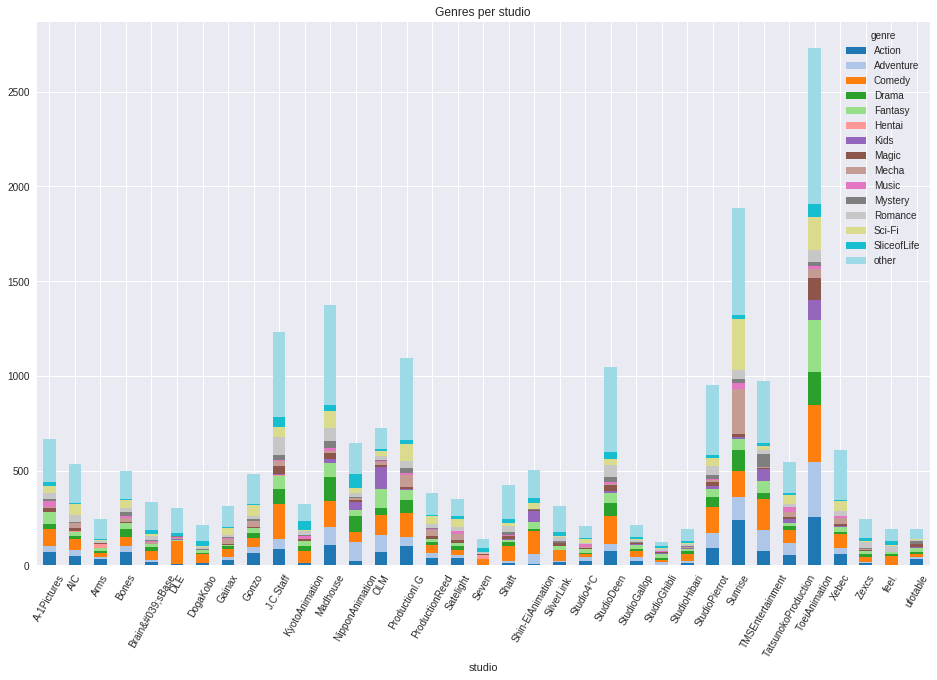

In [100]:
colors = plt.cm.tab20(np.linspace(0, 1, studios_genres.shape[1]))
studios_genres.plot.bar(stacked=True, figsize=(16, 10), title='Genres per studio', color=colors)
plt.xticks(rotation=60)

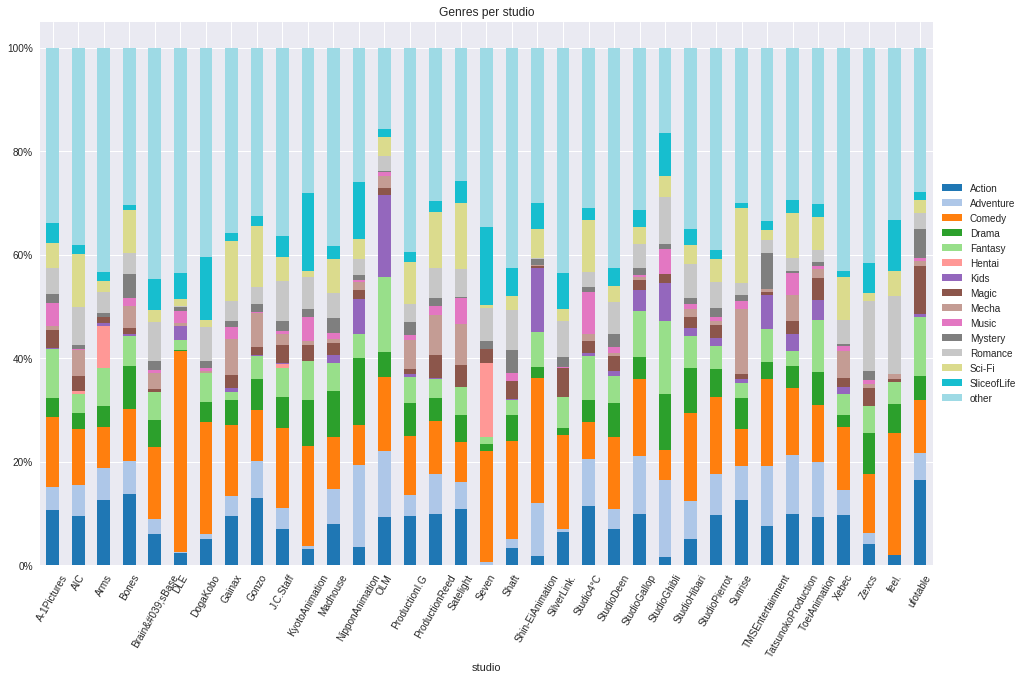

In [101]:
studios_genres.div(studios_genres.sum(axis=1), axis=0).plot.bar(stacked=True, figsize=(16, 10), title='Genres per studio', color=colors)
plt.xticks(rotation=60)
plt.gca().legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 

In [102]:
studios_genres.sum(axis=0)

genre
Action         1820
Adventure      1490
Comedy         2752
Drama          1211
Fantasy        1288
Hentai           52
Kids            528
Magic           505
Mecha           685
Music           269
Mystery         389
Romance         930
Sci-Fi         1361
SliceofLife     710
other          7223
dtype: int64

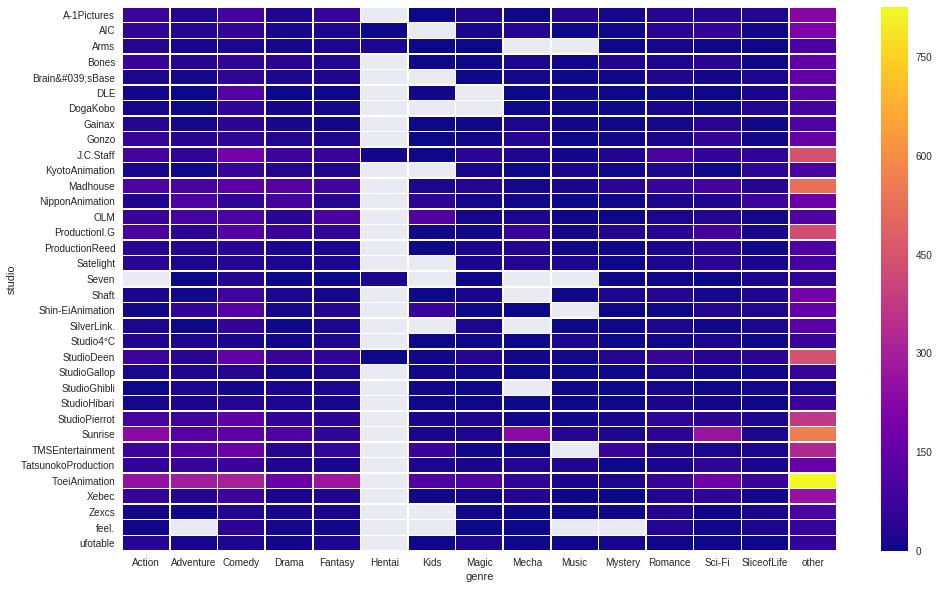

In [103]:
# showing pairwise heatmap from https://seaborn.pydata.org/examples/many_pairwise_correlations.html
# Compute the correlation matrix
colors = plt.cm.plasma(np.linspace(0, 1, studios_genres.max().max()))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(16, 10))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(250, 0, sep=20, as_cmap=True)

mask = np.zeros_like(studios_genres, dtype=np.bool)
mask[studios_genres == 0] = True

sns.heatmap(studios_genres, mask=mask, linewidths=.5, cmap=plt.cm.plasma)


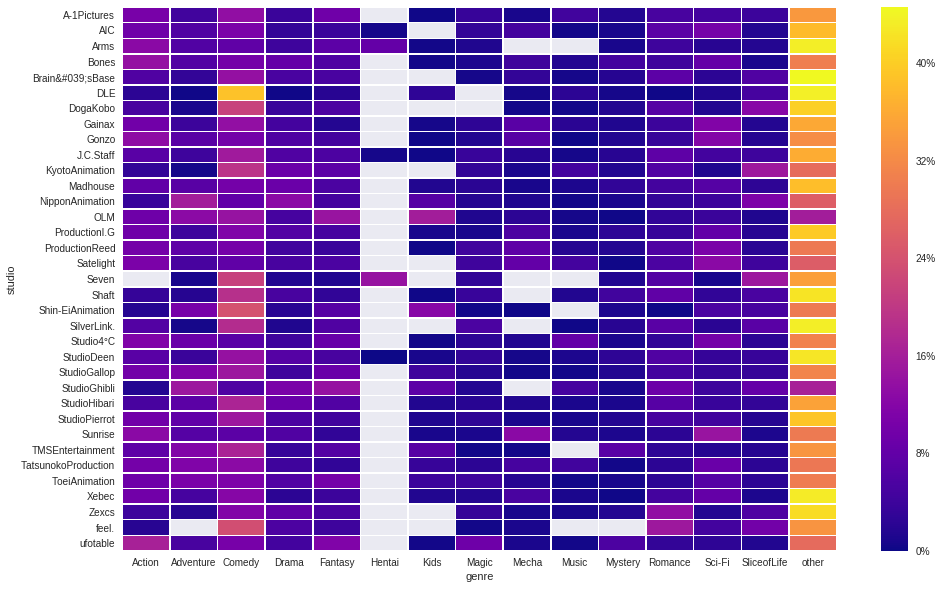

In [104]:
f, ax = plt.subplots(figsize=(16, 10))
mask = np.zeros_like(studios_genres, dtype=np.bool)
mask[studios_genres == 0] = True
sns.heatmap(studios_genres.div(studios_genres.sum(axis=1), axis=0) * 100, mask=mask, linewidths=.5, cmap=plt.cm.plasma, cbar_kws={'format': '%.0f%%'})


In [105]:
# basically the same thing as above, but for more genres, since heatmap can handle it in this layout
studios_genres = pd.crosstab(animes_studios_genres['studio'], animes_studios_genres['genre'])
studios_genres = studios_genres[studios_genres.index.isin(known_studios)]
interesting_genres = ['Action', 'Adventure', 'Cars', 'Comedy', 'Dementia', 'Demons', 'Drama',
       'Ecchi', 'Fantasy', 'Game', 'Harem', 'Hentai', 'Historical', 'Horror',
       'Josei', 'Kids', 'Magic', 'MartialArts', 'Mecha', 'Military', 'Music',
       'Mystery', 'Parody', 'Police', 'Psychological', 'Romance', 'Samurai',
       'School', 'Sci-Fi', 'Seinen', 'Shoujo', 'ShoujoAi', 'Shounen',
       'ShounenAi', 'SliceofLife', 'Space', 'Sports', 'SuperPower',
       'Supernatural', 'Thriller', 'Vampire', 'Yaoi', 'Yuri']

other_genres = list(set(studios_genres.columns) - set(interesting_genres))
# no other genres, so I don't add this column
#studios_genres['other'] = studios_genres[other_genres].sum(axis=1)
studios_genres.drop(other_genres, inplace=True, axis=1)

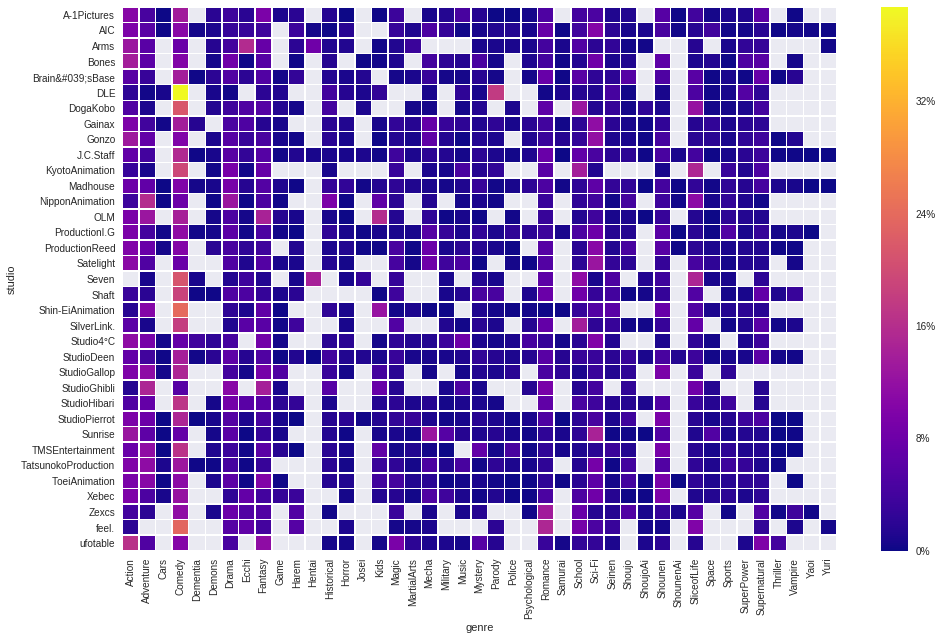

In [106]:
f, ax = plt.subplots(figsize=(16, 10))
mask = np.zeros_like(studios_genres, dtype=np.bool)
mask[studios_genres == 0] = True
sns.heatmap(studios_genres.div(studios_genres.sum(axis=1), axis=0) * 100, mask=mask, linewidths=.5, cmap=plt.cm.plasma, cbar_kws={'format': '%.0f%%'})


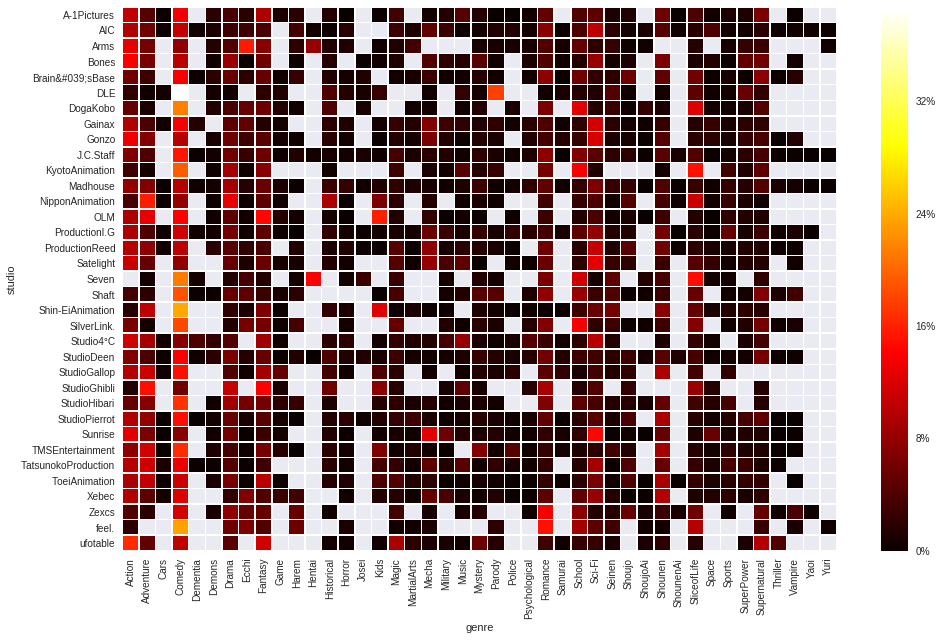

In [107]:
f, ax = plt.subplots(figsize=(16, 10))
sns.heatmap(studios_genres.div(studios_genres.sum(axis=1), axis=0) * 100, mask=mask, linewidths=.5, cmap=plt.cm.hot, cbar_kws={'format': '%.0f%%'})

In [108]:
# now try the histogram equalization on colormap to better show data
# histogram equalization taken from https://github.com/jobar8/graphics/blob/master/graphics.py and modified little bit
from skimage import exposure

def cmap_to_array(cmap,N=256):
    """
    Return a Nx3 array of RGB values generated from a colormap.
    """
    return cmap(np.linspace(0, 1, N))[:,:3] # remove alpha column

def equalize_colormap(cmap, data, name='EqualizedMap'):
    if type(data) is pd.DataFrame:
        data = data.as_matrix()
    data = data[~np.isnan(data)].flatten()
    cdf, bins = exposure.cumulative_distribution(data, nbins=256)
    # Using it for highly non-uniform data will cause high information loss for extreme values
    #So we do only half equalization, equalizing with histogram averaged with uniform histogram
    # and now the same for uniform distribution of same size
    cdf_u, bins_u = exposure.cumulative_distribution(np.linspace(data.min(), data.max(), data.shape[0]),nbins=256)
    cdf = (cdf + cdf_u) / 2
    '''
    Re-map a colormap according to a cumulative distribution. This is used to 
    perform histogram equalization of an image by changing the colormap 
    instead of the image. *This is not strickly speaking the equalization of the 
    colormap itself*.
    The cdf and bins should be calculated from an input image, as if carrying out
    the histogram equalization of that image. In effect, the cdf becomes integrated  
    to the colormap as a mapping function by redistributing the indices of the
    input colormap.
    
    Parameters
    ----------
    cmap : string or colormap object
        Input colormap to remap.
    bins : array
        Centers of bins.
    cdf : array
        Values of cumulative distribution function.
    '''
    
    # first retrieve the color table (lists of RGB values) behind the input colormap
    if cmap in mpl.cm.cmap_d: # matplotlib colormaps + plus the new ones (viridis, inferno, etc.)
        cmList = cmap_to_array(cm.cmap_d[cmap])
    else:
        try:
            # in case cmap is a colormap object
            cmList = cmap_to_array(cmap) 
        except:
            raise ValueError('Colormap {} has not been recognised'.format(cmap))
    
    # normalize the input bins to interval (0,1)
    bins_norm = (bins - bins.min())/np.float(bins.max() - bins.min())
    
    # calculate new indices by applying the cdf as a function on the old indices
    # which are initially regularly spaced. 
    old_indices = np.linspace(0,1,len(cmList))
    new_indices = np.interp(old_indices,cdf,bins_norm)
    
    # make sure indices start with 0 and end with 1
    new_indices[0] = 0.0
    new_indices[-1] = 1.0
    
    # remap the color table
    cdict = {'red': [], 'green': [], 'blue': []}
    for i,n in enumerate(new_indices):
        r1, g1, b1 = cmList[i]
        cdict['red'].append([n, r1, r1])
        cdict['green'].append([n, g1, g1])
        cdict['blue'].append([n, b1, b1])
        
    return mpl.colors.LinearSegmentedColormap(name, cdict)


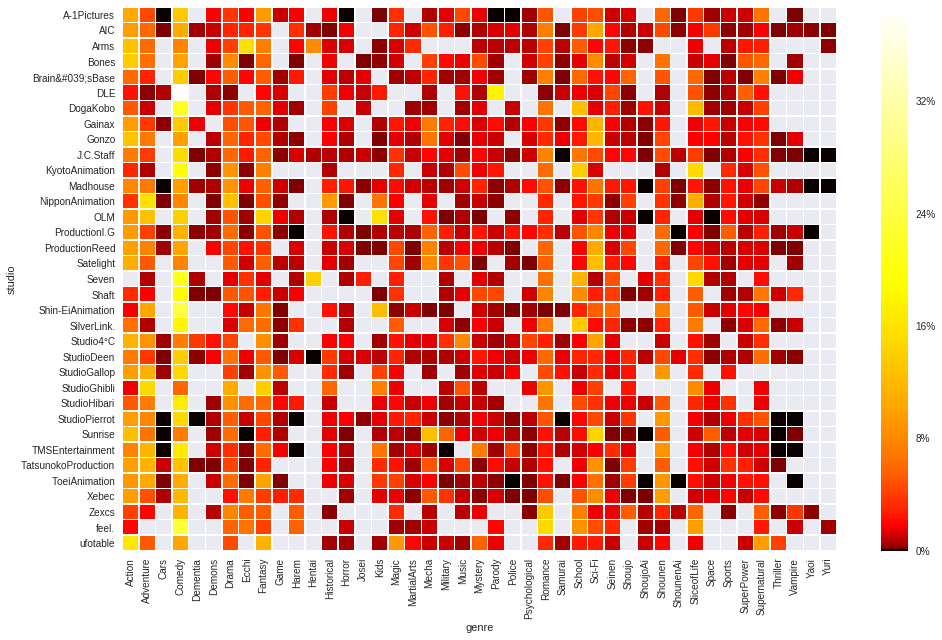

In [109]:
f, ax = plt.subplots(figsize=(16, 10))
data = studios_genres.div(studios_genres.sum(axis=1), axis=0) * 100
cmap = equalize_colormap(plt.cm.hot, data)
mask = np.zeros_like(studios_genres, dtype=np.bool)
mask[studios_genres == 0] = True
sns.heatmap(data, mask=mask, linewidths=.5, cmap=cmap, cbar_kws={'format': '%.0f%%'})

### calculating embeddings to show topology of studio space

In [110]:
def dists_to_csv(nodes_name, edges_name, nodes, dists):
    pairs = np.array(list(combinations(studios_genres.index, 2)))
    
    nodes = pd.DataFrame({'id': studios_genres.index, 'label': studios_genres.index})
    edges = pd.DataFrame({'source': pairs[:, 0], 'target': pairs[:, 1], 'weight': dists})
    edges['type'] = 'undirected'
    
    nodes.to_csv(nodes_name, index=False, sep=',', encoding='utf-8')
    edges.to_csv(edges_name, index=False, sep=',', encoding='utf-8')
    
dists = pdist(studios_genres.div(studios_genres.sum(axis=1), axis=0), 'euclidean')
dists_to_csv('studios_nodes.csv', 'studios_edges_eucledian.csv', studios_genres.index, dists)

In [111]:
dists = pdist(studios_genres.div(studios_genres.sum(axis=1), axis=0), 'cityblock')
dists_to_csv('studios_nodes.csv', 'studios_edges_cityblock.csv', studios_genres.index, dists)

In [112]:
dists = pdist(studios_genres.div(studios_genres.sum(axis=1), axis=0), 'correlation')
dists_to_csv('studios_nodes.csv', 'studios_edges_correlation.csv', studios_genres.index, 1 / dists)

In [113]:
dists = pdist(studios_genres.div(studios_genres.sum(axis=1), axis=0), 'cosine')
dists_to_csv('studios_nodes.csv', 'studios_edges_cosine.csv', studios_genres.index, 1 / dists)

In [114]:
# using Jensen Shannon diverge, which is symeterized version of KL divergence
def js(p, q):
    p /= p.sum()
    q /= q.sum()
    m = (p + q) / 2
    return (entropy(p, m) + entropy(q, m)) / 2

def js_metric(p, q):
    # with square root it will satisfy triangle inequality
    return np.sqrt(js(p, q))

dists = pdist(studios_genres.div(studios_genres.sum(axis=1), axis=0), lambda x, y: js_metric(x, y))
dists_to_csv('studios_nodes.csv', 'studios_edges_js.csv', studios_genres.index, dists)

6

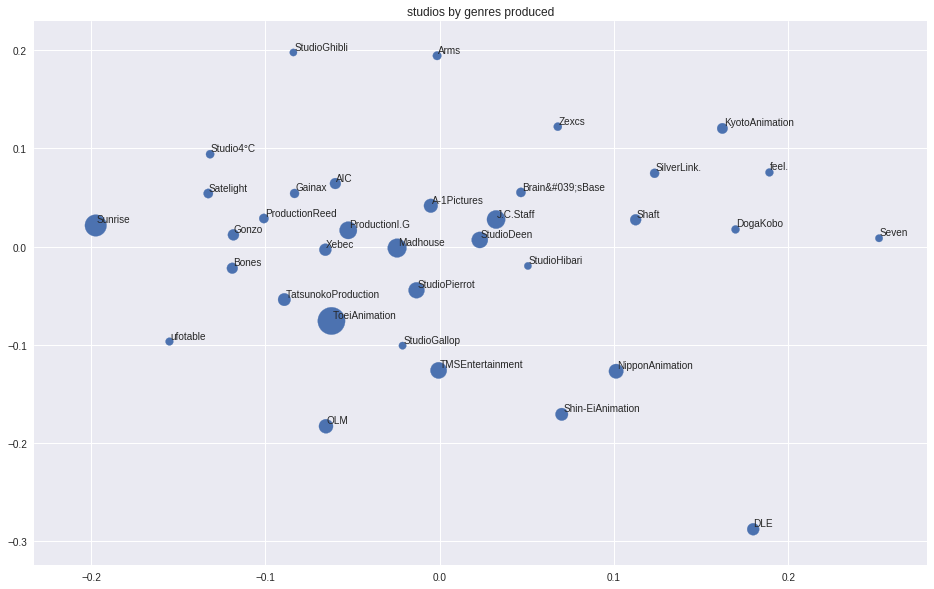

In [115]:
%matplotlib inline

# using manifold embedding to represent studios in 2D: http://scikit-learn.org/stable/auto_examples/manifold/plot_compare_methods.html
# using https://github.com/Phlya/adjustText to adjust text labels so they don't overlap
embedder = manifold.MDS(2, max_iter=1000, n_init=5)
embeddings = embedder.fit_transform(studios_genres.div(studios_genres.sum(axis=1), axis=0))
# need to agregate animes_studios because it does not contain duplicities because of genres
studio_sizes = animes_studios[animes_studios['studio'].isin(known_studios)]['studio'].value_counts().sort_index()
plt.figure(figsize=(16, 10))
plt.scatter(embeddings[:, 0], embeddings[:, 1], s=studio_sizes)
plt.title("studios by genres produced")
texts = [plt.text(embeddings[i, 0], embeddings[i, 1], txt) for i, txt in enumerate(studios_genres.index)]
adjust_text(texts)


<IPython.core.display.Javascript object>


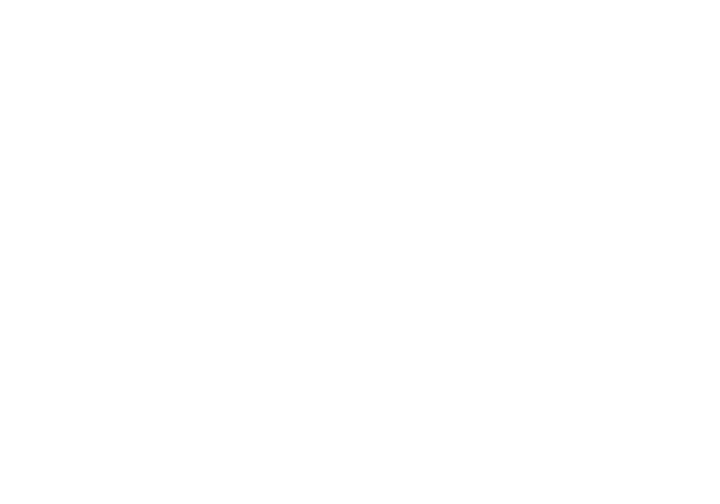

<IPython.core.display.Javascript object>


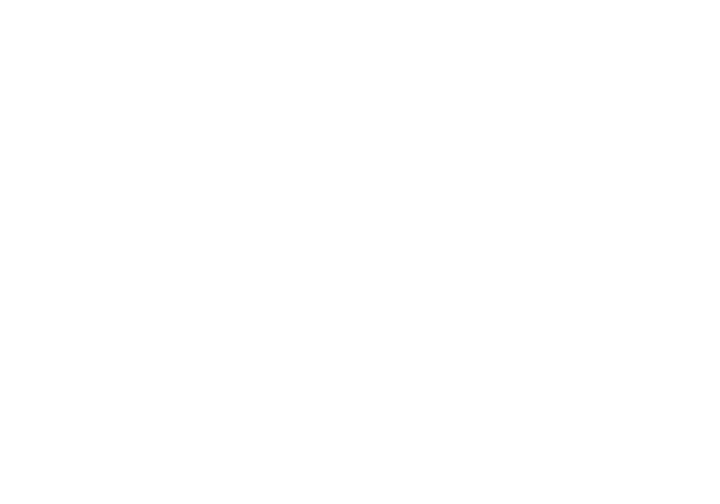

In [281]:
%matplotlib notebook

embedder = manifold.MDS(3, max_iter=1000, n_init=10)
embeddings = embedder.fit_transform(studios_genres.div(studios_genres.sum(axis=1), axis=0))
plt.figure(figsize=(10, 7))

ax = plt.axes(projection='3d')
ax.scatter3D(embeddings[:, 0], embeddings[:, 1], embeddings[:, 2], s=studio_sizes)
plt.title("studios by genres produced in 3D")
for i, txt in enumerate(studios_genres.index):
    ax.text(embeddings[i, 0], embeddings[i, 1], embeddings[i, 2], txt)

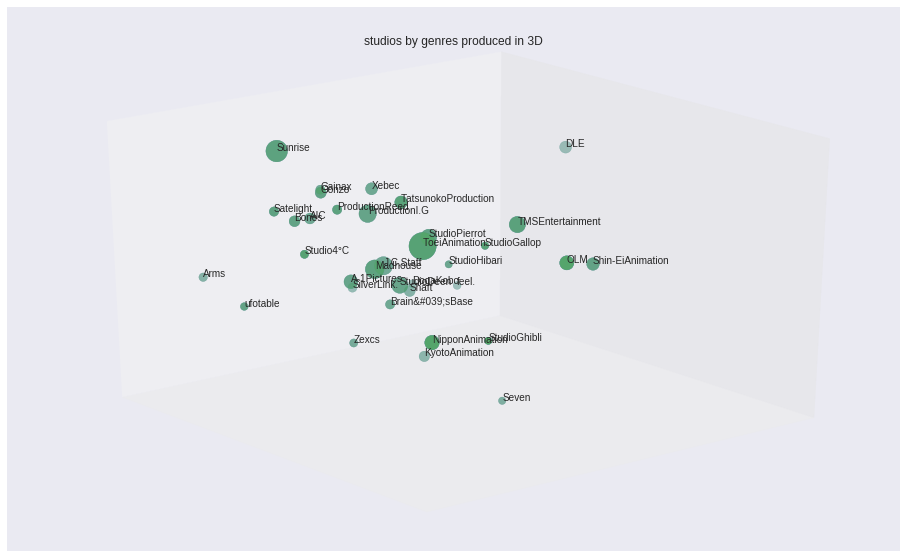

In [282]:
%matplotlib inline

def init(sizes):
    def my_init():
        ax.scatter3D(embeddings[:, 0], embeddings[:, 1], embeddings[:, 2], s=sizes)
        return fig,
    return my_init

def animate(i):
    ax.azim = ax.azim - 2
    ax.view_init(ax.elev, ax.azim)
    return fig,

def points_3d_to_gif(embeddings, labels, gif_filename, ax, sizes):
    for i, txt in enumerate(labels):
        ax.text(embeddings[i, 0], embeddings[i, 1], embeddings[i, 2], txt)

    #plt.axis('off')
    #ax.grid(False)
    ax.grid(True)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])

    ax.elev = 25.
    ax.azim = 321.
    ax.dist = 11.

    # Animate, interval in ms, frames == # of frames in animation
    anim = animation.FuncAnimation(fig, animate, init_func=init(sizes),
                                   frames=180, interval=80, blit=True)
    # Save
    anim.save('images/{}.gif'.format(gif_filename), dpi=80, writer='imagemagick')

fig = plt.figure(figsize=(16, 10))
ax = plt.axes(projection='3d')
plt.title("studios by genres produced in 3D")
points_3d_to_gif(embeddings, studios_genres.index, 'studios-genres-MDS', ax, studio_sizes)

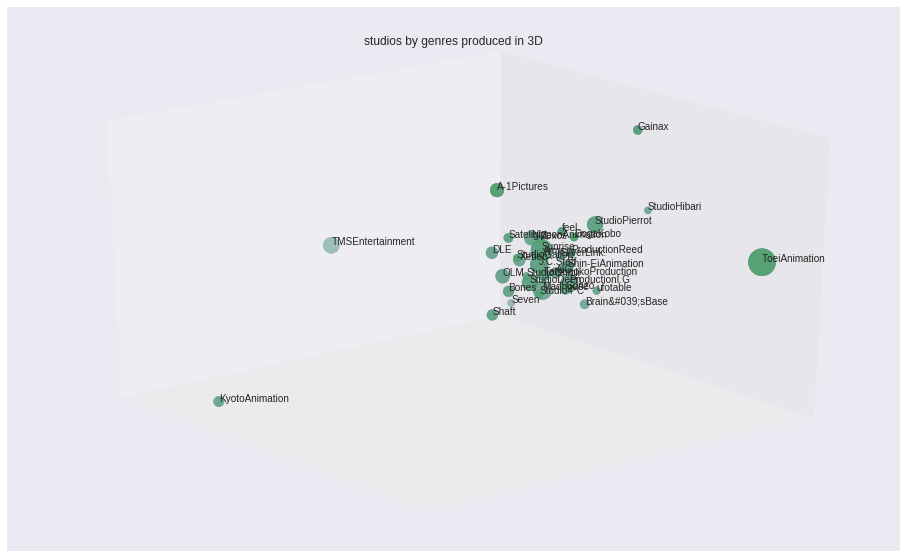

In [118]:
embedder = manifold.TSNE(3, n_iter=1000, n_iter_without_progress=300, init='pca')
embeddings = embedder.fit_transform(studios_genres.div(studios_genres.sum(axis=1), axis=0))

fig = plt.figure(figsize=(16, 10))
ax = plt.axes(projection='3d')
plt.title("studios by genres produced in 3D")
points_3d_to_gif(embeddings, studios_genres.index, 'studios-genres-TSNE', ax)

### inspecting genres in time

In [119]:
years_genres = pd.crosstab(animes_genres['aired_from'].dt.year, animes_genres['genre'])

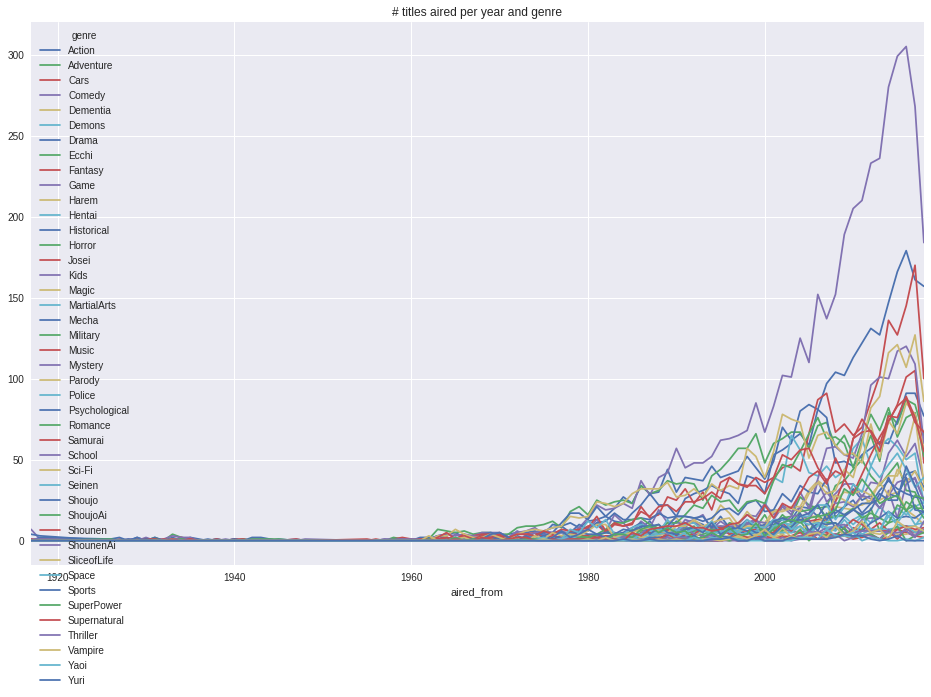

In [120]:
years_genres.plot(figsize=(16, 10), title='# titles aired per year and genre')

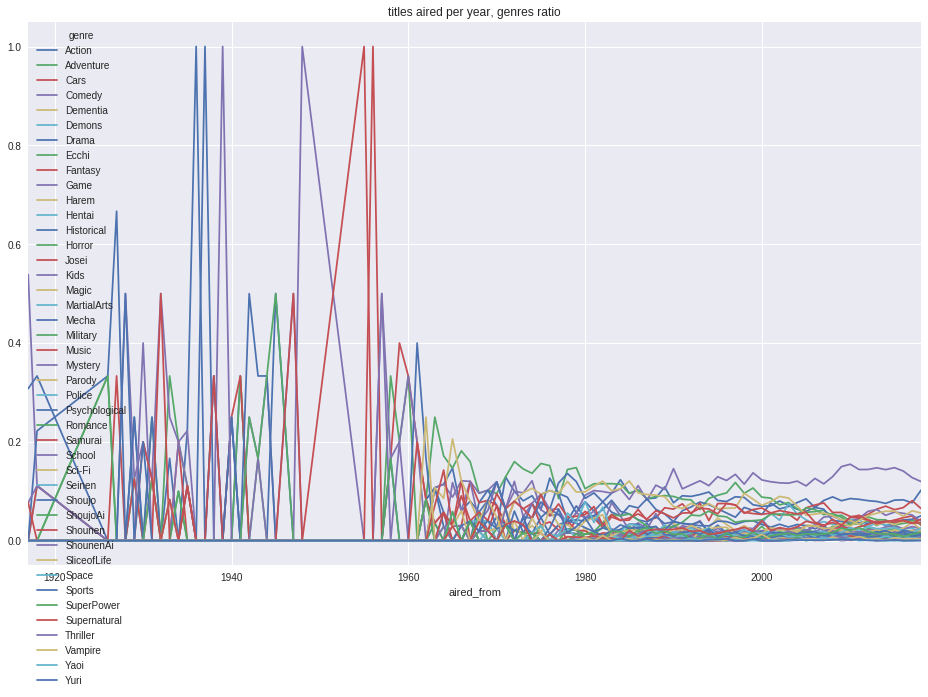

In [121]:
years_genres.div(years_genres.sum(axis=1), axis=0).plot(figsize=(16, 10), title='titles aired per year, genres ratio')

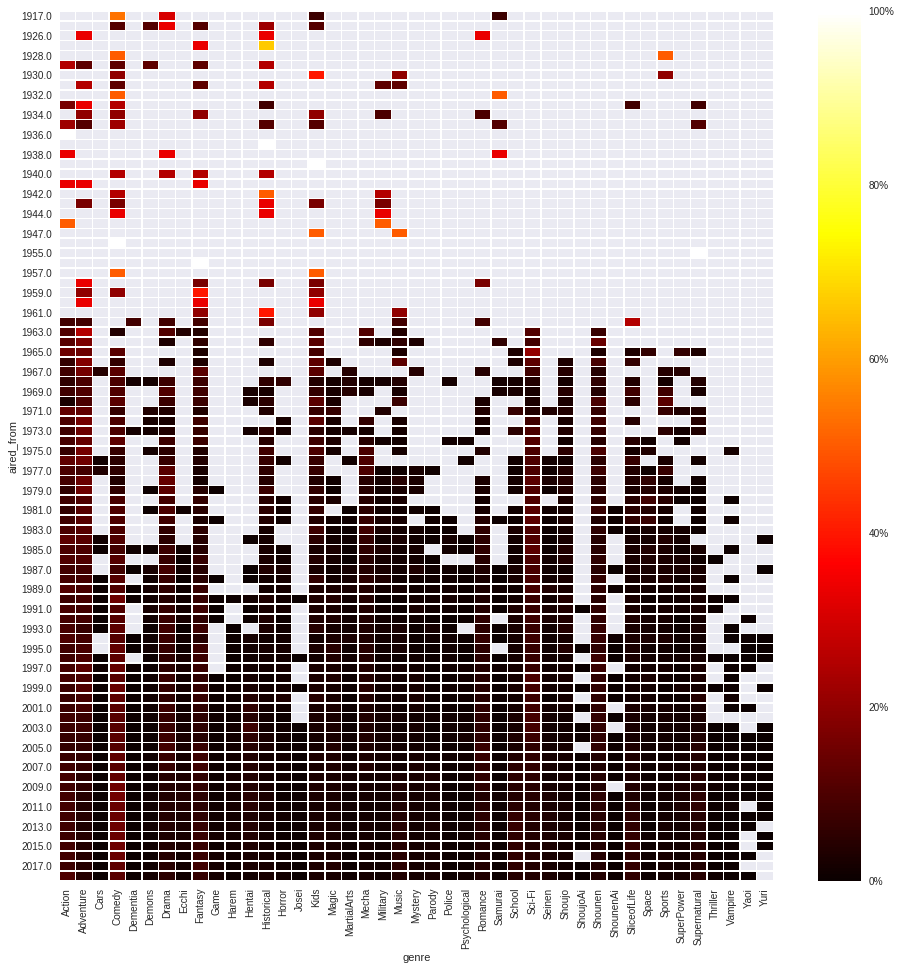

In [122]:
f, ax = plt.subplots(figsize=(16, 16))
mask = np.zeros_like(years_genres, dtype=np.bool)
mask[years_genres == 0] = True
sns.heatmap(years_genres.div(years_genres.sum(axis=1), axis=0) * 100, mask=mask, linewidths=.5, cmap=plt.cm.hot, cbar_kws={'format': '%.0f%%'})


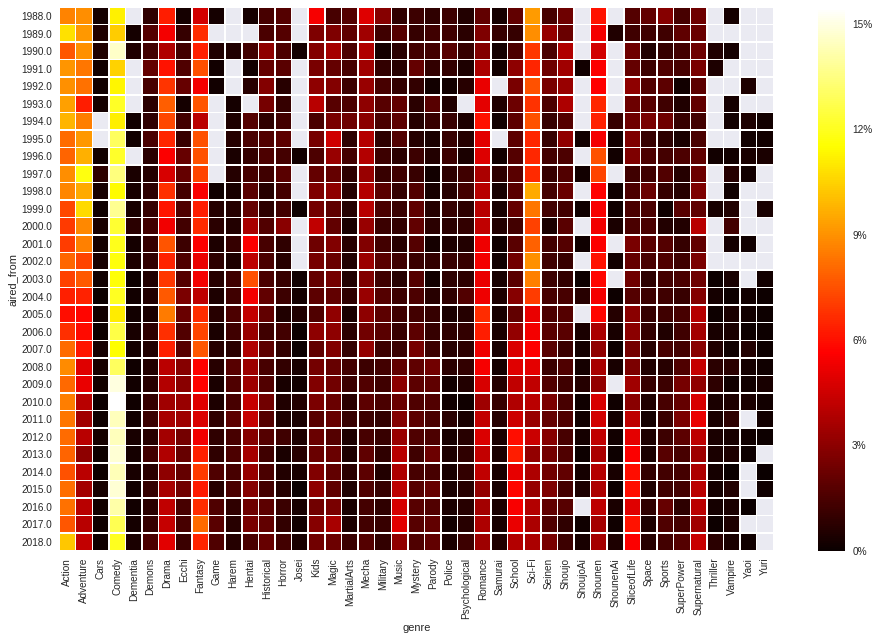

In [123]:
years_genres = years_genres[years_genres.index >= 1988]

f, ax = plt.subplots(figsize=(16, 10))
mask = np.zeros_like(years_genres, dtype=np.bool)
mask[years_genres == 0] = True
sns.heatmap(years_genres.div(years_genres.sum(axis=1), axis=0) * 100, mask=mask, linewidths=.5, cmap=plt.cm.hot, cbar_kws={'format': '%.0f%%'})


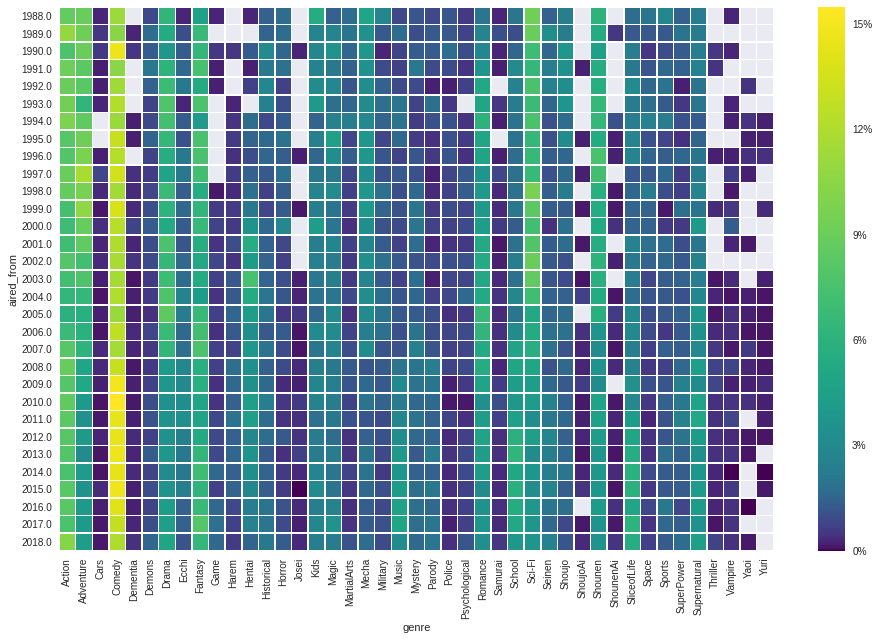

In [124]:
years_genres = years_genres[years_genres.index >= 1988]

f, ax = plt.subplots(figsize=(16, 10))
data = years_genres.div(years_genres.sum(axis=1), axis=0) * 100
cmap = equalize_colormap(plt.cm.viridis, data)
mask = np.zeros_like(years_genres, dtype=np.bool)
mask[years_genres == 0] = True
sns.heatmap(data, mask=mask, linewidths=.5, cmap=cmap, cbar_kws={'format': '%.0f%%'})

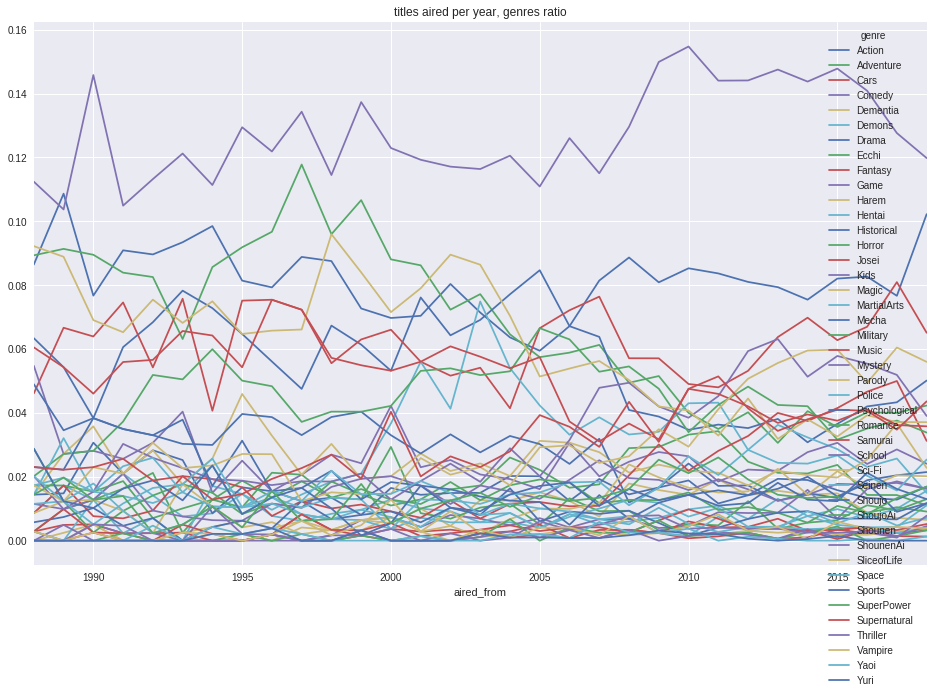

In [125]:
years_genres.div(years_genres.sum(axis=1), axis=0).plot(figsize=(16, 10), title='titles aired per year, genres ratio')

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34]), <a list of 35 Text xticklabel objects>)

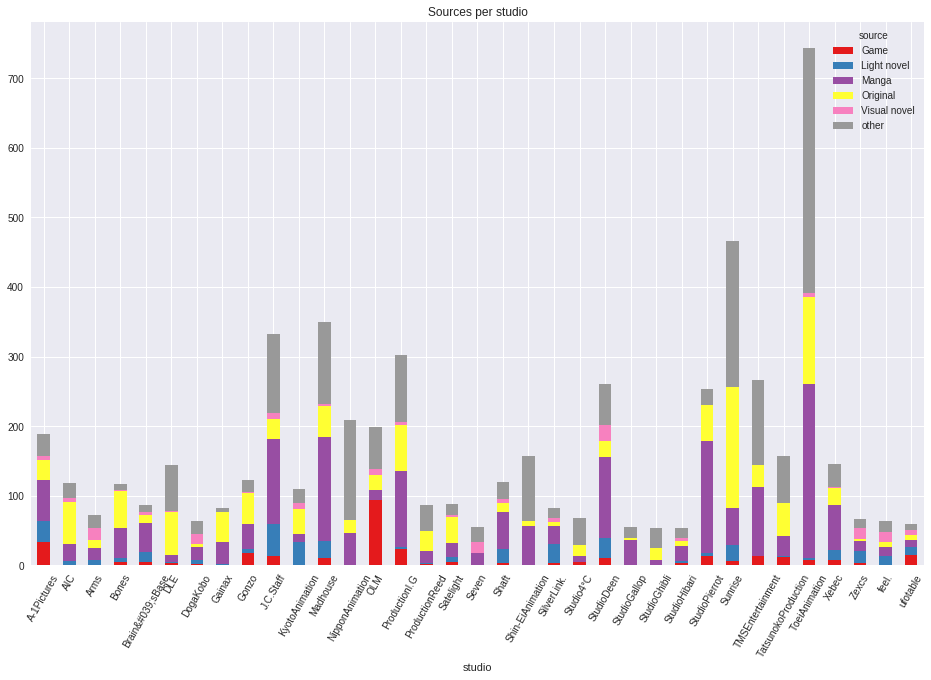

In [126]:
studios_sources = pd.crosstab(animes_studios['studio'], animes_studios['source'])
# keeping only interesting sources
interesting_sources = ['Game', 'Light novel', 'Manga', 'Original', 'Visual novel']
other_sources = list(set(studios_sources.columns) - set(interesting_sources))
studios_sources['other'] = studios_sources[other_sources].sum(axis=1)
studios_sources = studios_sources.drop(other_sources, axis=1)

studios_sources = studios_sources[studios_sources.index.isin(known_studios)]

colors = plt.cm.Set1(np.linspace(0, 1, studios_sources.shape[1]))
studios_sources.plot.bar(stacked=True, figsize=(16, 10), title='Sources per studio', color=colors)
plt.xticks(rotation=60)

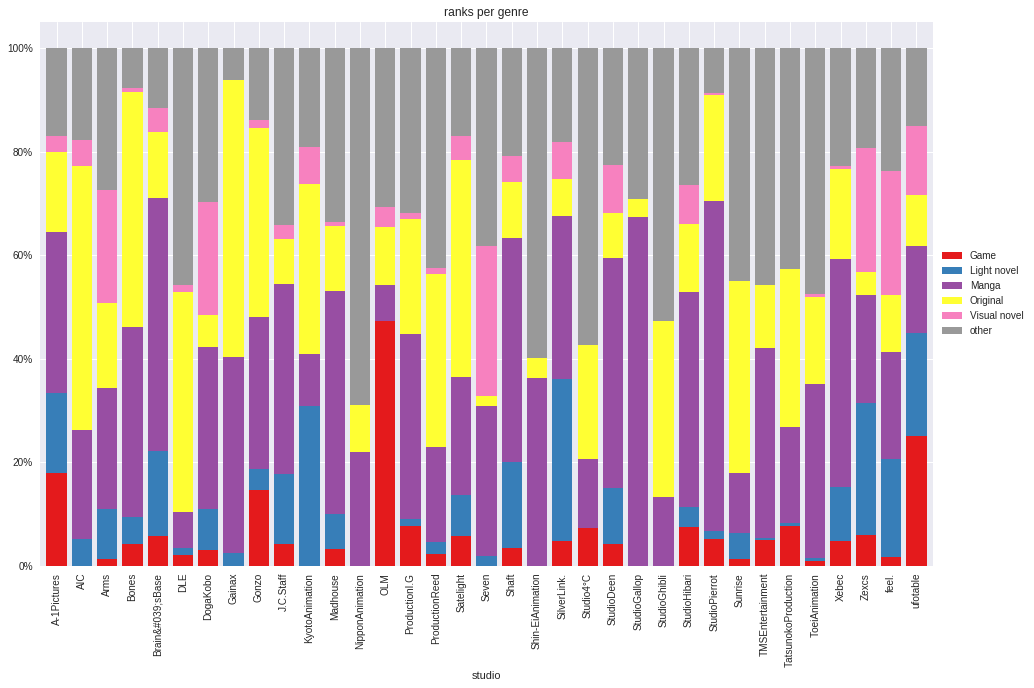

In [127]:
studios_sources.div(studios_sources.sum(axis=1), axis=0).plot(kind='bar', stacked=True, figsize=(16, 10), title='ranks per genre', color=colors, width=0.8)
plt.gca().legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 

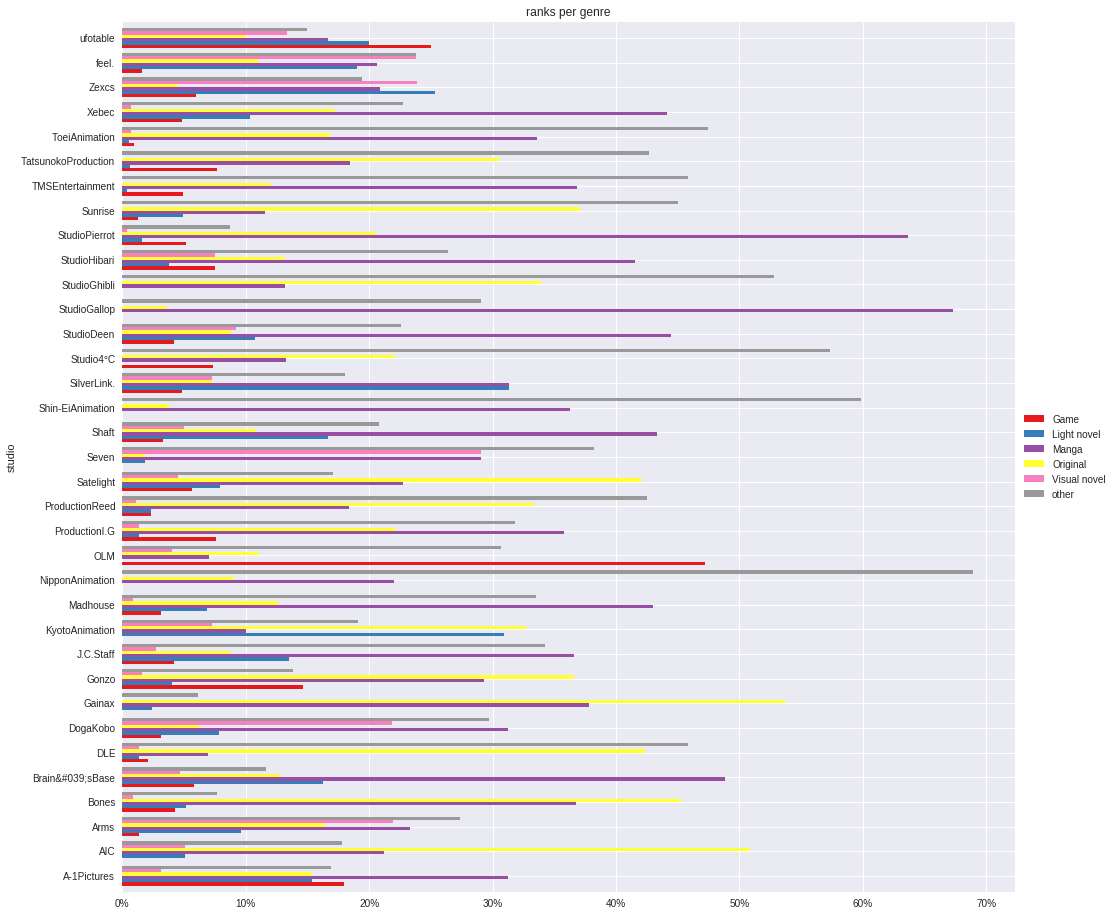

In [128]:
studios_sources.div(studios_sources.sum(axis=1), axis=0).plot(kind='barh', stacked=False, figsize=(16, 16), title='ranks per genre', color=colors, width=0.8)
plt.gca().legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 

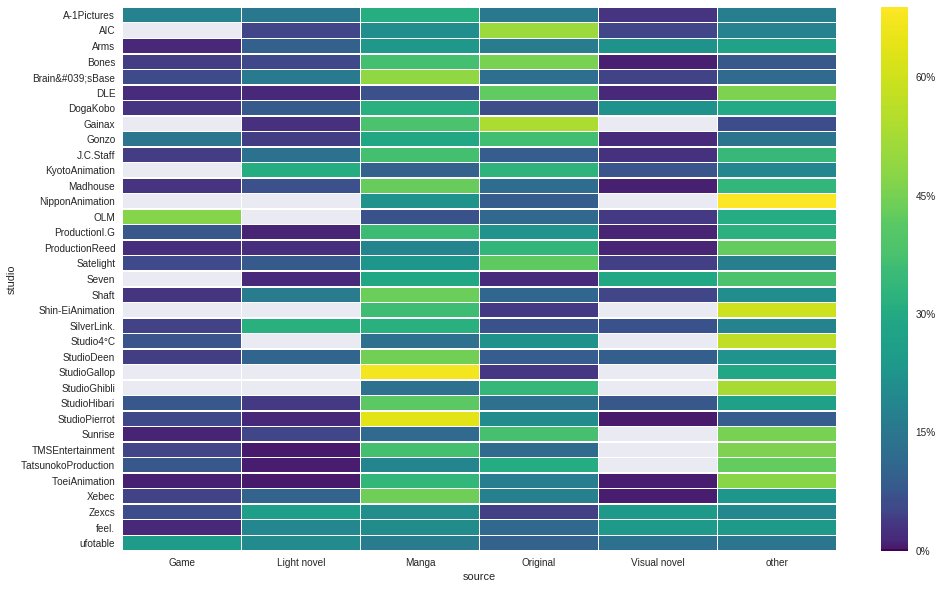

In [129]:
f, ax = plt.subplots(figsize=(16, 10))
data = studios_sources.div(studios_sources.sum(axis=1), axis=0) * 100
cmap = equalize_colormap(plt.cm.viridis, data)
mask = np.zeros_like(studios_sources, dtype=np.bool)
mask[studios_sources == 0] = True
sns.heatmap(data, mask=mask, linewidths=.5, cmap=cmap, cbar_kws={'format': '%.0f%%'})

#### genres similarity based on in how many anime they appear together


In [130]:
genres_animes = pd.crosstab(animes_genres['genre'], animes_genres.index.get_level_values('anime_id'))

In [131]:
genres_animes.head()

col_0      1      5      6      7      8      15     16     17     18     \
genre                                                                      
Action         1      1      1      1      0      1      0      0      1   
Adventure      1      0      1      0      1      0      0      0      0   
Cars           0      0      0      0      0      0      0      0      1   
Comedy         1      0      1      0      0      1      1      1      0   
Dementia       0      0      0      0      0      0      0      0      0   

col_0      19     ...    37895  37896  37897  37902  37904  37905  37908  \
genre             ...                                                      
Action         0  ...        0      0      1      1      0      0      0   
Adventure      0  ...        0      0      1      1      0      1      0   
Cars           0  ...        0      0      0      0      0      0      0   
Comedy         0  ...        0      0      0      1      0      0      1   
Dementia       0  ...        0      0      0      0      0      0      0   

col_0      37914  37915  37916  
genre                           
Action         0      0      0  
Adventure      0      0      0  
Cars           0      0      0  
Comedy         0      0      0  
Dementia       0      0      0  

[5 rows x 11874 columns]

24

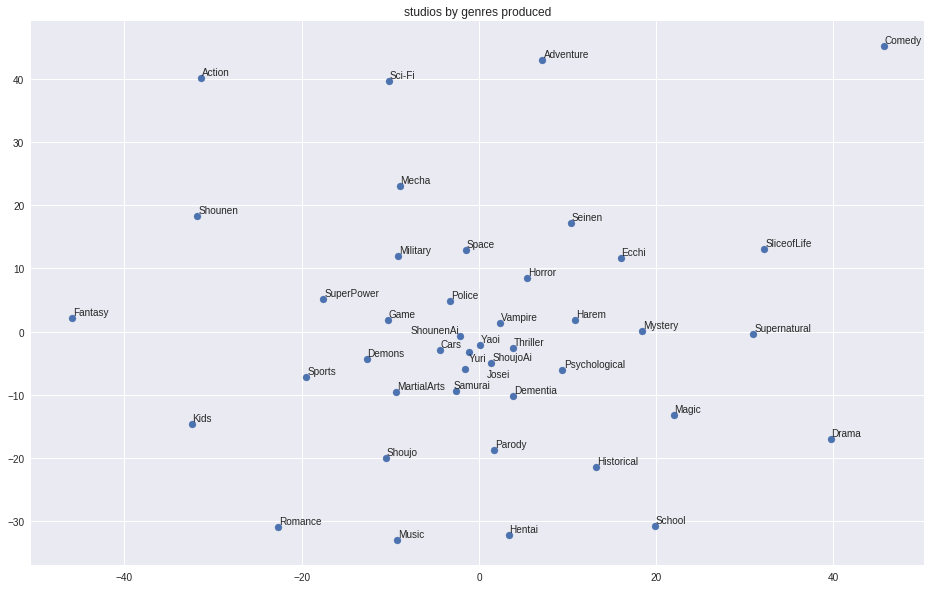

In [132]:
embedder = manifold.MDS(2, max_iter=2000, n_init=5)
embeddings = embedder.fit_transform(genres_animes)
# need to agregate animes_studios because it does not contain duplicities because of genres
plt.figure(figsize=(16, 10))
plt.scatter(embeddings[:, 0], embeddings[:, 1])
plt.title("studios by genres produced")
texts = [plt.text(embeddings[i, 0], embeddings[i, 1], txt) for i, txt in enumerate(genres_animes.index)]
adjust_text(texts)

<IPython.core.display.Javascript object>


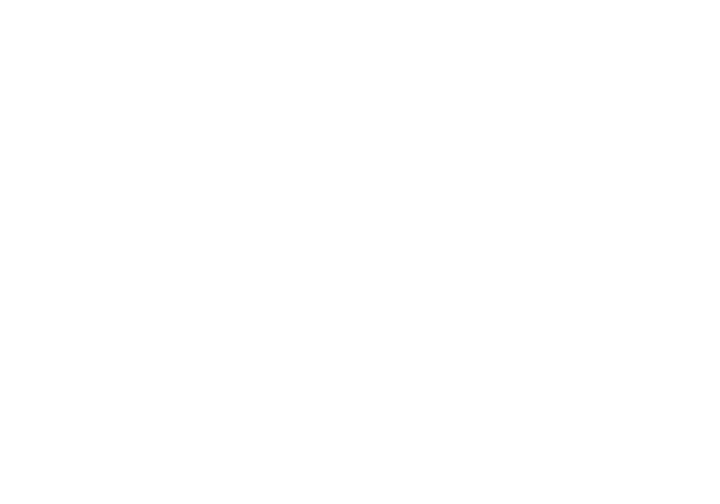

<IPython.core.display.Javascript object>


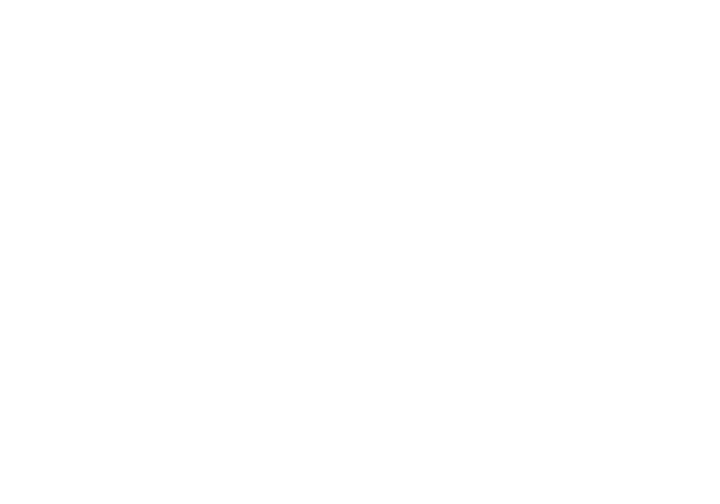

In [143]:
%matplotlib notebook

embedder = manifold.MDS(3, max_iter=2000, n_init=10)
embeddings = embedder.fit_transform(genres_animes)
plt.figure(figsize=(10, 7))
ax = plt.axes(projection='3d')
ax.scatter3D(embeddings[:, 0], embeddings[:, 1], embeddings[:, 2])
#for i, txt in enumerate(genres_animes.index):
#    ax.text(embeddings[i, 0], embeddings[i, 1], embeddings[i, 2], txt)
plt.show()

In [142]:
embeddings

array([[-14.34249236,  42.26645966,  22.8406336 ],
       [  9.74351942,  41.90678119,  -1.61479943],
       [ -0.4115263 ,  -5.5064552 ,   3.78296255],
       [ 59.02391092,  19.59047508, -12.29591549],
       [ -6.29500744, -12.48525915,  -3.81817941],
       [ -9.61403498,   5.36000905, -10.63253272],
       [ 15.04690887, -18.58548301,  34.55942154],
       [ 18.05776198,   5.31081897,  -6.15290164],
       [ -1.0616938 ,  33.42148406, -29.55545616],
       [  7.32644455,   3.44015467,   4.05350819],
       [ 10.07303633,  -5.01975966,  -7.77416027],
       [-26.05047267, -21.20129296,  -0.09183693],
       [-26.41568897,   6.23335327,   3.89539604],
       [-16.75401184,  -3.99403926,  -6.76765204],
       [ -0.43379231,   0.07777481,  -1.67988745],
       [-15.27508162,  -0.81704651, -32.28941497],
       [  5.66628119,  11.24005658, -21.90860096],
       [  0.52419747,   9.70961725,  -2.59676939],
       [-11.09706494,   6.6645248 ,  24.76106605],
       [ -5.44383341,  -6.58431

In [134]:
dists = pdist(genres_animes, 'euclidean')
dists_m = squareform(dists)
dists_df = pd.DataFrame(dists_m)
dists_df.columns = genres_animes.index
dists_df.index = genres_animes.index
dists_df

genre             Action  Adventure       Cars     Comedy   Dementia  \
genre                                                                  
Action          0.000000  57.314920  54.110997  75.246262  55.587768   
Adventure      57.314920   0.000000  47.549974  70.816665  49.101935   
Cars           54.110997  47.549974   0.000000  68.058798  16.852300   
Comedy         75.246262  70.816665  68.058798   0.000000  68.789534   
Dementia       55.587768  49.101935  16.852300  68.789534   0.000000   
Demons         54.175640  48.682646  20.174241  68.563839  22.956481   
Drama          61.708994  57.887823  44.721360  74.659226  45.891176   
Ecchi          56.222771  52.191953  26.776856  65.383484  28.861739   
Fantasy        59.363288  51.039201  48.332184  71.777434  49.355851   
Game           54.671748  48.394215  18.520259  68.694978  21.702534   
Harem          55.740470  50.179677  20.469489  66.910388  23.259407   
Hentai         61.806149  56.187187  32.341923  73.959448  34.117444   
Historical     57.140179  51.107729  29.068884  70.731888  31.032241   
Horror         54.772256  49.487372  20.736441  69.310894  22.538855   
Josei          54.359912  47.728398  12.609520  67.638746  16.763055   
Kids           62.777384  53.103672  36.152455  70.505319  38.170669   
Magic          56.133769  50.497525  30.182777  68.271517  32.140317   
MartialArts    52.554733  47.947888  18.973666  68.308125  21.908902   
Mecha          52.038447  50.447993  30.692019  70.866071  32.557641   
Military       52.782573  49.989999  23.151674  70.114193  25.534291   
Music          62.369865  56.964901  34.088121  73.607065  35.014283   
Mystery        55.578773  50.000000  25.396850  68.956508  27.331301   
Parody         56.824291  51.361464  23.302360  65.169011  25.592968   
Police         54.018515  47.801674  16.673332  67.557383  20.149442   
Psychological  55.226805  49.386233  18.654758  69.108610  20.396078   
Romance        62.417946  57.070132  39.824616  67.141641  41.231056   
Samurai        53.432200  47.979162  15.394804  68.022055  18.947295   
School         61.676576  58.728187  37.389838  65.650590  38.935845   
Sci-Fi         53.721504  54.488531  45.343136  72.965745  46.497312   
Seinen         55.461698  51.604263  26.000000  67.364679  28.913665   
Shoujo         57.948253  51.681718  26.076810  68.716810  28.284271   
ShoujoAi       54.332311  47.759816  12.165525  67.631354  16.370706   
Shounen        55.371473  50.941143  40.644803  66.151342  42.544095   
ShounenAi      54.433446  47.749346  12.529964  67.594378  16.643317   
SliceofLife    64.614240  58.532043  37.589892  66.370174  39.204592   
Space          53.646994  48.590122  21.447611  69.339743  24.124676   
Sports         56.480085  51.623638  23.108440  68.190908  26.944387   
SuperPower     51.701064  49.638695  24.020824  67.830672  26.438608   
Supernatural   56.142675  54.304696  35.213634  69.899928  36.496575   
Thriller       54.240206  47.947888  13.266499  68.176242  17.029386   
Vampire        54.064776  48.145612  14.247807  67.771675  18.027756   
Yaoi           54.258640  47.486840  10.954451  67.734777  15.556349   
Yuri           54.203321  47.402532  10.583005  67.734777  15.297059   

genre             Demons      Drama      Ecchi    Fantasy       Game  \
genre                                                                  
Action         54.175640  61.708994  56.222771  59.363288  54.671748   
Adventure      48.682646  57.887823  52.191953  51.039201  48.394215   
Cars           20.174241  44.721360  26.776856  48.332184  18.520259   
Comedy         68.563839  74.659226  65.383484  71.777434  68.694978   
Dementia       22.956481  45.891176  28.861739  49.355851  21.702534   
Demons          0.000000  46.957428  30.232433  47.906158  24.083189   
Drama          46.957428   0.000000  49.789557  59.346440  46.636895   
Ecchi          30.232433  49.789557   0.000000  51.293274  29.732137   
Fantasy        47.906158  59.346440  51

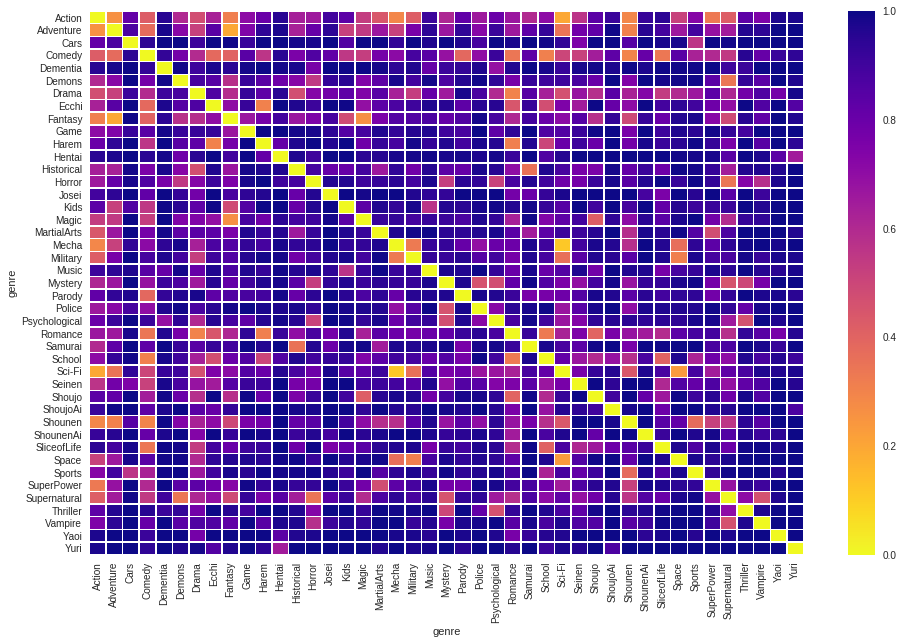

In [185]:
%matplotlib inline
dists = pdist(genres_animes, 'cosine')
dists_m = squareform(dists) ** 3
dists_df = pd.DataFrame(dists_m)
dists_df.columns = genres_animes.index
dists_df.index = genres_animes.index

f, ax = plt.subplots(figsize=(16, 10))
sns.heatmap(dists_df, linewidths=.5, cmap=plt.cm.plasma_r)

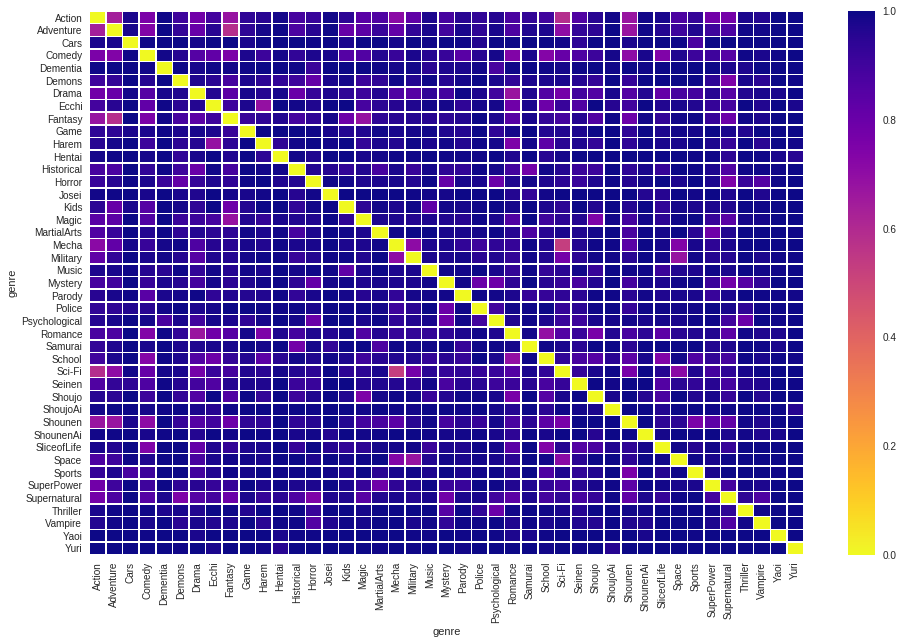

In [136]:
%matplotlib inline
dists = pdist(genres_animes, 'dice')
dists_m = squareform(dists)
dists_df = pd.DataFrame(dists_m)
dists_df.columns = genres_animes.index
dists_df.index = genres_animes.index

f, ax = plt.subplots(figsize=(16, 10))
sns.heatmap(dists_df, linewidths=.5, cmap=plt.cm.plasma_r)

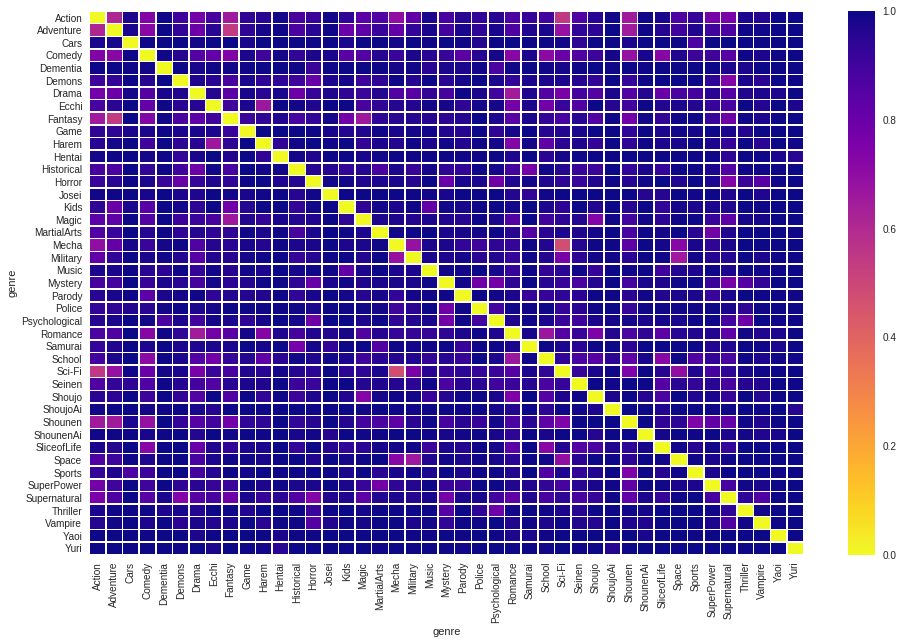

In [182]:
%matplotlib inline
dists = pdist(genres_animes, lambda x, y: 1 - (x & y).sum() / (x | y).sum())
dists_m = squareform(dists) ** 2
dists_df = pd.DataFrame(dists_m)
dists_df.columns = genres_animes.index
dists_df.index = genres_animes.index

f, ax = plt.subplots(figsize=(16, 10))
sns.heatmap(dists_df, linewidths=.5, cmap=plt.cm.plasma_r)

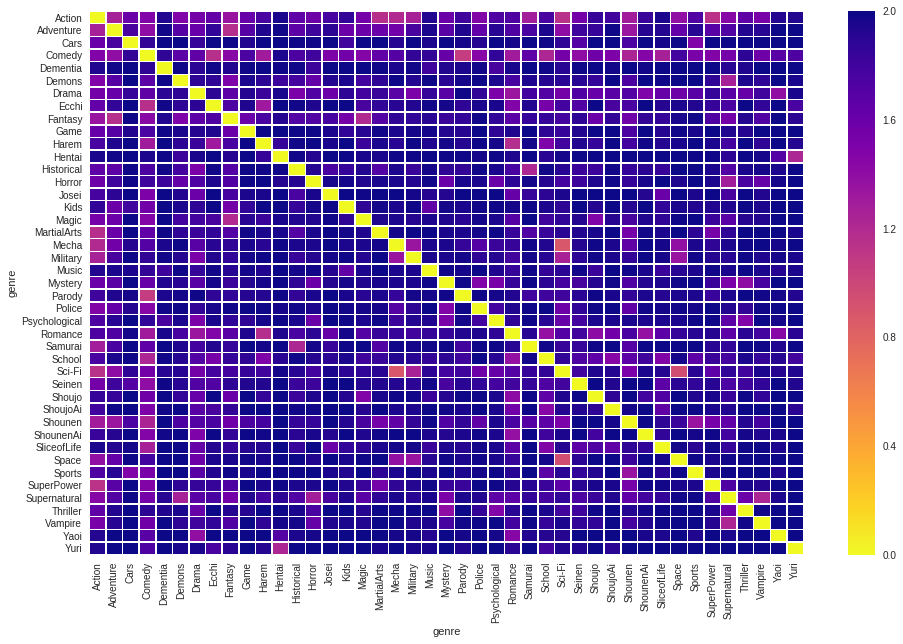

In [181]:
%matplotlib inline
dists = pdist(genres_animes, lambda x, y: 2 - ((x & y).sum() / x.sum() + (x & y).sum() / y.sum()))
dists_m = squareform(dists)
dists_df = pd.DataFrame(dists_m)
dists_df.columns = genres_animes.index
dists_df.index = genres_animes.index

f, ax = plt.subplots(figsize=(16, 10))
sns.heatmap(dists_df, linewidths=.5, cmap=plt.cm.plasma_r)

## using normalized social distance
by Šlerka http://databoutique.cz/

![title](http://stromateis.eu/dbblog/nsd.png)
well, basically it is the normalized web distance
Interesting fact is that it gives infinite distance for disjunctive genres, allowing to produce sparse graph for embedding

/home.stud/racinmat/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


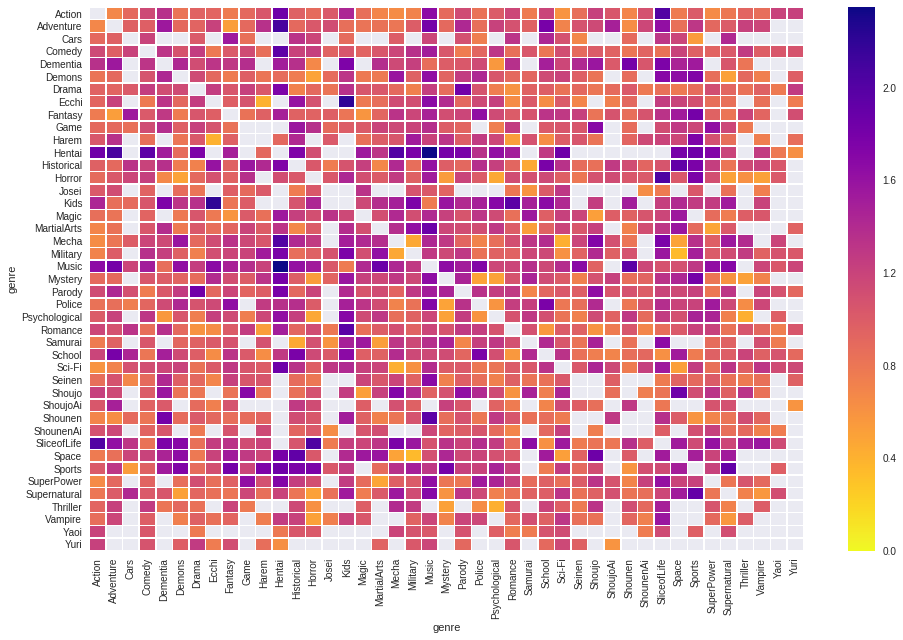

In [319]:
def nsd(x, y):
    return (max(np.log(x.sum()), np.log(y.sum())) - np.log((x & y).sum())) / (np.log(x.size) - min(np.log(x.sum()), np.log(y.sum())))

%matplotlib inline
dists = pdist(genres_animes, lambda x, y: nsd(x, y))
dists_m = squareform(dists)
dists_m[dists_m == np.inf] = 0  # infinities mess color scale

dists_df = pd.DataFrame(dists_m)
dists_df.columns = genres_animes.index
dists_df.index = genres_animes.index

f, ax = plt.subplots(figsize=(16, 10))
mask = np.zeros_like(dists_df, dtype=np.bool)
mask[dists_df == 0] = True
sns.heatmap(dists_df, mask=mask, linewidths=.5, cmap=plt.cm.plasma_r)

In [262]:
dists_df

genre            Action  Adventure      Cars    Comedy  Dementia    Demons  \
genre                                                                        
Action         0.000000   0.685547  0.904336  1.147617  1.349589  0.823032   
Adventure      0.685547   0.000000  0.965000  0.977025  1.552548  0.903734   
Cars           0.904336   0.965000  0.000000  1.208990       inf       inf   
Comedy         1.147617   0.977025  1.208990  0.000000  1.311628  1.066087   
Dementia       1.349589   1.552548       inf  1.311628  0.000000  1.422226   
Demons         0.823032   0.903734       inf  1.066087  1.422226  0.000000   
Drama          0.948375   0.940295  1.019934  1.255756  1.124691  1.142146   
Ecchi          0.927109   1.211031       inf  0.779524  1.316470  0.911531   
Fantasy        0.761610   0.525611  1.548180  1.021321  1.287052  0.765457   
Game           0.901741   0.905676  0.844510  1.136667  1.375905  0.979853   
Harem          1.043414   1.352348       inf  0.856413       inf  0.815717   
Hentai         1.850234   2.079123       inf  1.952831  1.518587  0.871843   
Historical     0.966235   0.905936  1.331523  1.205418  1.362179  0.759110   
Horror         0.880651   1.029705  1.175058  1.230669  0.669786  0.486735   
Josei          1.023409   1.119119       inf  0.953226       inf  0.875673   
Kids           1.446241   0.853163  0.887719  1.053440  1.753714  1.317807   
Magic          0.860410   0.823109       inf  0.944015       inf  0.787049   
MartialArts    0.695908   0.831399       inf  1.038506  1.383964  0.772223   
Mecha          0.646852   0.803647  0.998500  1.176681  1.153259  1.578023   
Military       0.707083   0.996107       inf  1.349734  1.234163  0.968300   
Music          1.667664   1.813589  1.181429  1.519131  0.866436  1.639005   
Mystery        0.890553   0.906390       inf  1.042204  0.991046  0.943093   
Parody         1.134119   1.424500  1.092906  0.755581  1.031796  1.261331   
Police         0.832492   0.856760  0.746499  0.925027  1.140252  1.429080   
Psychological  1.005932   1.215439       inf  1.307609  0.563153  1.052777   
Romance        1.167242   1.089793  1.328490  0.853019  1.358461  0.901662   
Samurai        0.764686   0.957496       inf  1.037821       inf  0.922185   
School         1.189983   1.793993  1.440482  0.798473  1.495740  1.138623   
Sci-Fi         0.593675   0.713696  1.082707  1.118722  1.170877  1.206967   
Seinen         0.858848   1.076656  0.684138  0.892483  1.416506  0.976948   
Shoujo         1.220525   1.147295       inf  1.008363  1.571742  0.823672   
ShoujoAi       1.045175   1.487897       inf  0.952487  1.026228       inf   
Shounen        0.694101   0.641323  0.889983  0.811613  1.814586  0.875961   
ShounenAi      1.087100   1.170315       inf  0.938170  1.051834       inf   
SliceofLife    2.010707   1.629684  1.304077  0.826298  1.768890  1.696375   
Space          0.768624   0.852722  1.191501  1.202994  1.460542  1.652977   
Sports         1.014544   1.303704  0.537302  0.967156  1.539334  1.742151   
SuperPower     0.652140   0.907936       inf  0.936097       inf  0.854215   
Supernatural   0.793536   1.005339  1.414900  1.022847  1.052974  0.510869   
Thriller       0.934197   1.224403       inf  1.268651  0.813323  0.911432   
Vampire        0.866939   1.179723       inf  0.982092       inf  0.740266   
Yaoi           1.202691        inf       inf  1.039254       inf       inf   
Yuri           1.224438        inf       inf  1.067309       inf  0.972895   

genre             Drama     Ecchi   Fantasy      Game    ...     ShounenAi  \
genre                                                    ...                 
Action         0.948375  0.927109  0.761610  0.901741    ...      1.087100   
Adventure      0.940295  1.211031  0.525611  0.905676    ...      1.170315   
Cars           1.019934       inf  1.548180  0.844510    ...           inf   
Comedy         1.255756  0.779524  1.021321  1.136667    ...      0.938170   
Dementia       1.1246

In [163]:
x = genres_animes.loc['Mecha']
y = genres_animes.loc['Sci-Fi']
y = genres_animes.loc['Mecha']
print(1 - (x & y).sum() / (x | y).sum())
print((x & y).sum() / (x | y).sum())


0.0
1.0


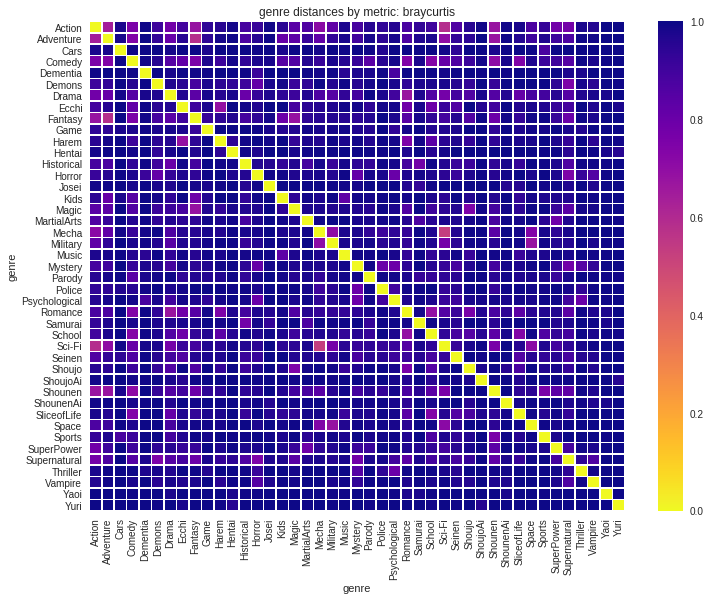

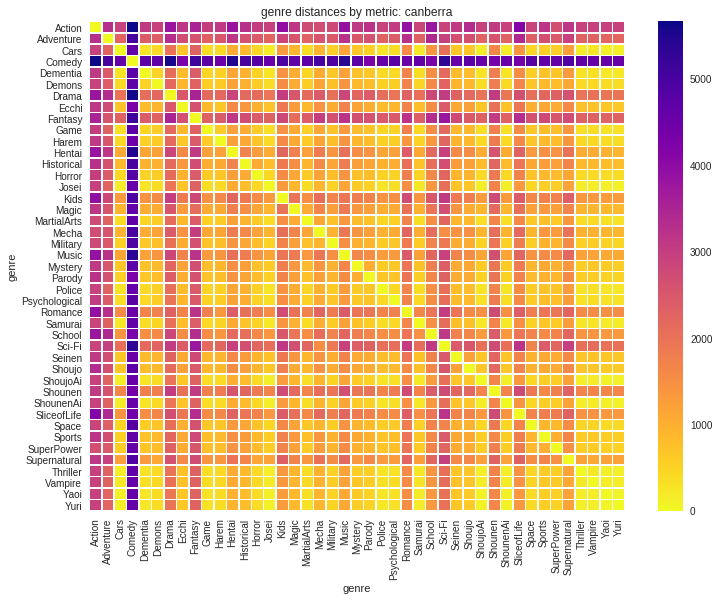

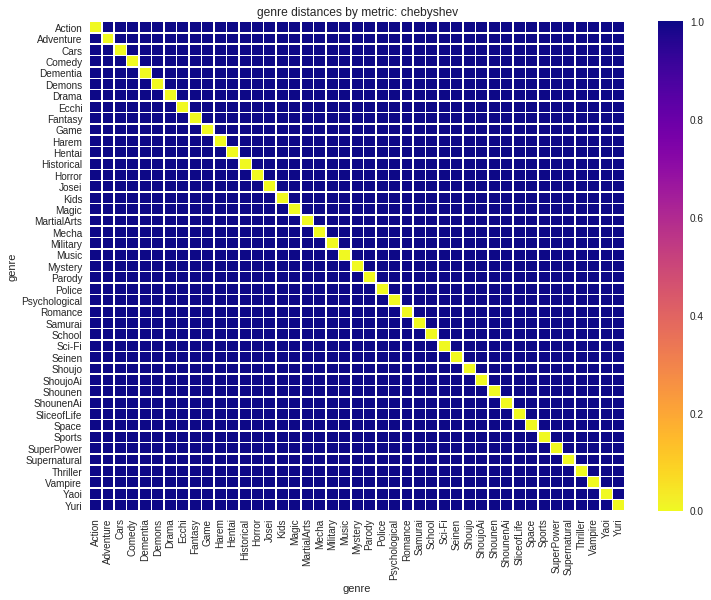

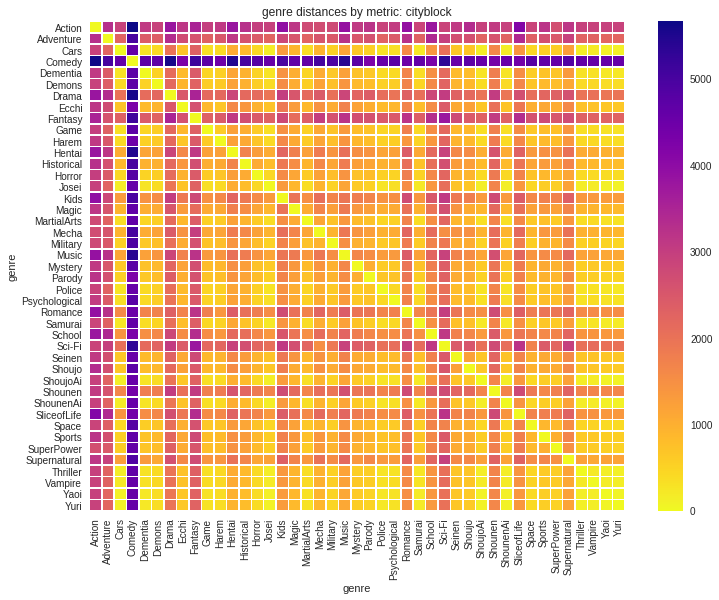

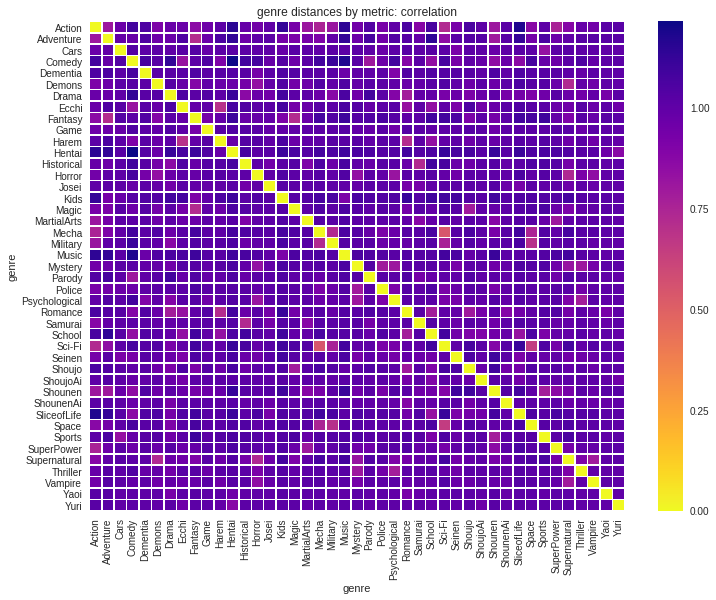

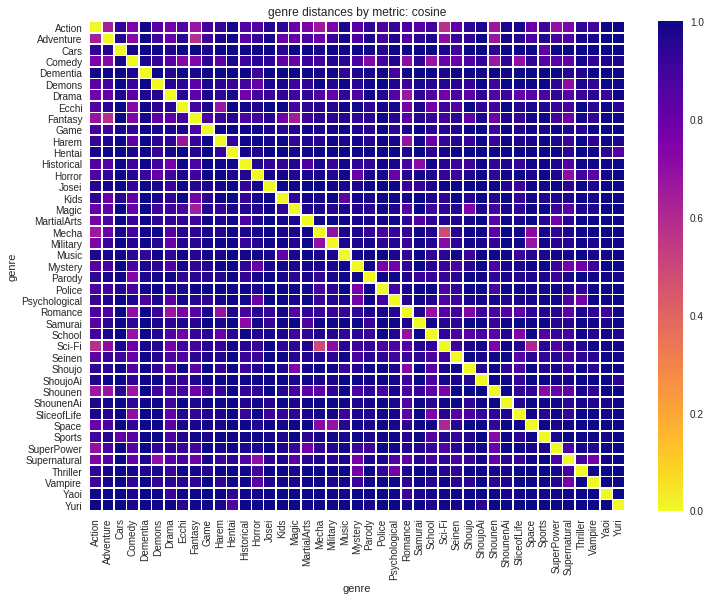

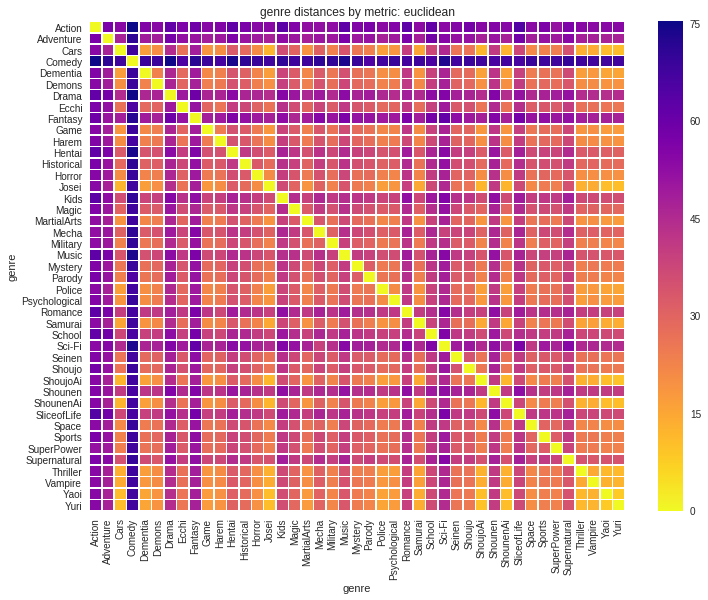

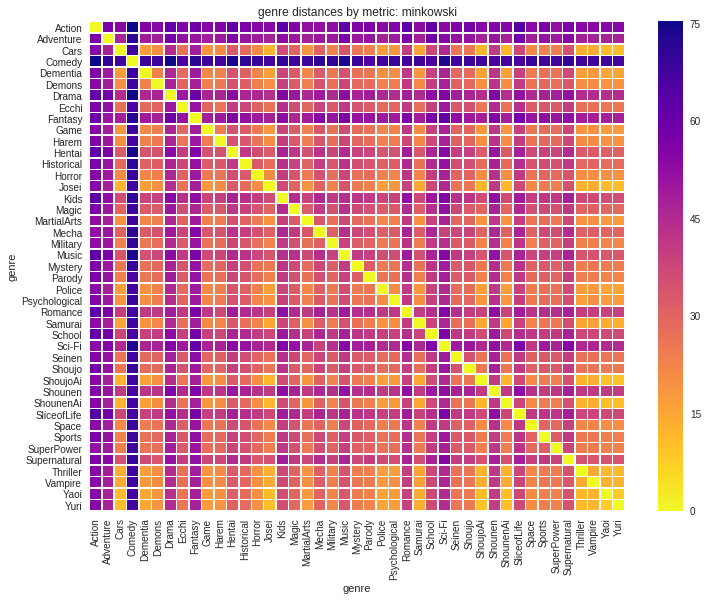

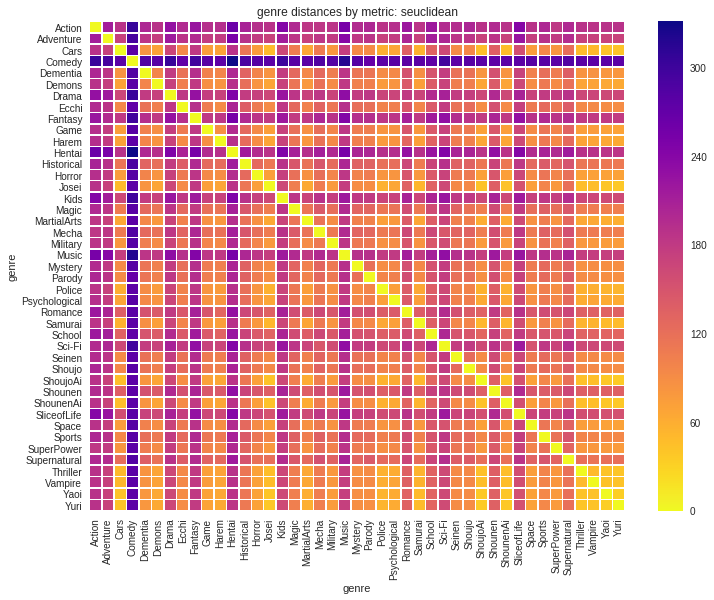

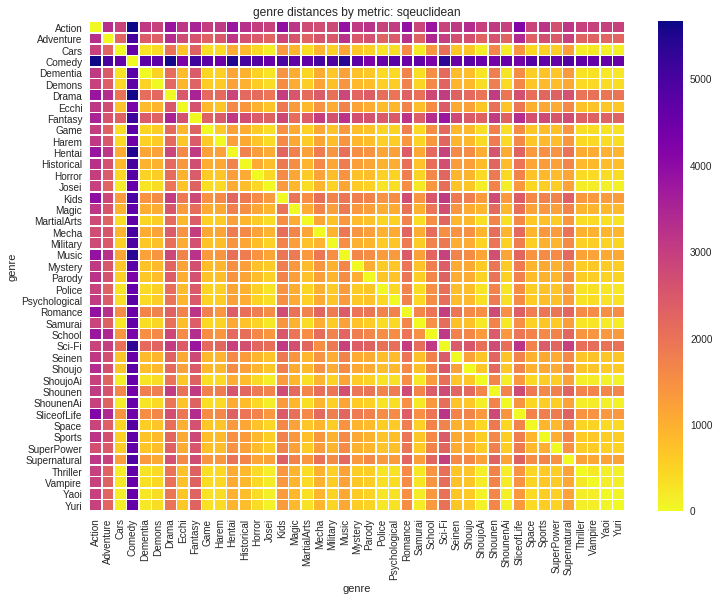

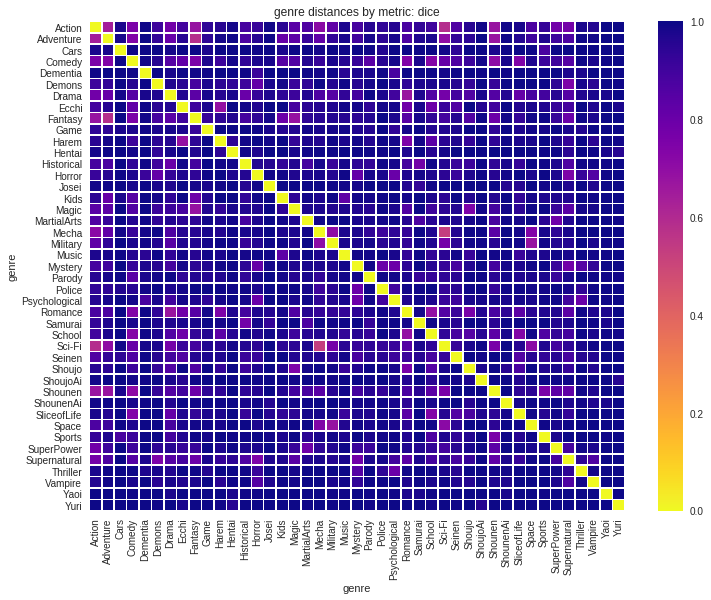

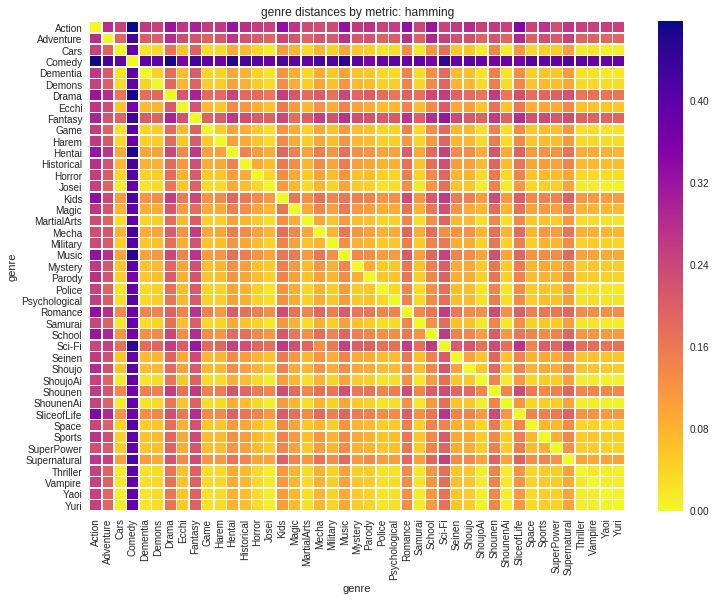

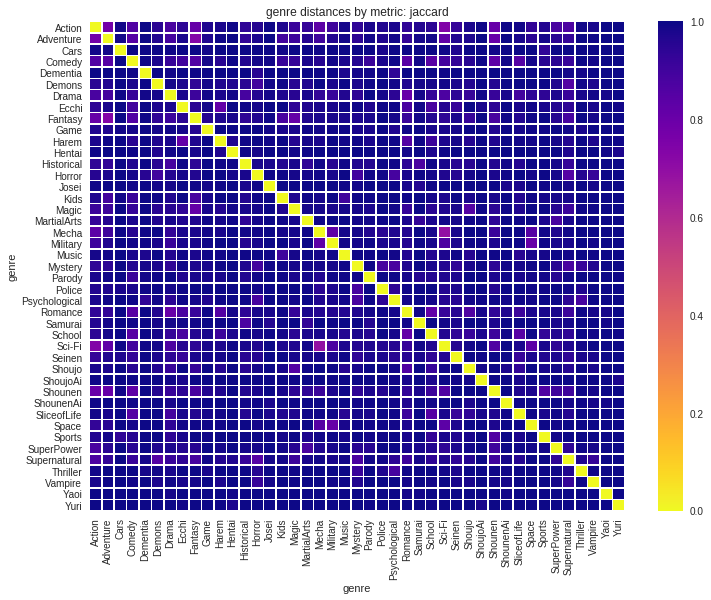

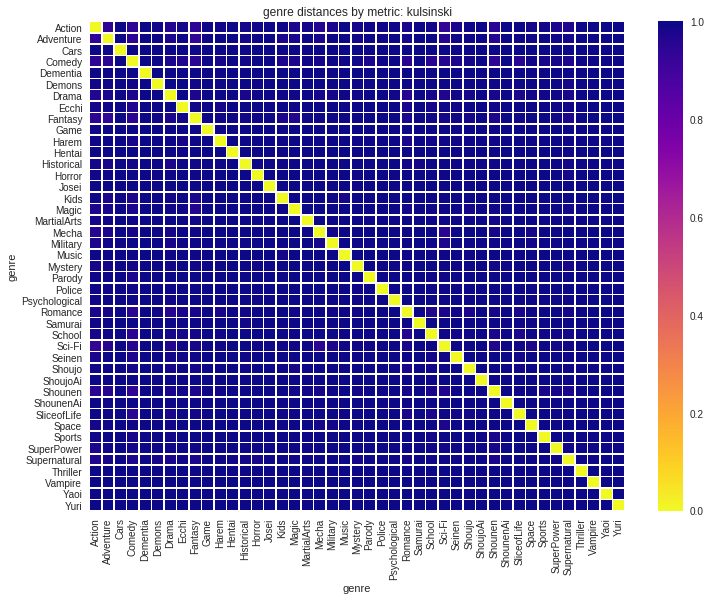

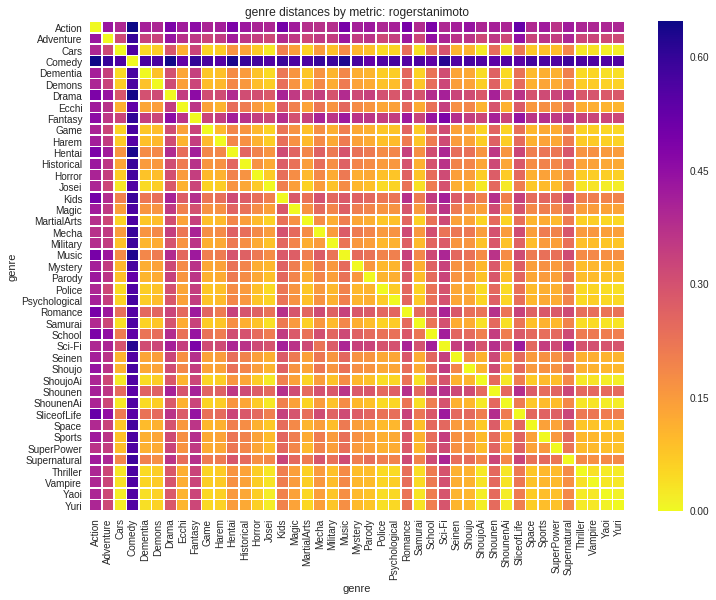

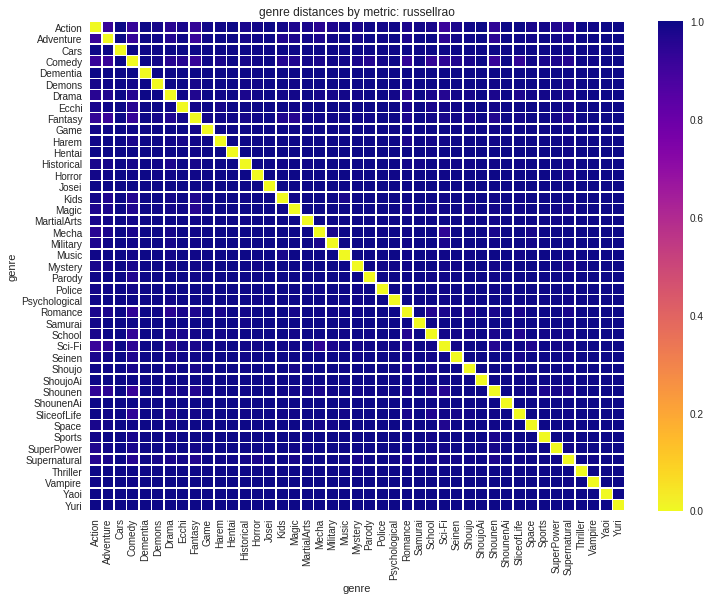

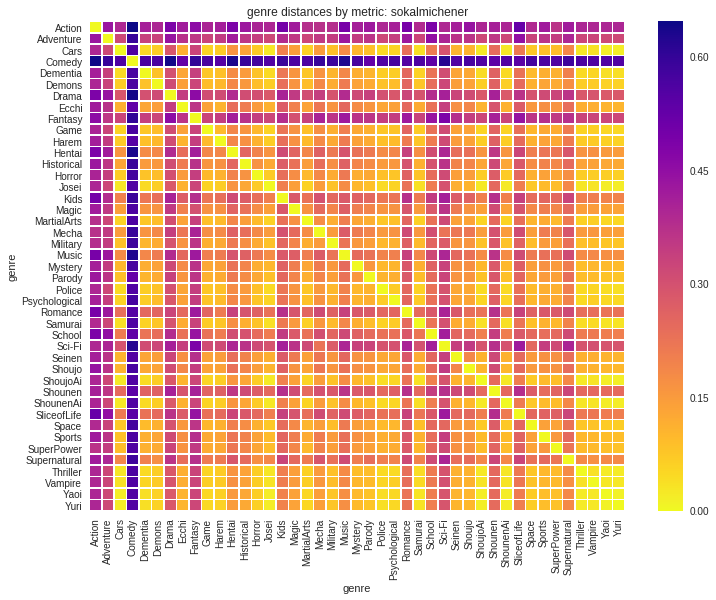

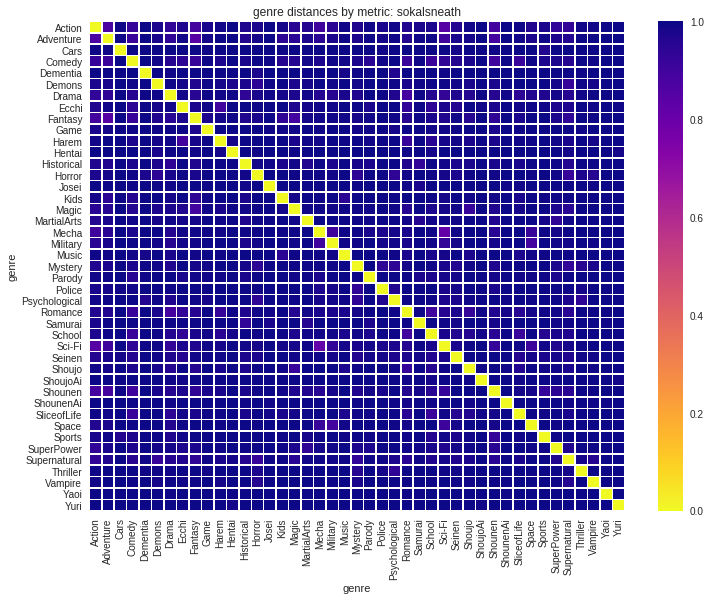

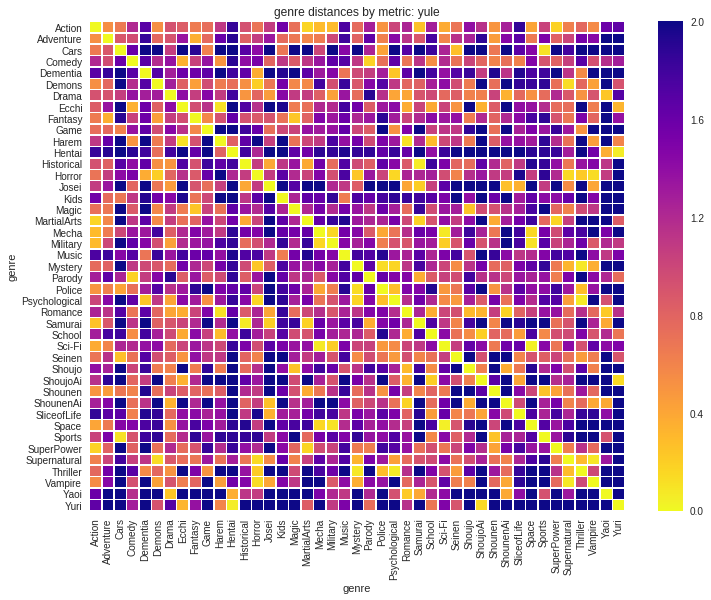

In [137]:
def show_distances(metric):
    dists = pdist(genres_animes, metric)
    dists_m = squareform(dists)
    dists_df = pd.DataFrame(dists_m)
    dists_df.columns = genres_animes.index
    dists_df.index = genres_animes.index

    f, ax = plt.subplots(figsize=(12, 9))
    plt.title('genre distances by metric: {}'.format(metric))
    sns.heatmap(dists_df, linewidths=.5, cmap=plt.cm.plasma_r)
    plt.show()
    
metrics = ['braycurtis', 'canberra', 'chebyshev', 'cityblock', 'correlation', 'cosine', 'euclidean', 'minkowski', 
        'seuclidean', 'sqeuclidean', 'dice', 'hamming', 'jaccard', 'kulsinski', 'rogerstanimoto', 'russellrao',
        'sokalmichener', 'sokalsneath', 'yule']

for metric in metrics:
    show_distances(metric)

6

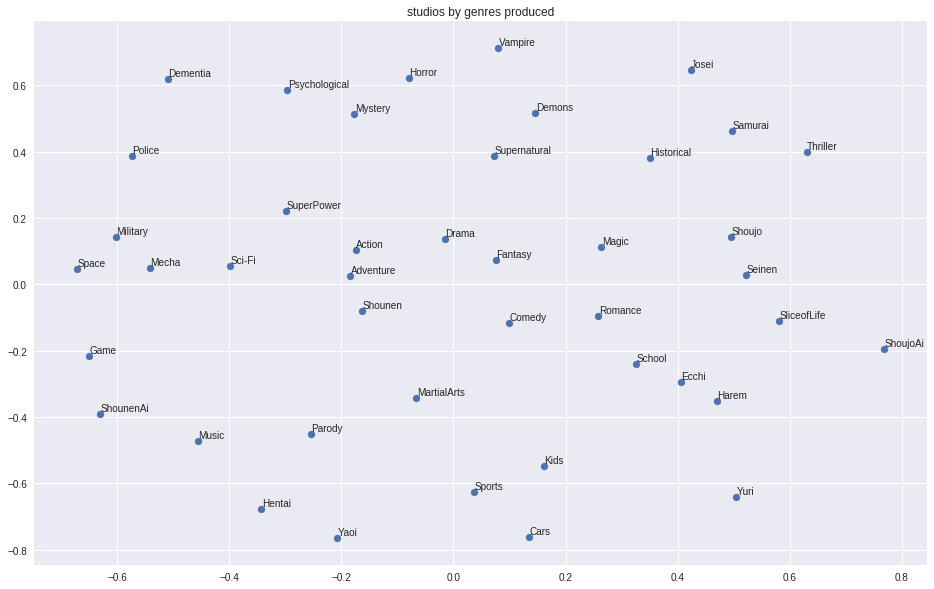

In [191]:
%matplotlib inline

dists = pdist(genres_animes, 'cosine')
dists_m = squareform(dists) ** 3
embedder = manifold.MDS(2, max_iter=2000, n_init=5, dissimilarity='precomputed')
embeddings = embedder.fit_transform(dists_m)
# need to agregate animes_studios because it does not contain duplicities because of genres
plt.figure(figsize=(16, 10))
plt.scatter(embeddings[:, 0], embeddings[:, 1])
plt.title("studios by genres produced")
texts = [plt.text(embeddings[i, 0], embeddings[i, 1], txt) for i, txt in enumerate(genres_animes.index)]
adjust_text(texts)

6

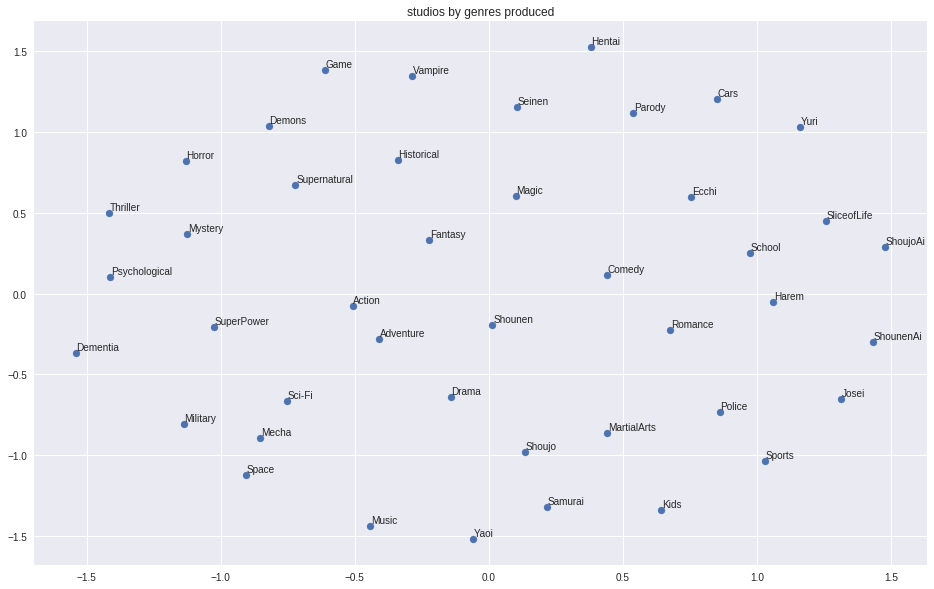

In [189]:
%matplotlib inline

dists = pdist(genres_animes, lambda x, y: 2 - ((x & y).sum() / x.sum() + (x & y).sum() / y.sum()))
dists_m = squareform(dists)
embedder = manifold.MDS(2, max_iter=2000, n_init=5, dissimilarity='precomputed')
embeddings = embedder.fit_transform(dists_m)
# need to agregate animes_studios because it does not contain duplicities because of genres
plt.figure(figsize=(16, 10))
plt.scatter(embeddings[:, 0], embeddings[:, 1])
plt.title("studios by genres produced")
texts = [plt.text(embeddings[i, 0], embeddings[i, 1], txt) for i, txt in enumerate(genres_animes.index)]
adjust_text(texts)

<IPython.core.display.Javascript object>


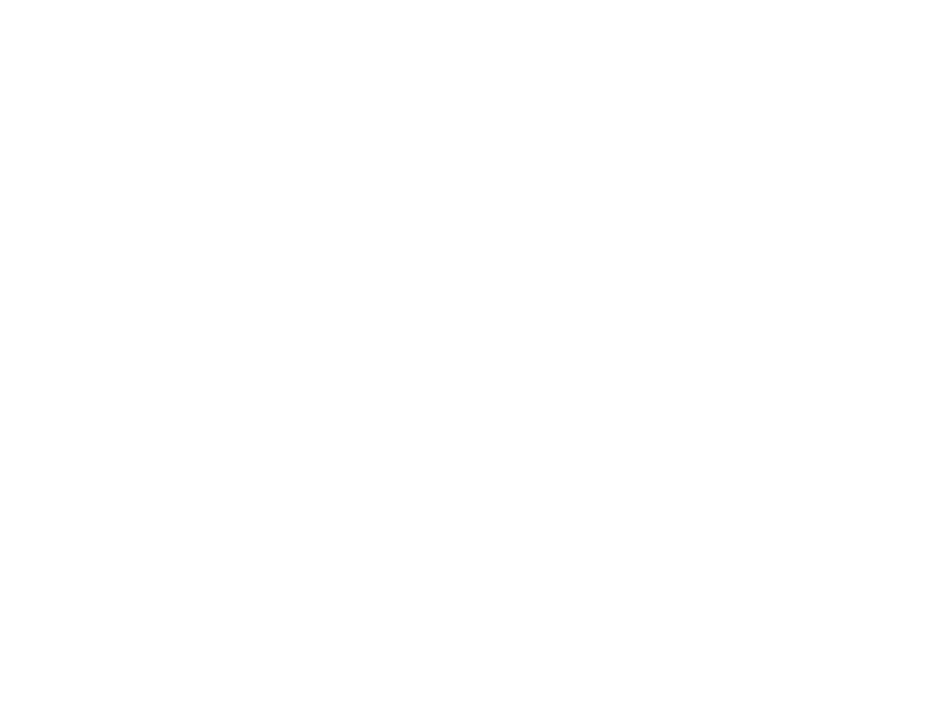

<IPython.core.display.Javascript object>


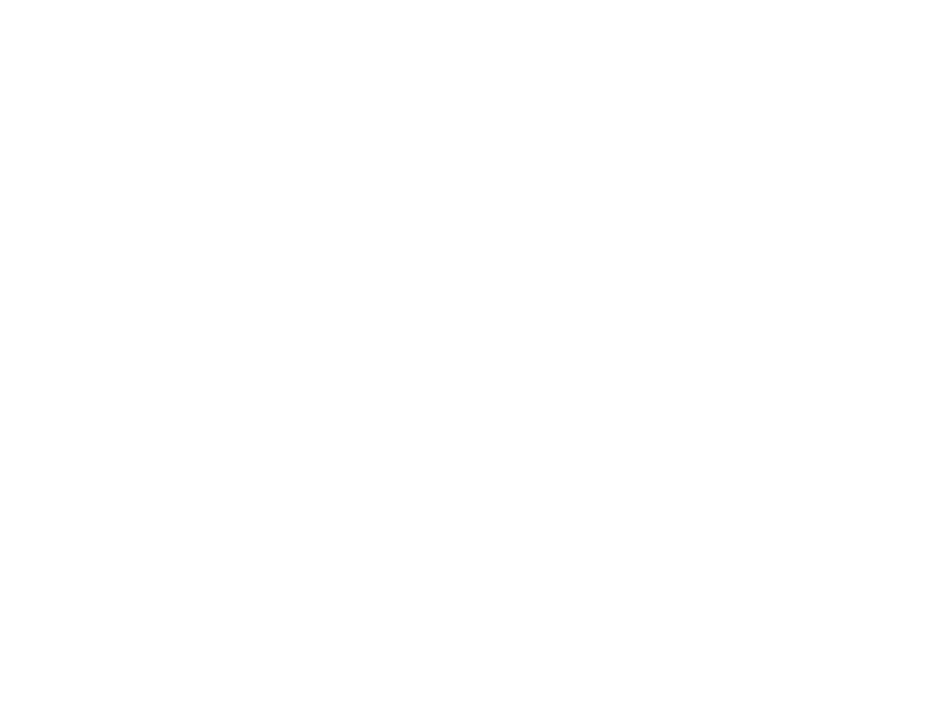

In [187]:
%matplotlib notebook

embedder = manifold.MDS(3, max_iter=2000, n_init=10, dissimilarity='precomputed')
embeddings = embedder.fit_transform(dists_m)

plt.figure(figsize=(13, 10))

ax = plt.axes(projection='3d')
ax.scatter3D(embeddings[:, 0], embeddings[:, 1], embeddings[:, 2])
for i, txt in enumerate(genres_animes.index):
    ax.text(embeddings[i, 0], embeddings[i, 1], embeddings[i, 2], txt)
plt.show()

In [188]:
embeddings

array([[ 0.19165725,  0.1103272 , -0.19301015],
       [ 0.3684717 ,  0.16587767, -0.06338227],
       [ 0.55409923, -0.39731993,  0.29794503],
       [-0.0112777 ,  0.01099661,  0.13004856],
       [-0.72045091, -0.07320944, -0.19389258],
       [-0.0885271 ,  0.5824233 , -0.13582313],
       [ 0.04372953, -0.12701871, -0.07696947],
       [-0.43350324,  0.17709352,  0.21518481],
       [ 0.22517892,  0.30037882,  0.12265768],
       [ 0.63997662, -0.25105494, -0.06718344],
       [-0.38751482,  0.31716271,  0.32150969],
       [-0.10358097,  0.6890781 ,  0.3005788 ],
       [ 0.09867756, -0.45051235, -0.24367175],
       [-0.33919787,  0.34912468, -0.3718486 ],
       [-0.17124502, -0.67872188, -0.11709615],
       [ 0.56992946,  0.18010767,  0.31755372],
       [ 0.17554585,  0.42711634,  0.26841218],
       [ 0.30068455, -0.49377368, -0.01491821],
       [ 0.39786153,  0.04225544, -0.42331968],
       [ 0.36139654,  0.17602553, -0.49253899],
       [ 0.39049786,  0.06958238,  0.567

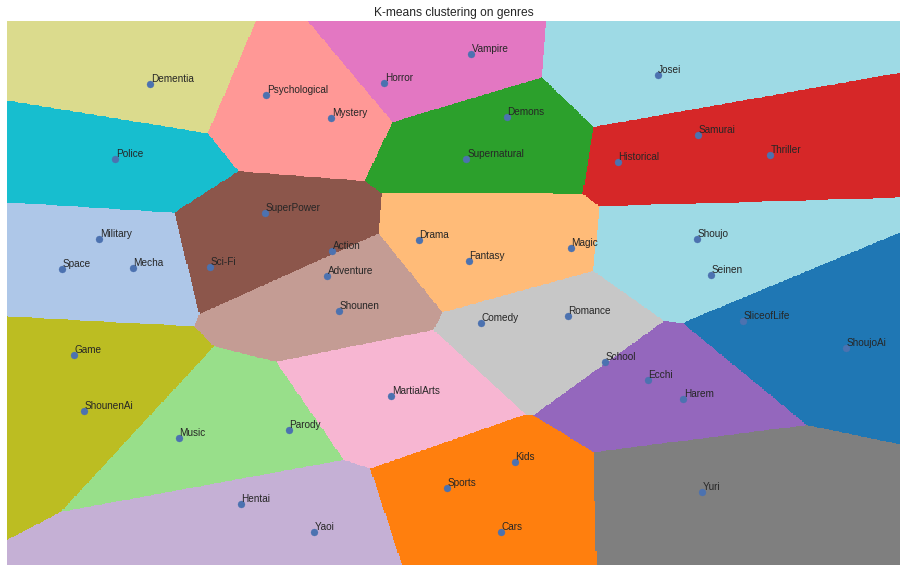

In [192]:
from sklearn.cluster import KMeans

kmeans = KMeans(init='k-means++', n_clusters=21, n_init=10)
kmeans.fit(embeddings)

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .002     # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = embeddings[:, 0].min() - 0.1, embeddings[:, 0].max() + 0.1
y_min, y_max = embeddings[:, 1].min() - 0.1, embeddings[:, 1].max() + 0.1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(figsize=(16, 10))
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.tab20,
           aspect='auto', origin='lower')

plt.scatter(embeddings[:, 0], embeddings[:, 1])
#plt.plot(embeddings[:, 0], embeddings[:, 1], 'k.', markersize=2)
# Plot the centroids as a white X
plt.title('K-means clustering on genres')

texts = [plt.text(embeddings[i, 0], embeddings[i, 1], txt) for i, txt in enumerate(genres_animes.index)]
adjust_text(texts)

plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

In [247]:
from scipy.cluster.hierarchy import dendrogram, linkage

# generate the linkage matrix 
# squareform transfers between condensed and redundant distance form
dists = pdist(genres_animes, 'cosine')
dists_m = squareform(dists) ** 3
Z = linkage(squareform(dists_m), 'ward')

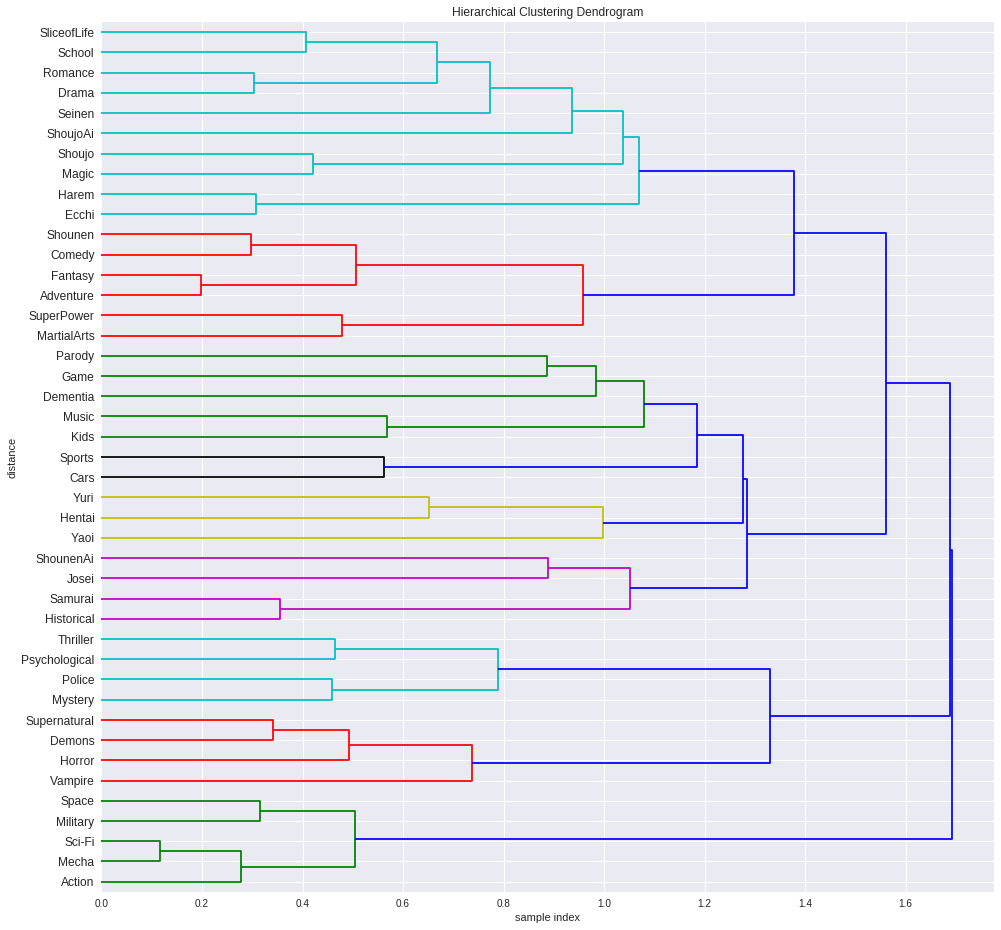

In [250]:
# calculate full dendrogram
plt.figure(figsize=(16, 16))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(
    Z,
#    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=12.,  # font size for the x axis labels
    orientation='right',
    labels=genres_animes.index
)
plt.show()

In [260]:
np.log(0)

/home.stud/racinmat/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


-inf

/home.stud/racinmat/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


6

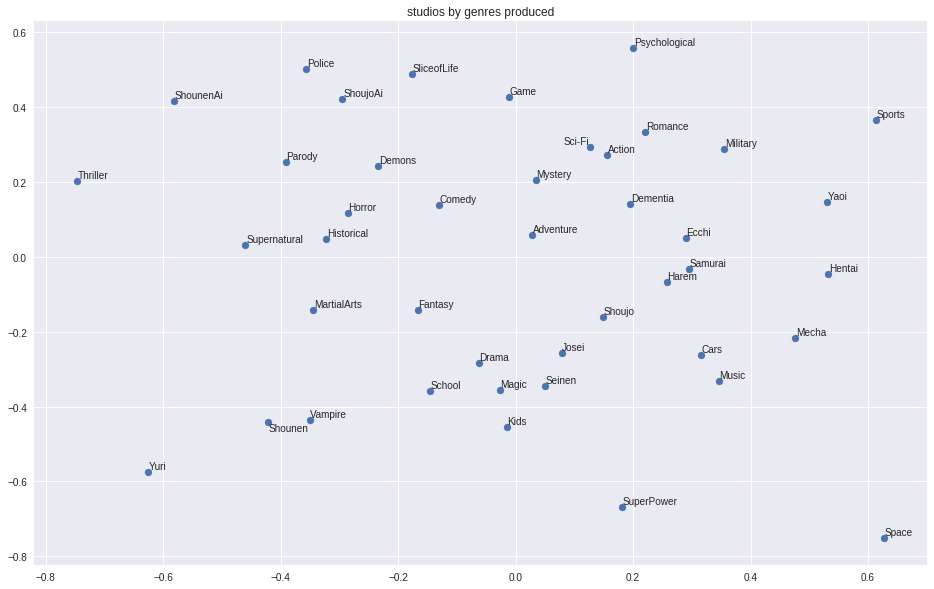

In [267]:
%matplotlib inline

dists = pdist(genres_animes, lambda x, y: nsd(x, y))
dists_m = squareform(dists)
dists_m[dists_m == np.inf] = 0  # I need to set infinities to zeros, then it handles infinities as missing data, which is wanted
embedder = manifold.MDS(2, metric=False, max_iter=2000, n_init=5, dissimilarity='precomputed')
embeddings = embedder.fit_transform(dists_m)
# need to agregate animes_studios because it does not contain duplicities because of genres
plt.figure(figsize=(16, 10))
plt.scatter(embeddings[:, 0], embeddings[:, 1])
plt.title("studios by genres produced")
texts = [plt.text(embeddings[i, 0], embeddings[i, 1], txt) for i, txt in enumerate(genres_animes.index)]
adjust_text(texts)

/home.stud/racinmat/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


500

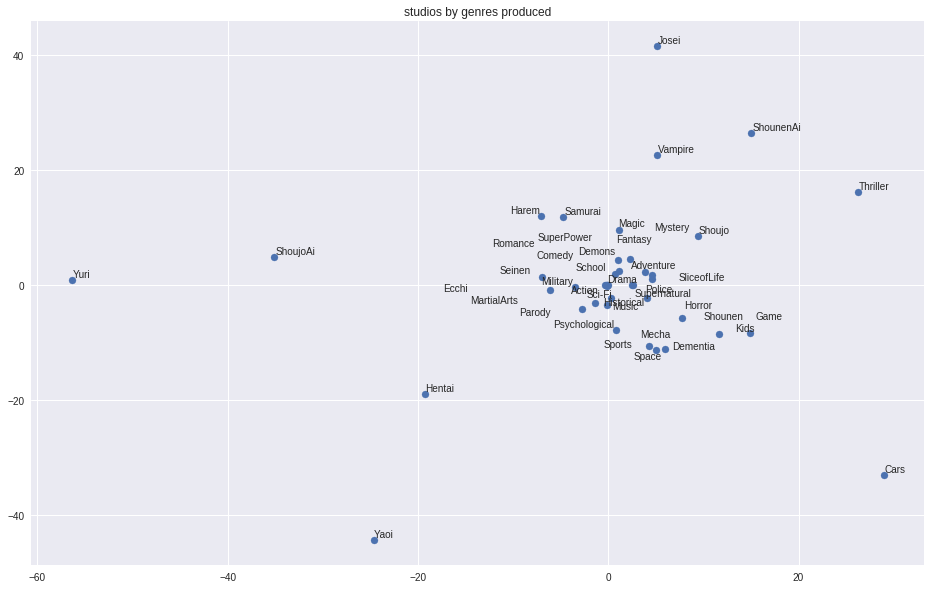

In [290]:
%matplotlib inline

dists = pdist(genres_animes, lambda x, y: nsd(x, y))
dists_m = squareform(dists)
dists_m[dists_m == np.inf] = 100
embedder = manifold.MDS(2, metric=True, max_iter=2000, n_init=5, dissimilarity='precomputed')
embeddings = embedder.fit_transform(dists_m)
# need to agregate animes_studios because it does not contain duplicities because of genres
plt.figure(figsize=(16, 10))
plt.scatter(embeddings[:, 0], embeddings[:, 1])
plt.title("studios by genres produced")
texts = [plt.text(embeddings[i, 0], embeddings[i, 1], txt) for i, txt in enumerate(genres_animes.index)]
adjust_text(texts)

/home.stud/racinmat/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


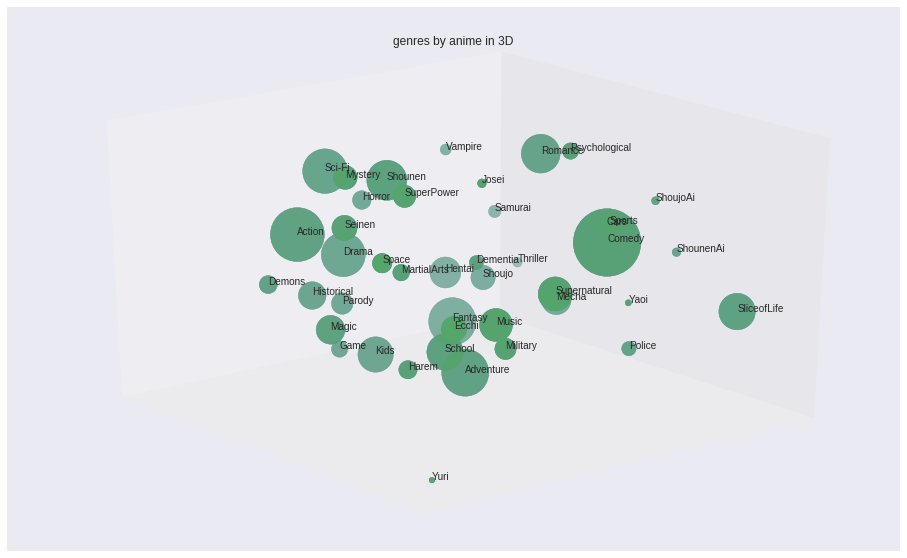

In [285]:
%matplotlib inline

dists = pdist(genres_animes, lambda x, y: nsd(x, y))
dists_m = squareform(dists)
dists_m[dists_m == np.inf] = 0  # I need to set infinities to zeros, then it handles infinities as missing data, which is wanted
embedder = manifold.MDS(3, metric=False, max_iter=2000, n_init=10, dissimilarity='precomputed')
embeddings = embedder.fit_transform(dists_m)

fig = plt.figure(figsize=(16, 10))
ax = plt.axes(projection='3d')
plt.title("genres by anime in 3D")
points_3d_to_gif(embeddings, genres_animes.index, 'genres-NSD-MSD', ax, genres_animes.sum(axis=1))

In [310]:
# now using networkx to visualize it
#df = pd.DataFrame(ints, columns=['weight', 'cost'])
dists = pdist(genres_animes, lambda x, y: nsd(x, y))
pairs = np.array(list(combinations(genres_animes.index, 2)))

#nodes = pd.DataFrame({'id': studios_genres.index, 'label': studios_genres.index})
edges = pd.DataFrame({'source': pairs[:, 0], 'target': pairs[:, 1], 'weight': dists})
edges = edges[edges['weight'] != np.inf]

G = nx.from_pandas_dataframe(edges, 'source', 'target', 'weight')

/home.stud/racinmat/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


/home.others/eb/easybuild/software/scikit-image/0.13.1-goolfc-2018a-Python-3.6.4/lib/python3.6/site-packages/networkx-1.11-py3.6.egg/networkx/drawing/nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
/home.others/eb/easybuild/software/scikit-image/0.13.1-goolfc-2018a-Python-3.6.4/lib/python3.6/site-packages/networkx-1.11-py3.6.egg/networkx/drawing/nx_pylab.py:522: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not cb.is_string_like(edge_color) \
/home.others/eb/easybuild/software/scikit-image/0.13.1-goolfc-2018a-Python-3.6.4/lib/python3.6/site-packages/networkx-1.11-py3.6.egg/networkx/drawing/nx_pylab.py:543: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if cb.is_string_like(edge_color) or len(edge_color) =

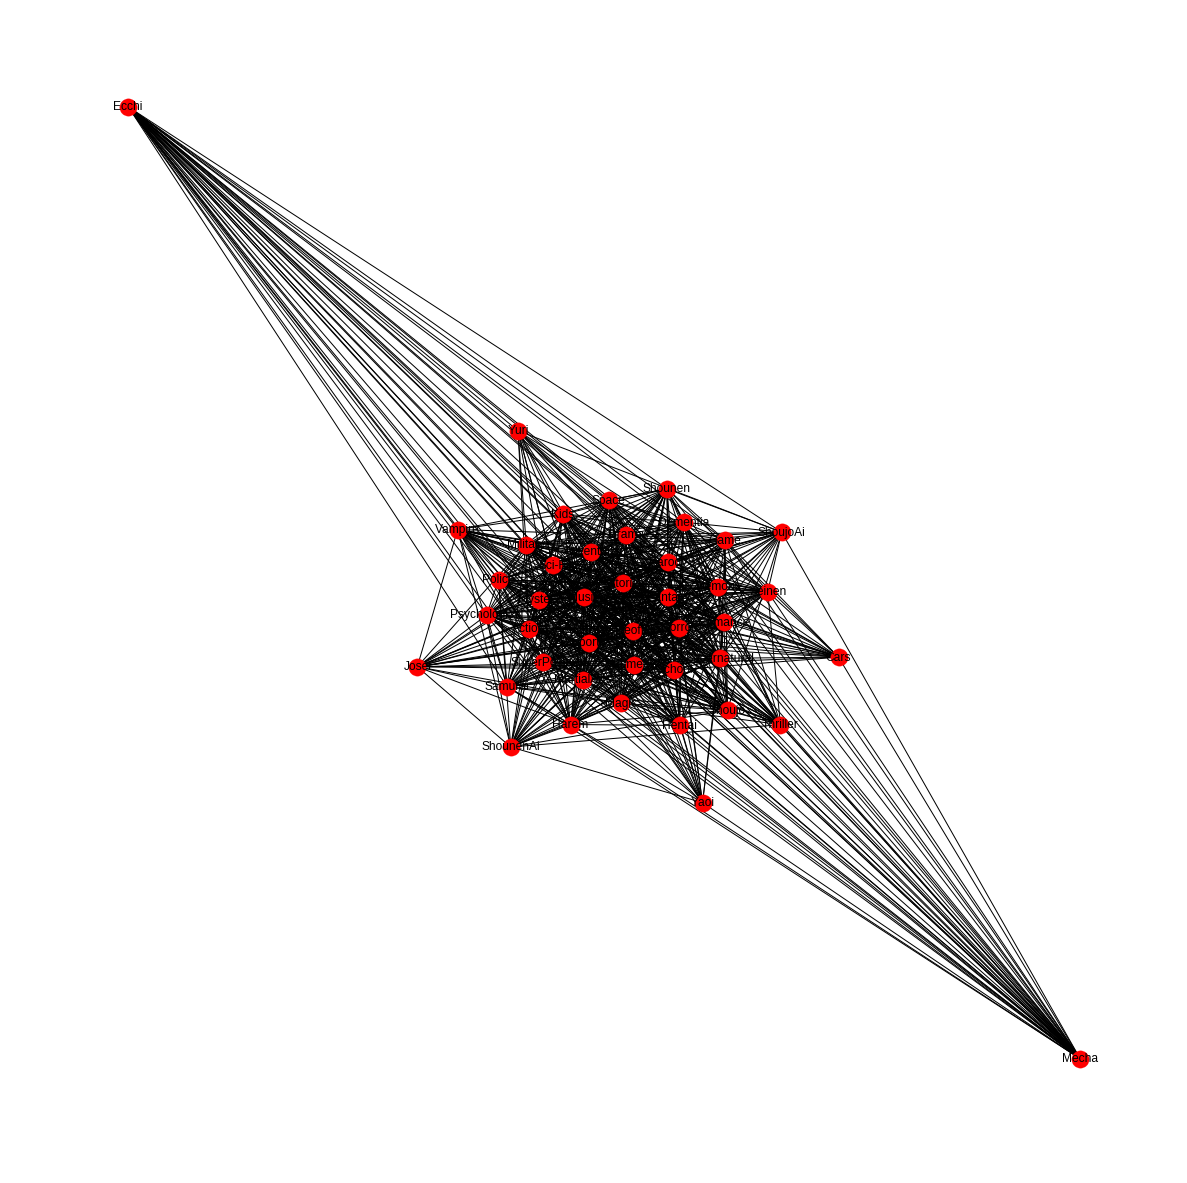

In [320]:
pos = nx.fruchterman_reingold_layout(G, dim=2, weight='weight', iterations=5000)
plt.figure(figsize=(16, 16))
nx.draw(G, pos, with_labels=True)
plt.show()

In [315]:
G['Action']['Adventure']['cost']

KeyError: 'cost'

In [313]:
edges

source         target    weight
0          Action      Adventure  0.685547
1          Action           Cars  0.904336
2          Action         Comedy  1.147617
3          Action       Dementia  1.349589
4          Action         Demons  0.823032
5          Action          Drama  0.948375
6          Action          Ecchi  0.927109
7          Action        Fantasy  0.761610
8          Action           Game  0.901741
9          Action          Harem  1.043414
10         Action         Hentai  1.850234
11         Action     Historical  0.966235
12         Action         Horror  0.880651
13         Action          Josei  1.023409
14         Action           Kids  1.446241
15         Action          Magic  0.860410
16         Action    MartialArts  0.695908
17         Action          Mecha  0.646852
18         Action       Military  0.707083
19         Action          Music  1.667664
20         Action        Mystery  0.890553
21         Action         Parody  1.134119
22         Action         Police  0.832492
23         Action  Psychological  1.005932
24         Action        Romance  1.167242
25         Action        Samurai  0.764686
26         Action         School  1.189983
27         Action         Sci-Fi  0.593675
28         Action         Seinen  0.858848
29         Action         Shoujo  1.220525
..            ...            ...       ...
853       Shounen   Supernatural  0.818354
854       Shounen       Thriller  1.126181
855       Shounen        Vampire  0.918575
858     ShounenAi    SliceofLife  0.989872
860     ShounenAi         Sports  1.102720
861     ShounenAi     SuperPower  1.228691
862     ShounenAi   Supernatural  0.860951
863     ShounenAi       Thriller  0.901513
864     ShounenAi        Vampire  0.733545
865     ShounenAi           Yaoi  0.757314
867   SliceofLife          Space  1.526914
868   SliceofLife         Sports  1.141450
869   SliceofLife     SuperPower  1.611697
870   SliceofLife   Supernatural  1.165040
871   SliceofLife       Thriller  1.490699
872   SliceofLife        Vampire  1.572150
873   SliceofLife           Yaoi  1.137403
875         Space         Sports  1.501694
876         Space     SuperPower  1.199990
877         Space   Supernatural  1.530912
882        Sports     SuperPower  1.217278
883        Sports   Supernatural  1.910543
886        Sports           Yaoi  0.974068
888    SuperPower   Supernatural  0.805291
889    SuperPower       Thriller  1.057937
890    SuperPower        Vampire  0.901498
893  Supernatural       Thriller  0.719419
894  Supernatural        Vampire  0.571065
895  Supernatural           Yaoi  1.112851
897      Thriller        Vampire  0.994986

[755 rows x 3 columns]